In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import random
from scipy.stats import ks_2samp
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
#not used
def roundR(x, r):
    return [np.round(i,r) for i in np.array(x)]

In [3]:
#not used
def update_weights(model_weights):
  for i in range(len(model_weights)):
    for j in range(len(model_weights[i])):
      if isinstance(model_weights[i][j], np.ndarray):
        for k in range(len(model_weights[i][j])):
          #print("chalra h", i, j, k)
            if (np.round(model_weights[i][j][k],2)==0):
                model_weights[i][j][k]=float(f'{model_weights[i][j][k]:.1g}')
            else:
                model_weights[i][j][k]=np.round(model_weights[i][j][k],2)
      else:
        if (np.round(model_weights[i][j],2)==0):
          model_weights[i][j]=float(f'{model_weights[i][j]:.1g}')
        else:
          model_weights[i][j]=np.round(model_weights[i][j],2)
  return model_weights

In [4]:
#compare neurons from teo different networks
def node_comparison1(node1, node2, epsilon=0.05):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(abs(x-y)<=epsilon):
            continue
        else:
            return False
  return True

In [5]:
#not used
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [6]:
#compares layers 
def layer_comparison(layer1, layer2, epsilon = 0.05):
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2, epsilon = 0.05)):
        present=True
    if present==False:
      return False
  return True

In [7]:
def check_models(Model_weights1, Model_weights2, epsilon = 0.05):
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2), epsilon = 0.05):
      continue
    else:
      return False
  return True

In [8]:
#model with architecture input-5-10-5-output 
def get_initial_model(inp, out):
    model = tf.keras.Sequential([
        Dense(5, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
#model with architecture input-1024-output 
def get_initial_model_2(inp, out):
    model = tf.keras.Sequential([
        Dense(1024, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
#model with architecture input-10-20-10-output 
def get_initial_model_3(inp, out):
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
#model with architecture input-5-10-20-10-5-output 
def get_initial_model_4(inp, out):
    model = tf.keras.Sequential([
        Dense(5, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(10, activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
#DP models 
def get_DP_initial_model(inp, out):
    model=tf.keras.Sequential([
        Dense(5, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        Dense(out, activation='softmax')
        ])
    return model

In [13]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
#different get_avg_weights function for different architecture. Could have been implemented in a simpler way
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [14]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [15]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_3(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_3(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [16]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_4(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_4(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [17]:
# custom functions for f1, precision and recall

from keras import backend as K
from keras.utils import to_categorical

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
#for Diabetes 0-1-2 dataset
dataset = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv",sep=',')
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()

dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
target_variable="Diabetes_012"

In [19]:
labels=[0.0,0.5,1.0]
data=[]
len_clas=[]
N=5000
for i in range(len(labels)):
    data.append(dataset[dataset[target_variable]==labels[i]])
    print(len(data[i]))
    len_clas.append(int((data[i].shape[0]/dataset.shape[0])*N))
print(len_clas)

213703
4631
35346
[4212, 91, 696]


In [23]:
#defining test set
for i in range(len(data)):
    if i==0:
        df=data[i].sample(min(len(data[i]), len_clas[i]))
        data[i].drop(df.index, inplace=True)
    else:
        df1=data[i].sample(min(len(data[i]), len_clas[i]))
        df=df.append(df1, ignore_index = True)
        data[i].drop(df1.index, inplace=True)
df=df.sample(frac=1)
df=df.sample(frac=1)
df=df.sample(frac=1)
X_test=df.drop(columns=[target_variable])
y_test=to_categorical(df[target_variable], num_classes=3)

Models=[]
initial_model=get_initial_model(dataset.shape[1]-1, 3)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
add_weights=[]
while data[0].empty==False:
    for i in range(len(data)):
        if i==0:
            df=data[i].sample(min(len(data[i]), len_clas[i]))
            data[i].drop(df.index, inplace=True)
        else:
            df1=data[i].sample(min(len(data[i]), len_clas[i]))
            df=df.append(df1, ignore_index = True)
            data[i].drop(df1.index, inplace=True)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    #print(df.columns)
    """X_data=(df.iloc[:,1:].values).astype('float32')
    X_data=scaler.fit_transform(X_data)
    X_data=X_data.reshape(X_data.shape[0], 28, 28, 1)
    X=X_data"""
    X=df.drop(columns=[target_variable])
    #print(X.shape)
    y=df[target_variable]
    y_data=to_categorical(y, num_classes=3)
    y=y_data
    #y.columns=y_data.columns
    #print(y.shape[0])
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    #batches = gen.flow(X_train, y_train, batch_size=32)
    #print(batches.n)
    #val_batches=gen.flow(X_val, y_val, batch_size=32)
    #print(val_batches.n)
    ann_model=get_initial_model(dataset.shape[1]-1, 3)
    ann_model.set_weights(initial_model.get_weights())
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])
    history = ann_model.fit(X, y, epochs=20, validation_split=0.2, verbose=1)
    #print(ann_model.get_weights())
    ann_model.set_weights(update_weights(ann_model.get_weights()))
    pred_test=ann_model.predict(X_test)
    present=False
    for i in range(len(Models)):
        if (check_models(Models[i][0], ann_model.get_weights())):
            print("if any")
            Models[i][1]=Models[i][1]+1
            add_weights[i].append(ann_model.get_weights())
            val_acc[i].append(history.history['val_f1_m'])
            train_acc[i].append(history.history['f1_m'])
            test_acc[i].append(f1_m(y_test, pred_test).numpy())
            val_loss[i].append(history.history['val_loss'])
            train_loss[i].append(history.history['loss'])
            present=True
    if present==False:
        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])
        val_acc.append([history.history['val_f1_m']])
        train_acc.append([history.history['f1_m']])
        test_acc.append([f1_m(y_test, pred_test).numpy()])
        val_loss.append([history.history['val_loss']])
        train_loss.append([history.history['loss']])
for i in range(len(Models)):
    print(Models[i][1])
print("All Done")

Epoch 1/20
125/125 [==============================] - 0s 2ms/step - loss: 0.7730 - f1_m: 0.5184 - val_loss: 0.5048 - val_f1_m: 0.8623
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4435 - f1_m: 0.8605 - val_loss: 0.4043 - val_f1_m: 0.8623
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3868 - f1_m: 0.8605 - val_loss: 0.3771 - val_f1_m: 0.8623
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3646 - f1_m: 0.8605 - val_loss: 0.3616 - val_f1_m: 0.8623
Epoch 5/20
125/125 [==============================] - 0s 968us/step - loss: 0.3462 - f1_m: 0.8603 - val_loss: 0.3536 - val_f1_m: 0.8628
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3323 - f1_m: 0.8588 - val_loss: 0.3424 - val_f1_m: 0.8626
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3273 - f1_m: 0.8601 - val_loss: 0.3409 - val_f1_m: 0.8649
Epoch 8/20
125/125 [==============================] - 0s 984

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7688 - f1_m: 0.5210 - val_loss: 0.5601 - val_f1_m: 0.8467
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4463 - f1_m: 0.8645 - val_loss: 0.4490 - val_f1_m: 0.8467
Epoch 3/20
125/125 [==============================] - 0s 965us/step - loss: 0.3891 - f1_m: 0.8645 - val_loss: 0.4098 - val_f1_m: 0.8467
Epoch 4/20
125/125 [==============================] - 0s 974us/step - loss: 0.3651 - f1_m: 0.8645 - val_loss: 0.3973 - val_f1_m: 0.8467
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3525 - f1_m: 0.8645 - val_loss: 0.3815 - val_f1_m: 0.8467
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3389 - f1_m: 0.8645 - val_loss: 0.3680 - val_f1_m: 0.8467
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3335 - f1_m: 0.8645 - val_loss: 0.3646 - val_f1_m: 0.8467
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - l

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7738 - f1_m: 0.5227 - val_loss: 0.5323 - val_f1_m: 0.8643
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4530 - f1_m: 0.8607 - val_loss: 0.4188 - val_f1_m: 0.8643
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3915 - f1_m: 0.8607 - val_loss: 0.3889 - val_f1_m: 0.8643
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3664 - f1_m: 0.8607 - val_loss: 0.3678 - val_f1_m: 0.8643
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3524 - f1_m: 0.8607 - val_loss: 0.3578 - val_f1_m: 0.8643
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3444 - f1_m: 0.8607 - val_loss: 0.3513 - val_f1_m: 0.8643
Epoch 7/20
125/125 [==============================] - 0s 952us/step - loss: 0.3388 - f1_m: 0.8607 - val_loss: 0.3508 - val_f1_m: 0.8643
Epoch 8/20
125/125 [==============================] - 0s 947us/step - l

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7675 - f1_m: 0.5378 - val_loss: 0.5285 - val_f1_m: 0.8555
Epoch 2/20
125/125 [==============================] - 0s 978us/step - loss: 0.4513 - f1_m: 0.8622 - val_loss: 0.4317 - val_f1_m: 0.8555
Epoch 3/20
125/125 [==============================] - 0s 963us/step - loss: 0.3970 - f1_m: 0.8622 - val_loss: 0.4046 - val_f1_m: 0.8555
Epoch 4/20
125/125 [==============================] - 0s 938us/step - loss: 0.3759 - f1_m: 0.8622 - val_loss: 0.3903 - val_f1_m: 0.8555
Epoch 5/20
125/125 [==============================] - 0s 953us/step - loss: 0.3631 - f1_m: 0.8622 - val_loss: 0.3847 - val_f1_m: 0.8555
Epoch 6/20
125/125 [==============================] - 0s 944us/step - loss: 0.3547 - f1_m: 0.8622 - val_loss: 0.3789 - val_f1_m: 0.8555
Epoch 7/20
125/125 [==============================] - 0s 932us/step - loss: 0.3488 - f1_m: 0.8622 - val_loss: 0.3755 - val_f1_m: 0.8555
Epoch 8/20
125/125 [==============================] - 0s 944u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.7687 - f1_m: 0.5298 - val_loss: 0.5247 - val_f1_m: 0.8535
Epoch 2/20
125/125 [==============================] - 0s 936us/step - loss: 0.4418 - f1_m: 0.8620 - val_loss: 0.4165 - val_f1_m: 0.8535
Epoch 3/20
125/125 [==============================] - 0s 965us/step - loss: 0.3855 - f1_m: 0.8620 - val_loss: 0.3892 - val_f1_m: 0.8535
Epoch 4/20
125/125 [==============================] - 0s 948us/step - loss: 0.3663 - f1_m: 0.8620 - val_loss: 0.3782 - val_f1_m: 0.8535
Epoch 5/20
125/125 [==============================] - 0s 923us/step - loss: 0.3550 - f1_m: 0.8620 - val_loss: 0.3689 - val_f1_m: 0.8535
Epoch 6/20
125/125 [==============================] - 0s 925us/step - loss: 0.3441 - f1_m: 0.8616 - val_loss: 0.3614 - val_f1_m: 0.8535
Epoch 7/20
125/125 [==============================] - 0s 917us/step - loss: 0.3383 - f1_m: 0.8613 - val_loss: 0.3619 - val_f1_m: 0.8548
Epoch 8/20
125/125 [==============================] - 0s 932u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7671 - f1_m: 0.5292 - val_loss: 0.5125 - val_f1_m: 0.8633
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4429 - f1_m: 0.8610 - val_loss: 0.4040 - val_f1_m: 0.8633
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3870 - f1_m: 0.8610 - val_loss: 0.3713 - val_f1_m: 0.8633
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3648 - f1_m: 0.8610 - val_loss: 0.3486 - val_f1_m: 0.8633
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3510 - f1_m: 0.8610 - val_loss: 0.3364 - val_f1_m: 0.8633
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3376 - f1_m: 0.8617 - val_loss: 0.3246 - val_f1_m: 0.8633
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3307 - f1_m: 0.8633 - val_loss: 0.3267 - val_f1_m: 0.8600
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7619 - f1_m: 0.5337 - val_loss: 0.5465 - val_f1_m: 0.8496
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4454 - f1_m: 0.8630 - val_loss: 0.4269 - val_f1_m: 0.8496
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3879 - f1_m: 0.8629 - val_loss: 0.3968 - val_f1_m: 0.8496
Epoch 4/20
125/125 [==============================] - 0s 976us/step - loss: 0.3660 - f1_m: 0.8630 - val_loss: 0.3748 - val_f1_m: 0.8496
Epoch 5/20
125/125 [==============================] - 0s 982us/step - loss: 0.3530 - f1_m: 0.8629 - val_loss: 0.3539 - val_f1_m: 0.8496
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3424 - f1_m: 0.8628 - val_loss: 0.3454 - val_f1_m: 0.8496
Epoch 7/20
125/125 [==============================] - 0s 976us/step - loss: 0.3379 - f1_m: 0.8627 - val_loss: 0.3425 - val_f1_m: 0.8496
Epoch 8/20
125/125 [==============================] - 0s 975us/step

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7631 - f1_m: 0.5369 - val_loss: 0.5373 - val_f1_m: 0.8467
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4493 - f1_m: 0.8630 - val_loss: 0.4357 - val_f1_m: 0.8467
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4008 - f1_m: 0.8630 - val_loss: 0.4110 - val_f1_m: 0.8467
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3813 - f1_m: 0.8630 - val_loss: 0.3926 - val_f1_m: 0.8467
Epoch 5/20
125/125 [==============================] - 0s 997us/step - loss: 0.3677 - f1_m: 0.8630 - val_loss: 0.3828 - val_f1_m: 0.8467
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3587 - f1_m: 0.8630 - val_loss: 0.3743 - val_f1_m: 0.8467
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3528 - f1_m: 0.8628 - val_loss: 0.3687 - val_f1_m: 0.8467
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7600 - f1_m: 0.5346 - val_loss: 0.5393 - val_f1_m: 0.8477
Epoch 2/20
125/125 [==============================] - 0s 987us/step - loss: 0.4395 - f1_m: 0.8642 - val_loss: 0.4264 - val_f1_m: 0.8477
Epoch 3/20
125/125 [==============================] - 0s 987us/step - loss: 0.3842 - f1_m: 0.8642 - val_loss: 0.3925 - val_f1_m: 0.8477
Epoch 4/20
125/125 [==============================] - 0s 981us/step - loss: 0.3628 - f1_m: 0.8642 - val_loss: 0.3774 - val_f1_m: 0.8477
Epoch 5/20
125/125 [==============================] - 0s 967us/step - loss: 0.3506 - f1_m: 0.8642 - val_loss: 0.3691 - val_f1_m: 0.8477
Epoch 6/20
125/125 [==============================] - 0s 964us/step - loss: 0.3429 - f1_m: 0.8642 - val_loss: 0.3641 - val_f1_m: 0.8477
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3389 - f1_m: 0.8642 - val_loss: 0.3615 - val_f1_m: 0.8477
Epoch 8/20
125/125 [==============================] - 0s 1ms/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7619 - f1_m: 0.5359 - val_loss: 0.5267 - val_f1_m: 0.8506
Epoch 2/20
125/125 [==============================] - 0s 970us/step - loss: 0.4394 - f1_m: 0.8627 - val_loss: 0.4173 - val_f1_m: 0.8506
Epoch 3/20
125/125 [==============================] - 0s 968us/step - loss: 0.3849 - f1_m: 0.8627 - val_loss: 0.3884 - val_f1_m: 0.8506
Epoch 4/20
125/125 [==============================] - 0s 921us/step - loss: 0.3649 - f1_m: 0.8627 - val_loss: 0.3739 - val_f1_m: 0.8506
Epoch 5/20
125/125 [==============================] - 0s 984us/step - loss: 0.3510 - f1_m: 0.8627 - val_loss: 0.3683 - val_f1_m: 0.8506
Epoch 6/20
125/125 [==============================] - 0s 948us/step - loss: 0.3442 - f1_m: 0.8627 - val_loss: 0.3645 - val_f1_m: 0.8506
Epoch 7/20
125/125 [==============================] - 0s 955us/step - loss: 0.3402 - f1_m: 0.8627 - val_loss: 0.3593 - val_f1_m: 0.8506
Epoch 8/20
125/125 [==============================] - 0s 947u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7705 - f1_m: 0.5316 - val_loss: 0.5459 - val_f1_m: 0.8516
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4503 - f1_m: 0.8640 - val_loss: 0.4437 - val_f1_m: 0.8516
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4017 - f1_m: 0.8640 - val_loss: 0.4172 - val_f1_m: 0.8516
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3806 - f1_m: 0.8641 - val_loss: 0.3963 - val_f1_m: 0.8516
Epoch 5/20
125/125 [==============================] - 0s 953us/step - loss: 0.3643 - f1_m: 0.8641 - val_loss: 0.3838 - val_f1_m: 0.8516
Epoch 6/20
125/125 [==============================] - 0s 954us/step - loss: 0.3487 - f1_m: 0.8637 - val_loss: 0.3725 - val_f1_m: 0.8502
Epoch 7/20
125/125 [==============================] - 0s 941us/step - loss: 0.3405 - f1_m: 0.8640 - val_loss: 0.3645 - val_f1_m: 0.8500
Epoch 8/20
125/125 [==============================] - 0s 950us/step

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7799 - f1_m: 0.5194 - val_loss: 0.5016 - val_f1_m: 0.8662
Epoch 2/20
125/125 [==============================] - 0s 948us/step - loss: 0.4465 - f1_m: 0.8595 - val_loss: 0.3972 - val_f1_m: 0.8662
Epoch 3/20
125/125 [==============================] - 0s 947us/step - loss: 0.3885 - f1_m: 0.8595 - val_loss: 0.3704 - val_f1_m: 0.8662
Epoch 4/20
125/125 [==============================] - 0s 916us/step - loss: 0.3678 - f1_m: 0.8594 - val_loss: 0.3530 - val_f1_m: 0.8662
Epoch 5/20
125/125 [==============================] - 0s 918us/step - loss: 0.3558 - f1_m: 0.8595 - val_loss: 0.3455 - val_f1_m: 0.8662
Epoch 6/20
125/125 [==============================] - 0s 928us/step - loss: 0.3474 - f1_m: 0.8595 - val_loss: 0.3433 - val_f1_m: 0.8662
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3439 - f1_m: 0.8595 - val_loss: 0.3375 - val_f1_m: 0.8662
Epoch 8/20
125/125 [==============================] - 0s 1ms/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7725 - f1_m: 0.5287 - val_loss: 0.5160 - val_f1_m: 0.8613
Epoch 2/20
125/125 [==============================] - 0s 953us/step - loss: 0.4583 - f1_m: 0.8607 - val_loss: 0.4188 - val_f1_m: 0.8613
Epoch 3/20
125/125 [==============================] - 0s 942us/step - loss: 0.4092 - f1_m: 0.8607 - val_loss: 0.3939 - val_f1_m: 0.8613
Epoch 4/20
125/125 [==============================] - 0s 932us/step - loss: 0.3873 - f1_m: 0.8607 - val_loss: 0.3735 - val_f1_m: 0.8613
Epoch 5/20
125/125 [==============================] - 0s 932us/step - loss: 0.3708 - f1_m: 0.8607 - val_loss: 0.3602 - val_f1_m: 0.8613
Epoch 6/20
125/125 [==============================] - 0s 970us/step - loss: 0.3620 - f1_m: 0.8607 - val_loss: 0.3544 - val_f1_m: 0.8613
Epoch 7/20
125/125 [==============================] - 0s 944us/step - loss: 0.3566 - f1_m: 0.8607 - val_loss: 0.3501 - val_f1_m: 0.8613
Epoch 8/20
125/125 [==============================] - 0s 965u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7645 - f1_m: 0.5341 - val_loss: 0.5403 - val_f1_m: 0.8477
Epoch 2/20
125/125 [==============================] - 0s 950us/step - loss: 0.4447 - f1_m: 0.8635 - val_loss: 0.4230 - val_f1_m: 0.8477
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3879 - f1_m: 0.8635 - val_loss: 0.3892 - val_f1_m: 0.8477
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3674 - f1_m: 0.8635 - val_loss: 0.3720 - val_f1_m: 0.8477
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3548 - f1_m: 0.8635 - val_loss: 0.3606 - val_f1_m: 0.8477
Epoch 6/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3475 - f1_m: 0.8635 - val_loss: 0.3538 - val_f1_m: 0.8477
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3431 - f1_m: 0.8635 - val_loss: 0.3504 - val_f1_m: 0.8477
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
125/125 [==============================] - 0s 2ms/step - loss: 0.7631 - f1_m: 0.5352 - val_loss: 0.5097 - val_f1_m: 0.8584
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4558 - f1_m: 0.8600 - val_loss: 0.4142 - val_f1_m: 0.8584
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4089 - f1_m: 0.8600 - val_loss: 0.3890 - val_f1_m: 0.8584
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3893 - f1_m: 0.8600 - val_loss: 0.3721 - val_f1_m: 0.8584
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3771 - f1_m: 0.8601 - val_loss: 0.3636 - val_f1_m: 0.8584
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3683 - f1_m: 0.8601 - val_loss: 0.3542 - val_f1_m: 0.8584
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3593 - f1_m: 0.8602 - val_loss: 0.3452 - val_f1_m: 0.8584
Epoch 8/20
125/125 [==============================] - 0s 1ms/s

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7755 - f1_m: 0.5228 - val_loss: 0.5473 - val_f1_m: 0.8506
Epoch 2/20
125/125 [==============================] - 0s 998us/step - loss: 0.4426 - f1_m: 0.8635 - val_loss: 0.4292 - val_f1_m: 0.8506
Epoch 3/20
125/125 [==============================] - 0s 959us/step - loss: 0.3843 - f1_m: 0.8634 - val_loss: 0.4016 - val_f1_m: 0.8506
Epoch 4/20
125/125 [==============================] - 0s 972us/step - loss: 0.3626 - f1_m: 0.8635 - val_loss: 0.3783 - val_f1_m: 0.8506
Epoch 5/20
125/125 [==============================] - 0s 952us/step - loss: 0.3509 - f1_m: 0.8635 - val_loss: 0.3687 - val_f1_m: 0.8506
Epoch 6/20
125/125 [==============================] - 0s 991us/step - loss: 0.3451 - f1_m: 0.8635 - val_loss: 0.3615 - val_f1_m: 0.8506
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3398 - f1_m: 0.8635 - val_loss: 0.3629 - val_f1_m: 0.8506
Epoch 8/20
125/125 [==============================] - 0s 968us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7831 - f1_m: 0.5316 - val_loss: 0.5082 - val_f1_m: 0.8672
Epoch 2/20
125/125 [==============================] - 0s 919us/step - loss: 0.4546 - f1_m: 0.8592 - val_loss: 0.4037 - val_f1_m: 0.8672
Epoch 3/20
125/125 [==============================] - 0s 919us/step - loss: 0.3989 - f1_m: 0.8592 - val_loss: 0.3732 - val_f1_m: 0.8672
Epoch 4/20
125/125 [==============================] - 0s 980us/step - loss: 0.3818 - f1_m: 0.8592 - val_loss: 0.3596 - val_f1_m: 0.8672
Epoch 5/20
125/125 [==============================] - 0s 954us/step - loss: 0.3704 - f1_m: 0.8592 - val_loss: 0.3508 - val_f1_m: 0.8672
Epoch 6/20
125/125 [==============================] - 0s 912us/step - loss: 0.3627 - f1_m: 0.8592 - val_loss: 0.3437 - val_f1_m: 0.8672
Epoch 7/20
125/125 [==============================] - 0s 919us/step - loss: 0.3576 - f1_m: 0.8592 - val_loss: 0.3382 - val_f1_m: 0.8672
Epoch 8/20
125/125 [==============================] - 0s 919u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7610 - f1_m: 0.5306 - val_loss: 0.5251 - val_f1_m: 0.8564
Epoch 2/20
125/125 [==============================] - 0s 967us/step - loss: 0.4505 - f1_m: 0.8620 - val_loss: 0.4227 - val_f1_m: 0.8564
Epoch 3/20
125/125 [==============================] - 0s 926us/step - loss: 0.3967 - f1_m: 0.8620 - val_loss: 0.3917 - val_f1_m: 0.8564
Epoch 4/20
125/125 [==============================] - 0s 933us/step - loss: 0.3728 - f1_m: 0.8620 - val_loss: 0.3777 - val_f1_m: 0.8564
Epoch 5/20
125/125 [==============================] - 0s 923us/step - loss: 0.3585 - f1_m: 0.8620 - val_loss: 0.3677 - val_f1_m: 0.8564
Epoch 6/20
125/125 [==============================] - 0s 930us/step - loss: 0.3480 - f1_m: 0.8620 - val_loss: 0.3636 - val_f1_m: 0.8564
Epoch 7/20
125/125 [==============================] - 0s 931us/step - loss: 0.3422 - f1_m: 0.8619 - val_loss: 0.3613 - val_f1_m: 0.8564
Epoch 8/20
125/125 [==============================] - 0s 959u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7703 - f1_m: 0.5309 - val_loss: 0.5228 - val_f1_m: 0.8574
Epoch 2/20
125/125 [==============================] - 0s 967us/step - loss: 0.4527 - f1_m: 0.8617 - val_loss: 0.4320 - val_f1_m: 0.8574
Epoch 3/20
125/125 [==============================] - 0s 982us/step - loss: 0.4070 - f1_m: 0.8617 - val_loss: 0.4084 - val_f1_m: 0.8574
Epoch 4/20
125/125 [==============================] - 0s 933us/step - loss: 0.3892 - f1_m: 0.8617 - val_loss: 0.3949 - val_f1_m: 0.8574
Epoch 5/20
125/125 [==============================] - 0s 929us/step - loss: 0.3766 - f1_m: 0.8617 - val_loss: 0.3857 - val_f1_m: 0.8574
Epoch 6/20
125/125 [==============================] - 0s 908us/step - loss: 0.3675 - f1_m: 0.8617 - val_loss: 0.3793 - val_f1_m: 0.8574
Epoch 7/20
125/125 [==============================] - 0s 918us/step - loss: 0.3609 - f1_m: 0.8617 - val_loss: 0.3774 - val_f1_m: 0.8574
Epoch 8/20
125/125 [==============================] - 0s 948u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7766 - f1_m: 0.5208 - val_loss: 0.4841 - val_f1_m: 0.8730
Epoch 2/20
125/125 [==============================] - 0s 953us/step - loss: 0.4489 - f1_m: 0.8577 - val_loss: 0.3749 - val_f1_m: 0.8730
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3874 - f1_m: 0.8577 - val_loss: 0.3403 - val_f1_m: 0.8730
Epoch 4/20
125/125 [==============================] - 0s 994us/step - loss: 0.3630 - f1_m: 0.8577 - val_loss: 0.3235 - val_f1_m: 0.8730
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3497 - f1_m: 0.8577 - val_loss: 0.3152 - val_f1_m: 0.8730
Epoch 6/20
125/125 [==============================] - 0s 955us/step - loss: 0.3407 - f1_m: 0.8577 - val_loss: 0.3086 - val_f1_m: 0.8730
Epoch 7/20
125/125 [==============================] - 0s 987us/step - loss: 0.3362 - f1_m: 0.8577 - val_loss: 0.3126 - val_f1_m: 0.8730
Epoch 8/20
125/125 [==============================] - 0s 968us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7656 - f1_m: 0.5318 - val_loss: 0.5238 - val_f1_m: 0.8604
Epoch 2/20
125/125 [==============================] - 0s 977us/step - loss: 0.4408 - f1_m: 0.8617 - val_loss: 0.4170 - val_f1_m: 0.8604
Epoch 3/20
125/125 [==============================] - 0s 970us/step - loss: 0.3855 - f1_m: 0.8617 - val_loss: 0.3859 - val_f1_m: 0.8604
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3638 - f1_m: 0.8617 - val_loss: 0.3711 - val_f1_m: 0.8604
Epoch 5/20
125/125 [==============================] - 0s 992us/step - loss: 0.3522 - f1_m: 0.8617 - val_loss: 0.3629 - val_f1_m: 0.8604
Epoch 6/20
125/125 [==============================] - 0s 970us/step - loss: 0.3446 - f1_m: 0.8617 - val_loss: 0.3537 - val_f1_m: 0.8604
Epoch 7/20
125/125 [==============================] - 0s 934us/step - loss: 0.3407 - f1_m: 0.8617 - val_loss: 0.3521 - val_f1_m: 0.8604
Epoch 8/20
125/125 [==============================] - 0s 927us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7761 - f1_m: 0.5283 - val_loss: 0.4759 - val_f1_m: 0.8760
Epoch 2/20
125/125 [==============================] - 0s 968us/step - loss: 0.4470 - f1_m: 0.8570 - val_loss: 0.3745 - val_f1_m: 0.8760
Epoch 3/20
125/125 [==============================] - 0s 958us/step - loss: 0.3891 - f1_m: 0.8569 - val_loss: 0.3558 - val_f1_m: 0.8760
Epoch 4/20
125/125 [==============================] - 0s 933us/step - loss: 0.3667 - f1_m: 0.8570 - val_loss: 0.3424 - val_f1_m: 0.8760
Epoch 5/20
125/125 [==============================] - 0s 945us/step - loss: 0.3537 - f1_m: 0.8570 - val_loss: 0.3326 - val_f1_m: 0.8760
Epoch 6/20
125/125 [==============================] - 0s 946us/step - loss: 0.3410 - f1_m: 0.8570 - val_loss: 0.3319 - val_f1_m: 0.8775
Epoch 7/20
125/125 [==============================] - 0s 935us/step - loss: 0.3371 - f1_m: 0.8587 - val_loss: 0.3397 - val_f1_m: 0.8756
Epoch 8/20
125/125 [==============================] - 0s 937u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7653 - f1_m: 0.5318 - val_loss: 0.5627 - val_f1_m: 0.8457
Epoch 2/20
125/125 [==============================] - 0s 957us/step - loss: 0.4449 - f1_m: 0.8655 - val_loss: 0.4606 - val_f1_m: 0.8457
Epoch 3/20
125/125 [==============================] - 0s 967us/step - loss: 0.3976 - f1_m: 0.8655 - val_loss: 0.4359 - val_f1_m: 0.8457
Epoch 4/20
125/125 [==============================] - 0s 937us/step - loss: 0.3792 - f1_m: 0.8655 - val_loss: 0.4157 - val_f1_m: 0.8457
Epoch 5/20
125/125 [==============================] - 0s 938us/step - loss: 0.3664 - f1_m: 0.8654 - val_loss: 0.4080 - val_f1_m: 0.8457
Epoch 6/20
125/125 [==============================] - 0s 956us/step - loss: 0.3569 - f1_m: 0.8654 - val_loss: 0.4037 - val_f1_m: 0.8457
Epoch 7/20
125/125 [==============================] - 0s 927us/step - loss: 0.3466 - f1_m: 0.8655 - val_loss: 0.3986 - val_f1_m: 0.8457
Epoch 8/20
125/125 [==============================] - 0s 925u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.7776 - f1_m: 0.5222 - val_loss: 0.5086 - val_f1_m: 0.8711
Epoch 2/20
125/125 [==============================] - 0s 980us/step - loss: 0.4502 - f1_m: 0.8590 - val_loss: 0.3997 - val_f1_m: 0.8711
Epoch 3/20
125/125 [==============================] - 0s 932us/step - loss: 0.3890 - f1_m: 0.8590 - val_loss: 0.3689 - val_f1_m: 0.8711
Epoch 4/20
125/125 [==============================] - 0s 939us/step - loss: 0.3673 - f1_m: 0.8590 - val_loss: 0.3524 - val_f1_m: 0.8711
Epoch 5/20
125/125 [==============================] - 0s 949us/step - loss: 0.3545 - f1_m: 0.8590 - val_loss: 0.3462 - val_f1_m: 0.8711
Epoch 6/20
125/125 [==============================] - 0s 947us/step - loss: 0.3464 - f1_m: 0.8590 - val_loss: 0.3390 - val_f1_m: 0.8711
Epoch 7/20
125/125 [==============================] - 0s 951us/step - loss: 0.3424 - f1_m: 0.8590 - val_loss: 0.3353 - val_f1_m: 0.8711
Epoch 8/20
125/125 [==============================] - 0s 933u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7773 - f1_m: 0.5210 - val_loss: 0.4936 - val_f1_m: 0.8721
Epoch 2/20
125/125 [==============================] - 0s 968us/step - loss: 0.4454 - f1_m: 0.8587 - val_loss: 0.3847 - val_f1_m: 0.8721
Epoch 3/20
125/125 [==============================] - 0s 987us/step - loss: 0.3892 - f1_m: 0.8587 - val_loss: 0.3603 - val_f1_m: 0.8721
Epoch 4/20
125/125 [==============================] - 0s 954us/step - loss: 0.3720 - f1_m: 0.8587 - val_loss: 0.3513 - val_f1_m: 0.8721
Epoch 5/20
125/125 [==============================] - 0s 951us/step - loss: 0.3615 - f1_m: 0.8587 - val_loss: 0.3380 - val_f1_m: 0.8721
Epoch 6/20
125/125 [==============================] - 0s 994us/step - loss: 0.3552 - f1_m: 0.8587 - val_loss: 0.3293 - val_f1_m: 0.8721
Epoch 7/20
125/125 [==============================] - 0s 928us/step - loss: 0.3493 - f1_m: 0.8587 - val_loss: 0.3308 - val_f1_m: 0.8721
Epoch 8/20
125/125 [==============================] - 0s 933u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7682 - f1_m: 0.5358 - val_loss: 0.5125 - val_f1_m: 0.8623
Epoch 2/20
125/125 [==============================] - 0s 981us/step - loss: 0.4559 - f1_m: 0.8605 - val_loss: 0.4170 - val_f1_m: 0.8623
Epoch 3/20
125/125 [==============================] - 0s 956us/step - loss: 0.4092 - f1_m: 0.8605 - val_loss: 0.3905 - val_f1_m: 0.8623
Epoch 4/20
125/125 [==============================] - 0s 937us/step - loss: 0.3901 - f1_m: 0.8605 - val_loss: 0.3701 - val_f1_m: 0.8623
Epoch 5/20
125/125 [==============================] - 0s 940us/step - loss: 0.3725 - f1_m: 0.8605 - val_loss: 0.3549 - val_f1_m: 0.8623
Epoch 6/20
125/125 [==============================] - 0s 969us/step - loss: 0.3614 - f1_m: 0.8605 - val_loss: 0.3444 - val_f1_m: 0.8623
Epoch 7/20
125/125 [==============================] - 0s 929us/step - loss: 0.3545 - f1_m: 0.8604 - val_loss: 0.3387 - val_f1_m: 0.8623
Epoch 8/20
125/125 [==============================] - 0s 1ms/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7614 - f1_m: 0.5343 - val_loss: 0.5512 - val_f1_m: 0.8506
Epoch 2/20
125/125 [==============================] - 0s 961us/step - loss: 0.4438 - f1_m: 0.8635 - val_loss: 0.4341 - val_f1_m: 0.8506
Epoch 3/20
125/125 [==============================] - 0s 936us/step - loss: 0.3850 - f1_m: 0.8635 - val_loss: 0.4084 - val_f1_m: 0.8506
Epoch 4/20
125/125 [==============================] - 0s 924us/step - loss: 0.3663 - f1_m: 0.8635 - val_loss: 0.3974 - val_f1_m: 0.8506
Epoch 5/20
125/125 [==============================] - 0s 913us/step - loss: 0.3546 - f1_m: 0.8635 - val_loss: 0.3830 - val_f1_m: 0.8506
Epoch 6/20
125/125 [==============================] - 0s 915us/step - loss: 0.3481 - f1_m: 0.8635 - val_loss: 0.3731 - val_f1_m: 0.8506
Epoch 7/20
125/125 [==============================] - 0s 921us/step - loss: 0.3428 - f1_m: 0.8635 - val_loss: 0.3733 - val_f1_m: 0.8506
Epoch 8/20
125/125 [==============================] - 0s 995u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7711 - f1_m: 0.5267 - val_loss: 0.4752 - val_f1_m: 0.8799
Epoch 2/20
125/125 [==============================] - 0s 932us/step - loss: 0.4481 - f1_m: 0.8567 - val_loss: 0.3760 - val_f1_m: 0.8799
Epoch 3/20
125/125 [==============================] - 0s 937us/step - loss: 0.3914 - f1_m: 0.8567 - val_loss: 0.3533 - val_f1_m: 0.8799
Epoch 4/20
125/125 [==============================] - 0s 925us/step - loss: 0.3698 - f1_m: 0.8567 - val_loss: 0.3319 - val_f1_m: 0.8799
Epoch 5/20
125/125 [==============================] - 0s 943us/step - loss: 0.3475 - f1_m: 0.8570 - val_loss: 0.3240 - val_f1_m: 0.8804
Epoch 6/20
125/125 [==============================] - 0s 937us/step - loss: 0.3396 - f1_m: 0.8593 - val_loss: 0.3222 - val_f1_m: 0.8860
Epoch 7/20
125/125 [==============================] - 0s 932us/step - loss: 0.3360 - f1_m: 0.8607 - val_loss: 0.3443 - val_f1_m: 0.8681
Epoch 8/20
125/125 [==============================] - 0s 908u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7667 - f1_m: 0.5350 - val_loss: 0.5574 - val_f1_m: 0.8418
Epoch 2/20
125/125 [==============================] - 0s 958us/step - loss: 0.4469 - f1_m: 0.8650 - val_loss: 0.4531 - val_f1_m: 0.8418
Epoch 3/20
125/125 [==============================] - 0s 943us/step - loss: 0.4015 - f1_m: 0.8650 - val_loss: 0.4256 - val_f1_m: 0.8418
Epoch 4/20
125/125 [==============================] - 0s 926us/step - loss: 0.3838 - f1_m: 0.8650 - val_loss: 0.4073 - val_f1_m: 0.8418
Epoch 5/20
125/125 [==============================] - 0s 909us/step - loss: 0.3705 - f1_m: 0.8650 - val_loss: 0.3951 - val_f1_m: 0.8418
Epoch 6/20
125/125 [==============================] - 0s 922us/step - loss: 0.3597 - f1_m: 0.8650 - val_loss: 0.3831 - val_f1_m: 0.8418
Epoch 7/20
125/125 [==============================] - 0s 909us/step - loss: 0.3495 - f1_m: 0.8650 - val_loss: 0.3757 - val_f1_m: 0.8418
Epoch 8/20
125/125 [==============================] - 0s 935u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7645 - f1_m: 0.5349 - val_loss: 0.5249 - val_f1_m: 0.8545
Epoch 2/20
125/125 [==============================] - 0s 997us/step - loss: 0.4504 - f1_m: 0.8617 - val_loss: 0.4260 - val_f1_m: 0.8545
Epoch 3/20
125/125 [==============================] - 0s 943us/step - loss: 0.4023 - f1_m: 0.8617 - val_loss: 0.4026 - val_f1_m: 0.8545
Epoch 4/20
125/125 [==============================] - 0s 915us/step - loss: 0.3838 - f1_m: 0.8617 - val_loss: 0.3931 - val_f1_m: 0.8545
Epoch 5/20
125/125 [==============================] - 0s 924us/step - loss: 0.3720 - f1_m: 0.8617 - val_loss: 0.3845 - val_f1_m: 0.8545
Epoch 6/20
125/125 [==============================] - 0s 939us/step - loss: 0.3639 - f1_m: 0.8617 - val_loss: 0.3746 - val_f1_m: 0.8545
Epoch 7/20
125/125 [==============================] - 0s 938us/step - loss: 0.3571 - f1_m: 0.8616 - val_loss: 0.3722 - val_f1_m: 0.8549
Epoch 8/20
125/125 [==============================] - 0s 1ms/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7787 - f1_m: 0.5299 - val_loss: 0.5061 - val_f1_m: 0.8662
Epoch 2/20
125/125 [==============================] - 0s 946us/step - loss: 0.4524 - f1_m: 0.8595 - val_loss: 0.4022 - val_f1_m: 0.8662
Epoch 3/20
125/125 [==============================] - 0s 965us/step - loss: 0.3993 - f1_m: 0.8595 - val_loss: 0.3723 - val_f1_m: 0.8662
Epoch 4/20
125/125 [==============================] - 0s 922us/step - loss: 0.3812 - f1_m: 0.8595 - val_loss: 0.3607 - val_f1_m: 0.8662
Epoch 5/20
125/125 [==============================] - 0s 925us/step - loss: 0.3690 - f1_m: 0.8595 - val_loss: 0.3369 - val_f1_m: 0.8666
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3570 - f1_m: 0.8594 - val_loss: 0.3300 - val_f1_m: 0.8661
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3500 - f1_m: 0.8609 - val_loss: 0.3253 - val_f1_m: 0.8652
Epoch 8/20
125/125 [==============================] - 0s 930us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7596 - f1_m: 0.5447 - val_loss: 0.5546 - val_f1_m: 0.8496
Epoch 2/20
125/125 [==============================] - 0s 975us/step - loss: 0.4454 - f1_m: 0.8645 - val_loss: 0.4453 - val_f1_m: 0.8496
Epoch 3/20
125/125 [==============================] - 0s 941us/step - loss: 0.3942 - f1_m: 0.8645 - val_loss: 0.4188 - val_f1_m: 0.8496
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3746 - f1_m: 0.8645 - val_loss: 0.4030 - val_f1_m: 0.8496
Epoch 5/20
125/125 [==============================] - 0s 945us/step - loss: 0.3620 - f1_m: 0.8644 - val_loss: 0.3933 - val_f1_m: 0.8496
Epoch 6/20
125/125 [==============================] - 0s 982us/step - loss: 0.3530 - f1_m: 0.8645 - val_loss: 0.3905 - val_f1_m: 0.8496
Epoch 7/20
125/125 [==============================] - 0s 982us/step - loss: 0.3492 - f1_m: 0.8644 - val_loss: 0.3804 - val_f1_m: 0.8496
Epoch 8/20
125/125 [==============================] - 0s 946us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.7610 - f1_m: 0.5361 - val_loss: 0.5359 - val_f1_m: 0.8477
Epoch 2/20
125/125 [==============================] - 0s 980us/step - loss: 0.4390 - f1_m: 0.8635 - val_loss: 0.4290 - val_f1_m: 0.8477
Epoch 3/20
125/125 [==============================] - 0s 995us/step - loss: 0.3800 - f1_m: 0.8635 - val_loss: 0.3995 - val_f1_m: 0.8477
Epoch 4/20
125/125 [==============================] - 0s 929us/step - loss: 0.3585 - f1_m: 0.8635 - val_loss: 0.3872 - val_f1_m: 0.8477
Epoch 5/20
125/125 [==============================] - 0s 926us/step - loss: 0.3456 - f1_m: 0.8635 - val_loss: 0.3834 - val_f1_m: 0.8477
Epoch 6/20
125/125 [==============================] - 0s 931us/step - loss: 0.3389 - f1_m: 0.8635 - val_loss: 0.3788 - val_f1_m: 0.8477
Epoch 7/20
125/125 [==============================] - 0s 927us/step - loss: 0.3355 - f1_m: 0.8635 - val_loss: 0.3777 - val_f1_m: 0.8477
Epoch 8/20
125/125 [==============================] - 0s 925u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7747 - f1_m: 0.5218 - val_loss: 0.4950 - val_f1_m: 0.8672
Epoch 2/20
125/125 [==============================] - 0s 917us/step - loss: 0.4528 - f1_m: 0.8592 - val_loss: 0.4067 - val_f1_m: 0.8672
Epoch 3/20
125/125 [==============================] - 0s 914us/step - loss: 0.4036 - f1_m: 0.8592 - val_loss: 0.3878 - val_f1_m: 0.8672
Epoch 4/20
125/125 [==============================] - 0s 903us/step - loss: 0.3818 - f1_m: 0.8592 - val_loss: 0.3738 - val_f1_m: 0.8672
Epoch 5/20
125/125 [==============================] - 0s 925us/step - loss: 0.3674 - f1_m: 0.8591 - val_loss: 0.3628 - val_f1_m: 0.8672
Epoch 6/20
125/125 [==============================] - 0s 916us/step - loss: 0.3558 - f1_m: 0.8590 - val_loss: 0.3570 - val_f1_m: 0.8672
Epoch 7/20
125/125 [==============================] - 0s 926us/step - loss: 0.3473 - f1_m: 0.8590 - val_loss: 0.3507 - val_f1_m: 0.8672
Epoch 8/20
125/125 [==============================] - 0s 904u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7813 - f1_m: 0.5251 - val_loss: 0.5110 - val_f1_m: 0.8633
Epoch 2/20
125/125 [==============================] - 0s 956us/step - loss: 0.4467 - f1_m: 0.8610 - val_loss: 0.4035 - val_f1_m: 0.8633
Epoch 3/20
125/125 [==============================] - 0s 958us/step - loss: 0.3864 - f1_m: 0.8610 - val_loss: 0.3712 - val_f1_m: 0.8633
Epoch 4/20
125/125 [==============================] - 0s 939us/step - loss: 0.3620 - f1_m: 0.8610 - val_loss: 0.3632 - val_f1_m: 0.8633
Epoch 5/20
125/125 [==============================] - 0s 930us/step - loss: 0.3514 - f1_m: 0.8610 - val_loss: 0.3497 - val_f1_m: 0.8633
Epoch 6/20
125/125 [==============================] - 0s 925us/step - loss: 0.3446 - f1_m: 0.8610 - val_loss: 0.3414 - val_f1_m: 0.8633
Epoch 7/20
125/125 [==============================] - 0s 924us/step - loss: 0.3402 - f1_m: 0.8610 - val_loss: 0.3374 - val_f1_m: 0.8633
Epoch 8/20
125/125 [==============================] - 0s 928u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7710 - f1_m: 0.5355 - val_loss: 0.5540 - val_f1_m: 0.8408
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4472 - f1_m: 0.8652 - val_loss: 0.4522 - val_f1_m: 0.8408
Epoch 3/20
125/125 [==============================] - 0s 954us/step - loss: 0.3995 - f1_m: 0.8652 - val_loss: 0.4272 - val_f1_m: 0.8408
Epoch 4/20
125/125 [==============================] - 0s 968us/step - loss: 0.3798 - f1_m: 0.8652 - val_loss: 0.4103 - val_f1_m: 0.8408
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3671 - f1_m: 0.8652 - val_loss: 0.3990 - val_f1_m: 0.8408
Epoch 6/20
125/125 [==============================] - 0s 988us/step - loss: 0.3548 - f1_m: 0.8652 - val_loss: 0.3827 - val_f1_m: 0.8408
Epoch 7/20
125/125 [==============================] - 0s 983us/step - loss: 0.3420 - f1_m: 0.8652 - val_loss: 0.3815 - val_f1_m: 0.8408
Epoch 8/20
125/125 [==============================] - 0s 940us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7727 - f1_m: 0.5290 - val_loss: 0.5120 - val_f1_m: 0.8623
Epoch 2/20
125/125 [==============================] - 0s 925us/step - loss: 0.4498 - f1_m: 0.8605 - val_loss: 0.4055 - val_f1_m: 0.8623
Epoch 3/20
125/125 [==============================] - 0s 930us/step - loss: 0.3918 - f1_m: 0.8605 - val_loss: 0.3745 - val_f1_m: 0.8623
Epoch 4/20
125/125 [==============================] - 0s 934us/step - loss: 0.3693 - f1_m: 0.8605 - val_loss: 0.3573 - val_f1_m: 0.8623
Epoch 5/20
125/125 [==============================] - 0s 915us/step - loss: 0.3559 - f1_m: 0.8604 - val_loss: 0.3453 - val_f1_m: 0.8623
Epoch 6/20
125/125 [==============================] - 0s 914us/step - loss: 0.3477 - f1_m: 0.8604 - val_loss: 0.3415 - val_f1_m: 0.8623
Epoch 7/20
125/125 [==============================] - 0s 918us/step - loss: 0.3424 - f1_m: 0.8605 - val_loss: 0.3363 - val_f1_m: 0.8623
Epoch 8/20
125/125 [==============================] - 0s 911u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7758 - f1_m: 0.5210 - val_loss: 0.4846 - val_f1_m: 0.8730
Epoch 2/20
125/125 [==============================] - 0s 956us/step - loss: 0.4536 - f1_m: 0.8570 - val_loss: 0.3785 - val_f1_m: 0.8730
Epoch 3/20
125/125 [==============================] - 0s 937us/step - loss: 0.3950 - f1_m: 0.8569 - val_loss: 0.3501 - val_f1_m: 0.8730
Epoch 4/20
125/125 [==============================] - 0s 931us/step - loss: 0.3770 - f1_m: 0.8569 - val_loss: 0.3336 - val_f1_m: 0.8730
Epoch 5/20
125/125 [==============================] - 0s 928us/step - loss: 0.3660 - f1_m: 0.8569 - val_loss: 0.3215 - val_f1_m: 0.8730
Epoch 6/20
125/125 [==============================] - 0s 924us/step - loss: 0.3582 - f1_m: 0.8570 - val_loss: 0.3185 - val_f1_m: 0.8730
Epoch 7/20
125/125 [==============================] - 0s 925us/step - loss: 0.3530 - f1_m: 0.8570 - val_loss: 0.3093 - val_f1_m: 0.8730
Epoch 8/20
125/125 [==============================] - 0s 933u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7772 - f1_m: 0.5305 - val_loss: 0.5253 - val_f1_m: 0.8574
Epoch 2/20
125/125 [==============================] - 0s 943us/step - loss: 0.4435 - f1_m: 0.8617 - val_loss: 0.4158 - val_f1_m: 0.8574
Epoch 3/20
125/125 [==============================] - 0s 931us/step - loss: 0.3833 - f1_m: 0.8617 - val_loss: 0.3847 - val_f1_m: 0.8574
Epoch 4/20
125/125 [==============================] - 0s 917us/step - loss: 0.3599 - f1_m: 0.8617 - val_loss: 0.3631 - val_f1_m: 0.8574
Epoch 5/20
125/125 [==============================] - 0s 923us/step - loss: 0.3452 - f1_m: 0.8617 - val_loss: 0.3566 - val_f1_m: 0.8574
Epoch 6/20
125/125 [==============================] - 0s 938us/step - loss: 0.3380 - f1_m: 0.8617 - val_loss: 0.3447 - val_f1_m: 0.8574
Epoch 7/20
125/125 [==============================] - 0s 935us/step - loss: 0.3325 - f1_m: 0.8617 - val_loss: 0.3401 - val_f1_m: 0.8574
Epoch 8/20
125/125 [==============================] - 0s 1ms/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7570 - f1_m: 0.5351 - val_loss: 0.5790 - val_f1_m: 0.8330
Epoch 2/20
125/125 [==============================] - 0s 953us/step - loss: 0.4379 - f1_m: 0.8665 - val_loss: 0.4553 - val_f1_m: 0.8330
Epoch 3/20
125/125 [==============================] - 0s 943us/step - loss: 0.3824 - f1_m: 0.8665 - val_loss: 0.4137 - val_f1_m: 0.8330
Epoch 4/20
125/125 [==============================] - 0s 917us/step - loss: 0.3618 - f1_m: 0.8665 - val_loss: 0.3984 - val_f1_m: 0.8330
Epoch 5/20
125/125 [==============================] - 0s 930us/step - loss: 0.3507 - f1_m: 0.8665 - val_loss: 0.3864 - val_f1_m: 0.8330
Epoch 6/20
125/125 [==============================] - 0s 920us/step - loss: 0.3398 - f1_m: 0.8665 - val_loss: 0.3652 - val_f1_m: 0.8330
Epoch 7/20
125/125 [==============================] - 0s 916us/step - loss: 0.3358 - f1_m: 0.8664 - val_loss: 0.3674 - val_f1_m: 0.8330
Epoch 8/20
125/125 [==============================] - 0s 929u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7716 - f1_m: 0.5259 - val_loss: 0.4853 - val_f1_m: 0.8750
Epoch 2/20
125/125 [==============================] - 0s 992us/step - loss: 0.4588 - f1_m: 0.8580 - val_loss: 0.3896 - val_f1_m: 0.8750
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4064 - f1_m: 0.8580 - val_loss: 0.3644 - val_f1_m: 0.8750
Epoch 4/20
125/125 [==============================] - 0s 964us/step - loss: 0.3854 - f1_m: 0.8580 - val_loss: 0.3430 - val_f1_m: 0.8750
Epoch 5/20
125/125 [==============================] - 0s 972us/step - loss: 0.3724 - f1_m: 0.8580 - val_loss: 0.3330 - val_f1_m: 0.8750
Epoch 6/20
125/125 [==============================] - 0s 983us/step - loss: 0.3635 - f1_m: 0.8580 - val_loss: 0.3238 - val_f1_m: 0.8750
Epoch 7/20
125/125 [==============================] - 0s 937us/step - loss: 0.3581 - f1_m: 0.8580 - val_loss: 0.3211 - val_f1_m: 0.8750
Epoch 8/20
125/125 [==============================] - 0s 1ms/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7687 - f1_m: 0.5301 - val_loss: 0.5008 - val_f1_m: 0.8691
Epoch 2/20
125/125 [==============================] - 0s 960us/step - loss: 0.4520 - f1_m: 0.8595 - val_loss: 0.3920 - val_f1_m: 0.8691
Epoch 3/20
125/125 [==============================] - 0s 956us/step - loss: 0.3941 - f1_m: 0.8595 - val_loss: 0.3633 - val_f1_m: 0.8691
Epoch 4/20
125/125 [==============================] - 0s 941us/step - loss: 0.3739 - f1_m: 0.8595 - val_loss: 0.3483 - val_f1_m: 0.8691
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3620 - f1_m: 0.8595 - val_loss: 0.3384 - val_f1_m: 0.8691
Epoch 6/20
125/125 [==============================] - 0s 970us/step - loss: 0.3552 - f1_m: 0.8595 - val_loss: 0.3319 - val_f1_m: 0.8691
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3478 - f1_m: 0.8595 - val_loss: 0.3330 - val_f1_m: 0.8691
Epoch 8/20
125/125 [==============================] - 0s 928us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.7661 - f1_m: 0.5319 - val_loss: 0.5286 - val_f1_m: 0.8555
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.4437 - f1_m: 0.8630 - val_loss: 0.4217 - val_f1_m: 0.8555
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3858 - f1_m: 0.8630 - val_loss: 0.3928 - val_f1_m: 0.8555
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3632 - f1_m: 0.8630 - val_loss: 0.3769 - val_f1_m: 0.8555
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3445 - f1_m: 0.8630 - val_loss: 0.3611 - val_f1_m: 0.8555
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3348 - f1_m: 0.8628 - val_loss: 0.3597 - val_f1_m: 0.8555
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.3315 - f1_m: 0.8629 - val_loss: 0.3581 - val_f1_m: 0.8555
Epoch 8/20
125/125 [==============================] - 0s 985us/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7596 - f1_m: 0.5349 - val_loss: 0.5891 - val_f1_m: 0.8340
Epoch 2/20
125/125 [==============================] - 0s 962us/step - loss: 0.4430 - f1_m: 0.8684 - val_loss: 0.4796 - val_f1_m: 0.8340
Epoch 3/20
125/125 [==============================] - 0s 954us/step - loss: 0.3966 - f1_m: 0.8685 - val_loss: 0.4579 - val_f1_m: 0.8340
Epoch 4/20
125/125 [==============================] - 0s 960us/step - loss: 0.3790 - f1_m: 0.8685 - val_loss: 0.4374 - val_f1_m: 0.8340
Epoch 5/20
125/125 [==============================] - 0s 951us/step - loss: 0.3663 - f1_m: 0.8685 - val_loss: 0.4239 - val_f1_m: 0.8340
Epoch 6/20
125/125 [==============================] - 0s 950us/step - loss: 0.3587 - f1_m: 0.8685 - val_loss: 0.4145 - val_f1_m: 0.8340
Epoch 7/20
125/125 [==============================] - 0s 949us/step - loss: 0.3524 - f1_m: 0.8685 - val_loss: 0.4095 - val_f1_m: 0.8340
Epoch 8/20
125/125 [==============================] - 0s 945u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7668 - f1_m: 0.5318 - val_loss: 0.5402 - val_f1_m: 0.8545
Epoch 2/20
125/125 [==============================] - 0s 940us/step - loss: 0.4461 - f1_m: 0.8632 - val_loss: 0.4292 - val_f1_m: 0.8545
Epoch 3/20
125/125 [==============================] - 0s 926us/step - loss: 0.3843 - f1_m: 0.8632 - val_loss: 0.3990 - val_f1_m: 0.8545
Epoch 4/20
125/125 [==============================] - 0s 945us/step - loss: 0.3630 - f1_m: 0.8632 - val_loss: 0.3828 - val_f1_m: 0.8545
Epoch 5/20
125/125 [==============================] - 0s 954us/step - loss: 0.3473 - f1_m: 0.8632 - val_loss: 0.3754 - val_f1_m: 0.8545
Epoch 6/20
125/125 [==============================] - 0s 943us/step - loss: 0.3378 - f1_m: 0.8632 - val_loss: 0.3632 - val_f1_m: 0.8545
Epoch 7/20
125/125 [==============================] - 0s 932us/step - loss: 0.3314 - f1_m: 0.8632 - val_loss: 0.3653 - val_f1_m: 0.8545
Epoch 8/20
125/125 [==============================] - 0s 934u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7780 - f1_m: 0.5247 - val_loss: 0.5453 - val_f1_m: 0.8486
Epoch 2/20
125/125 [==============================] - 0s 983us/step - loss: 0.4426 - f1_m: 0.8640 - val_loss: 0.4283 - val_f1_m: 0.8486
Epoch 3/20
125/125 [==============================] - 0s 961us/step - loss: 0.3841 - f1_m: 0.8640 - val_loss: 0.3954 - val_f1_m: 0.8486
Epoch 4/20
125/125 [==============================] - 0s 948us/step - loss: 0.3623 - f1_m: 0.8640 - val_loss: 0.3787 - val_f1_m: 0.8486
Epoch 5/20
125/125 [==============================] - 0s 938us/step - loss: 0.3492 - f1_m: 0.8639 - val_loss: 0.3662 - val_f1_m: 0.8486
Epoch 6/20
125/125 [==============================] - 0s 938us/step - loss: 0.3408 - f1_m: 0.8640 - val_loss: 0.3574 - val_f1_m: 0.8486
Epoch 7/20
125/125 [==============================] - 0s 945us/step - loss: 0.3367 - f1_m: 0.8640 - val_loss: 0.3535 - val_f1_m: 0.8486
Epoch 8/20
125/125 [==============================] - 0s 966u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7689 - f1_m: 0.5309 - val_loss: 0.4833 - val_f1_m: 0.8691
Epoch 2/20
125/125 [==============================] - 0s 949us/step - loss: 0.4555 - f1_m: 0.8572 - val_loss: 0.3838 - val_f1_m: 0.8691
Epoch 3/20
125/125 [==============================] - 0s 951us/step - loss: 0.3984 - f1_m: 0.8572 - val_loss: 0.3569 - val_f1_m: 0.8691
Epoch 4/20
125/125 [==============================] - 0s 929us/step - loss: 0.3765 - f1_m: 0.8572 - val_loss: 0.3404 - val_f1_m: 0.8691
Epoch 5/20
125/125 [==============================] - 0s 932us/step - loss: 0.3638 - f1_m: 0.8572 - val_loss: 0.3294 - val_f1_m: 0.8691
Epoch 6/20
125/125 [==============================] - 0s 942us/step - loss: 0.3540 - f1_m: 0.8572 - val_loss: 0.3231 - val_f1_m: 0.8691
Epoch 7/20
125/125 [==============================] - 0s 933us/step - loss: 0.3506 - f1_m: 0.8572 - val_loss: 0.3381 - val_f1_m: 0.8691
Epoch 8/20
125/125 [==============================] - 0s 933u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7658 - f1_m: 0.5391 - val_loss: 0.5612 - val_f1_m: 0.8418
Epoch 2/20
125/125 [==============================] - 0s 948us/step - loss: 0.4434 - f1_m: 0.8650 - val_loss: 0.4553 - val_f1_m: 0.8418
Epoch 3/20
125/125 [==============================] - 0s 927us/step - loss: 0.3910 - f1_m: 0.8650 - val_loss: 0.4192 - val_f1_m: 0.8418
Epoch 4/20
125/125 [==============================] - 0s 930us/step - loss: 0.3619 - f1_m: 0.8649 - val_loss: 0.3960 - val_f1_m: 0.8418
Epoch 5/20
125/125 [==============================] - 0s 946us/step - loss: 0.3354 - f1_m: 0.8645 - val_loss: 0.3807 - val_f1_m: 0.8368
Epoch 6/20
125/125 [==============================] - 0s 938us/step - loss: 0.3246 - f1_m: 0.8645 - val_loss: 0.3705 - val_f1_m: 0.8367
Epoch 7/20
125/125 [==============================] - 0s 917us/step - loss: 0.3198 - f1_m: 0.8666 - val_loss: 0.3691 - val_f1_m: 0.8304
Epoch 8/20
125/125 [==============================] - 0s 927u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.7643 - f1_m: 0.5346 - val_loss: 0.5280 - val_f1_m: 0.8555
Epoch 2/20
125/125 [==============================] - 0s 960us/step - loss: 0.4499 - f1_m: 0.8622 - val_loss: 0.4320 - val_f1_m: 0.8555
Epoch 3/20
125/125 [==============================] - 0s 946us/step - loss: 0.4012 - f1_m: 0.8622 - val_loss: 0.4027 - val_f1_m: 0.8555
Epoch 4/20
125/125 [==============================] - 0s 938us/step - loss: 0.3833 - f1_m: 0.8622 - val_loss: 0.3846 - val_f1_m: 0.8555
Epoch 5/20
125/125 [==============================] - 0s 928us/step - loss: 0.3706 - f1_m: 0.8622 - val_loss: 0.3733 - val_f1_m: 0.8559
Epoch 6/20
125/125 [==============================] - 0s 941us/step - loss: 0.3627 - f1_m: 0.8622 - val_loss: 0.3648 - val_f1_m: 0.8559
Epoch 7/20
125/125 [==============================] - 0s 931us/step - loss: 0.3568 - f1_m: 0.8623 - val_loss: 0.3586 - val_f1_m: 0.8559
Epoch 8/20
125/125 [==============================] - 0s 930u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


94/94 [==============================] - 0s 2ms/step - loss: 0.8512 - f1_m: 0.4145 - val_loss: 0.6300 - val_f1_m: 0.8396
Epoch 2/20
94/94 [==============================] - 0s 987us/step - loss: 0.5053 - f1_m: 0.8567 - val_loss: 0.4810 - val_f1_m: 0.8396
Epoch 3/20
94/94 [==============================] - 0s 988us/step - loss: 0.4302 - f1_m: 0.8587 - val_loss: 0.4485 - val_f1_m: 0.8396
Epoch 4/20
94/94 [==============================] - 0s 994us/step - loss: 0.4094 - f1_m: 0.8577 - val_loss: 0.4280 - val_f1_m: 0.8396
Epoch 5/20
94/94 [==============================] - 0s 974us/step - loss: 0.3932 - f1_m: 0.8579 - val_loss: 0.4117 - val_f1_m: 0.8396
Epoch 6/20
94/94 [==============================] - 0s 986us/step - loss: 0.3827 - f1_m: 0.8570 - val_loss: 0.4021 - val_f1_m: 0.8396
Epoch 7/20
94/94 [==============================] - 0s 969us/step - loss: 0.3738 - f1_m: 0.8580 - val_loss: 0.3903 - val_f1_m: 0.8402
Epoch 8/20
94/94 [==============================] - 0s 981us/step - loss: 0

In [24]:
for i in range(len(Models)):
  print(Models[i][1])
print(len(Models))
#test_Acc = [i.numpy() for i in test_acc]
print(test_acc)

6
2
1
1
3
1
12
1
7
1
10
1
1
7
1
1
1
2
1
1
1
1
1
1
1
1
26
[[0.86197233, 0.8627725, 0.8611722, 0.8636317, 0.863659, 0.8607721], [0.8607721, 0.8607721], [0.8607721], [0.8627725], [0.8547709, 0.8636317, 0.863659], [0.8607721], [0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721], [0.8585434], [0.8605163, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.86065817], [0.8607721], [0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721], [0.8607721], [0.8607721], [0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.8607721, 0.86065817], [0.8607721], [0.8607721], [0.8607721], [0.8631726, 0.8613723], [0.8607721], [0.8616031], [0.86065817], [0.8607721], [0.8607721], [0.8576287], [0.8606303], [0.85900253]]


In [25]:
#this works for getting sorted recurrent models by frequency
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
temp=list(np.array(Models)[A])
print(temp[2][1])

[6 2 1 1 3 1 12 1 7 1 10 1 1 7 1 1 1 2 1 1 1 1 1 1 1 1]
[ 6 10  8 13  0]
7


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

In [26]:
#reducing the metrics lists to top 5 models only
val_acc=list(np.array(val_acc)[A])
test_acc=list(np.array(test_acc)[A])
train_acc=list(np.array(train_acc)[A])
val_loss=list(np.array(val_loss)[A])
train_loss=list(np.array(train_loss)[A])

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

In [74]:
mean_model_weights=[]
for i in range(5):
    mean_model_weights.append(get_avg_weights(add_weights[A[i]],X_test.shape[1], 3))

[array([[-0.08 , -0.27 , -0.14 , -0.25 ,  0.29 ],
       [-0.07 , -0.06 , -0.04 , -0.09 ,  0.2  ],
       [ 0.26 ,  0.2  , -0.06 ,  0.17 ,  0.18 ],
       [-0.19 , -0.17 , -0.4  , -0.22 ,  0.49 ],
       [ 0.01 ,  0.05 , -0.01 ,  0.04 ,  0.33 ],
       [ 0.03 , -0.06 ,  0.08 , -0.01 , -0.02 ],
       [-0.09 , -0.08 ,  0.02 , -0.23 ,  0.03 ],
       [ 0.09 ,  0.12 ,  0.1  ,  0.15 ,  0.33 ],
       [ 0.08 ,  0.05 , -0.03 ,  0.07 ,  0.28 ],
       [ 0.12 ,  0.17 ,  0.09 ,  0.2  ,  0.23 ],
       [ 0.2  ,  0.18 ,  0.31 ,  0.25 ,  0.12 ],
       [ 0.06 ,  0.08 ,  0.06 ,  0.22 ,  0.28 ],
       [ 0.12 ,  0.06 ,  0.11 ,  0.01 ,  0.01 ],
       [-0.22 , -0.28 , -0.24 , -0.28 ,  0.37 ],
       [ 0.13 ,  0.12 ,  0.14 ,  0.14 ,  0.19 ],
       [ 0.02 , -0.07 ,  0.005, -0.03 ,  0.08 ],
       [-0.02 , -0.09 ,  0.05 , -0.07 ,  0.03 ],
       [ 0.04 ,  0.02 , -0.09 ,  0.07 ,  0.2  ],
       [-0.003,  0.05 , -0.21 , -0.03 ,  0.27 ],
       [ 0.23 ,  0.25 ,  0.11 ,  0.18 ,  0.24 ],
       [ 0.22 ,  0.

In [76]:
#mean models
from sklearn.model_selection import train_test_split
mean_models=[]
mean_model_train_metrics=[]
mean_model_loss=[]
mean_model_acc=[]
mean_model_test_metrics=[]
mean_model_test_loss=[]
mean_model_test_acc=[]
y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
for i in range(5):
    init_model=get_initial_model(X_test.shape[1], 3)
    init_model.set_weights(mean_model_weights[i])
    mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
    mean_model_loss.append(mean_model_train_metrics[i][0])
    mean_model_acc.append(mean_model_train_metrics[i][1])
    mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
    mean_model_test_loss.append(mean_model_test_metrics[i][0])
    mean_model_test_acc.append(mean_model_test_metrics[i][1])
print("Done for model selection")

2379/2379 [==============================] - 1s 528us/step - loss: 0.3278 - accuracy: 0.8610
Done for model selection


In [29]:
print(mean_model_loss, mean_model_acc)
print(mean_model_test_loss, mean_model_test_acc)

[0.3272823691368103, 0.32700198888778687, 0.3276890814304352, 0.3277778625488281, 0.32642045617103577] [0.8609834909439087, 0.8609834909439087, 0.8609834909439087, 0.8609834909439087, 0.8619182705879211]
[0.32844483852386475, 0.328146368265152, 0.32889100909233093, 0.3289695084095001, 0.3274887204170227] [0.859928548336029, 0.859928548336029, 0.859928548336029, 0.859928548336029, 0.8607826232910156]


In [30]:
#base model for different architectures for comparison 
from sklearn.model_selection import train_test_split
y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
benchmark_model=get_initial_model(X_train.shape[1], 3) #same intial weights
benchmark_model.set_weights(initial_model.get_weights())
history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
benchmark_model.set_weights(update_weights(ann_model.get_weights()))

Epoch 1/20
4440/4440 [==============================] - 4s 828us/step - loss: 0.3264 - f1_m: 0.8625 - val_loss: 0.3258 - val_f1_m: 0.8600
Epoch 2/20
4440/4440 [==============================] - 4s 819us/step - loss: 0.3200 - f1_m: 0.8641 - val_loss: 0.3240 - val_f1_m: 0.8583
Epoch 3/20
4440/4440 [==============================] - 4s 826us/step - loss: 0.3186 - f1_m: 0.8640 - val_loss: 0.3228 - val_f1_m: 0.8615
Epoch 4/20
4440/4440 [==============================] - 4s 822us/step - loss: 0.3177 - f1_m: 0.8647 - val_loss: 0.3280 - val_f1_m: 0.8616
Epoch 5/20
4440/4440 [==============================] - 4s 823us/step - loss: 0.3173 - f1_m: 0.8649 - val_loss: 0.3211 - val_f1_m: 0.8614
Epoch 6/20
4440/4440 [==============================] - 4s 824us/step - loss: 0.3168 - f1_m: 0.8655 - val_loss: 0.3224 - val_f1_m: 0.8608
Epoch 7/20
4440/4440 [==============================] - 4s 828us/step - loss: 0.3164 - f1_m: 0.8653 - val_loss: 0.3216 - val_f1_m: 0.8620
Epoch 8/20
4440/4440 [============

In [31]:
print(benchmark_model.evaluate(X_test, y_test))
benchmark_loss=history.history['loss']
benchmark_val_loss=history.history['val_loss']
benchmark_acc=history.history['f1_m']
benchmark_val_acc=history.history['val_f1_m']
benchmark_test_loss=benchmark_model.evaluate(X_test, y_test)[0]
benchmark_test_accuracy=benchmark_model.evaluate(X_test, y_test)[1]

2379/2379 [==============================] - 1s 514us/step - loss: 0.3136 - accuracy: 0.8663
[0.31360775232315063, 0.8663013577461243]
2379/2379 [==============================] - 1s 528us/step - loss: 0.3136 - accuracy: 0.8663


In [84]:
#from here onwards the comparison and computation of DP:
import tensorflow as tf
import numpy as np
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
l2_norm_clip = 2.5
noise_multiplier = 0.65
num_microbatches = 1
#noise multiplier was used to approximate the epsilon value in differential privacy

In [85]:
from sklearn.model_selection import train_test_split
y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
DP_model=get_DP_initial_model(X_test.shape[1], 3) #same intial weights
optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
DP_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1_m])
history = DP_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
#benchmark_model.set_weights(update_weights(benchmark_model.get_weights()))

Epoch 1/20
4440/4440 [==============================] - 6s 1ms/step - loss: 0.6712 - f1_m: 0.6673 - val_loss: 0.5076 - val_f1_m: 0.8608
Epoch 2/20
4440/4440 [==============================] - 5s 1ms/step - loss: 0.4853 - f1_m: 0.8595 - val_loss: 0.4646 - val_f1_m: 0.8608
Epoch 3/20
4440/4440 [==============================] - 5s 1ms/step - loss: 0.4456 - f1_m: 0.8595 - val_loss: 0.4275 - val_f1_m: 0.8608
Epoch 4/20
4440/4440 [==============================] - 5s 1ms/step - loss: 0.4234 - f1_m: 0.8595 - val_loss: 0.4138 - val_f1_m: 0.8608
Epoch 5/20
4440/4440 [==============================] - 5s 1ms/step - loss: 0.4009 - f1_m: 0.8595 - val_loss: 0.3820 - val_f1_m: 0.8608
Epoch 6/20
4440/4440 [==============================] - 5s 1ms/step - loss: 0.3761 - f1_m: 0.8593 - val_loss: 0.3678 - val_f1_m: 0.8588
Epoch 7/20
4440/4440 [==============================] - 5s 1ms/step - loss: 0.3569 - f1_m: 0.8582 - val_loss: 0.3523 - val_f1_m: 0.8587
Epoch 8/20
4440/4440 [==========================

In [57]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=X_train.shape[0]*0.8,
                                              batch_size=1,
                                              noise_multiplier=1.7,
                                              epochs=20,
                                              delta=1e-5)[0]

DP-SGD with sampling rate = 0.000704% and noise_multiplier = 1.7 iterated over 2841217 steps satisfies differential privacy with eps = 0.105 and delta = 1e-05.
The optimal RDP order is 63.0.


0.10470107781521402

In [86]:
#for epsilon ≈ 1
DP_1_loss=history.history['loss']
DP_1_f1=history.history['f1_m']
#DP_1_f1_train=DP_model.evaluate(X_train,y_train)
#DP_1_f1_test=DP_model.evaluate(X_test,y_test)

In [83]:
#for epsilon ≈ 0.5
DP_0_5_loss=history.history['loss']
DP_0_5_f1=history.history['f1_m']
#DP_0_5_f1_train=DP_model.evaluate(X_train,y_train)
#DP_0_5_f1_test=DP_model.evaluate(X_test,y_test)

In [78]:
#for epsilon ≈ 0.1
DP_0_1_loss=history.history['loss']
DP_0_1_f1=history.history['f1_m']
DP_0_1_f1_train=DP_model.evaluate(X_train,y_train)
DP_0_1_f1_test=DP_model.evaluate(X_test,y_test)

2379/2379 [==============================] - 1s 552us/step - loss: 0.3672 - f1_m: 0.8604


In [31]:
print(ann_model.evaluate(X_test, y_test)[0])

76104/76104 [==============================] - 1s 19us/sample - loss: 0.3162 - f1_m: 0.8646
0.3161939899465031


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


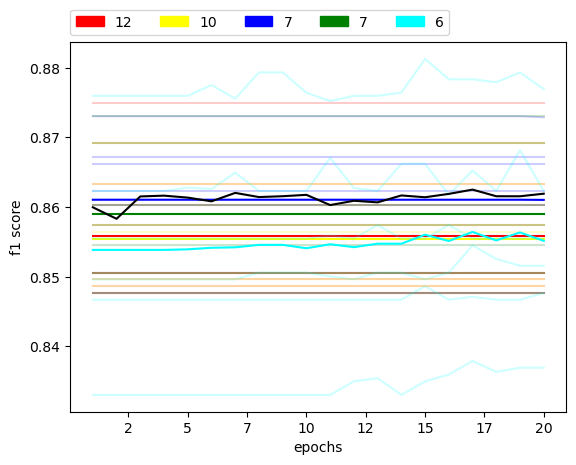

In [87]:
#plotting graphs for loss and accuracies:
#plotting val_loss and loss for the models generated and the benchmark model.
from random import randint
import matplotlib.patches as mpatches
color = ['red', 'yellow','blue', 'green','cyan']
leg=[]
for i in range(len(color)):
    leg.append(mpatches.Patch(color=color[i], label=str(len(val_acc[i]))))
n = len(val_acc)
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(val_acc[i])):
        plt.plot(x_axis,val_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis, np.mean(val_acc[i], axis=0), color=color[i])
#plt.xlim(-0.5,20.5)
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.plot(x_axis, benchmark_val_acc, color='black')
plt.savefig("fig/Diabetes012_F1_Val_20Epochs.jpeg")

[0.5183961987495422, 0.8604918718338013, 0.8604757785797119, 0.8604676723480225, 0.8602649569511414, 0.8588327169418335, 0.8600947856903076, 0.8588842749595642, 0.8593875169754028, 0.8600151538848877, 0.8590508699417114, 0.8593996167182922, 0.8583014011383057, 0.8600746393203735, 0.8589239120483398, 0.860209584236145, 0.8598961234092712, 0.8625667691230774, 0.859709620475769, 0.8599515557289124]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5


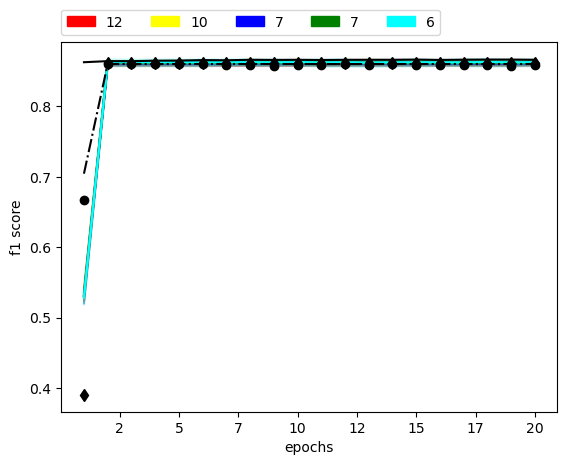

In [88]:
#train accuracy 
from random import randint
color = []
print(train_acc[4][0])
color = ['red', 'yellow','blue', 'green','cyan']
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(train_acc[i])):
        print(i,j)
        plt.plot(x_axis,train_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_acc[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_acc, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.plot(x_axis, DP_1_f1, 'o', color='black')
plt.plot(x_axis, DP_0_5_f1, '-.', color='black')
plt.plot(x_axis, DP_0_1_f1, 'd', color='black')
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Diabetes_012_F1_train_20Epochs.jpeg")

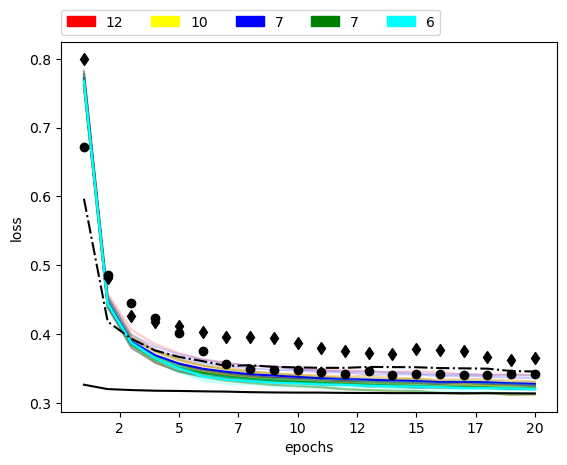

In [89]:
#training loss
from random import randint
color = []
n = len(train_loss)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,train_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(x_axis, DP_1_loss, 'o', color='black')
plt.plot(x_axis, DP_0_5_loss, '-.', color='black')
plt.plot(x_axis, DP_0_1_loss, 'd', color='black')
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Diabetes012_loss_train_20Epochs.jpeg")

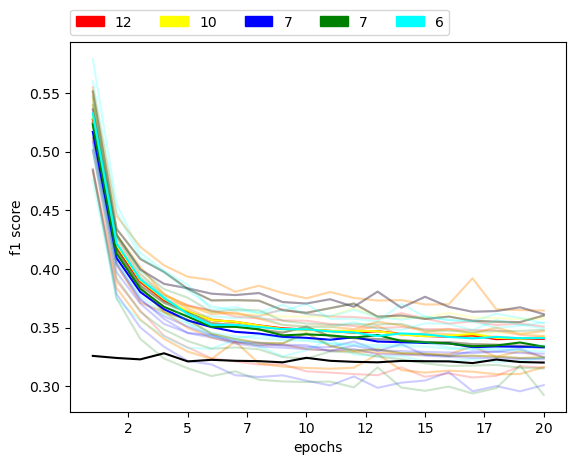

In [90]:
#validation loss loss
from random import randint
color = []
n = len(val_acc)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,val_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(val_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_val_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Diabetes_012_loss_val_20Epochs.jpeg")

In [92]:
#lets compute the accuracy for bigger test set 30% benchmark test data
high_test_loss=[]
high_test_f1=[]

high_weights=list(np.array(add_weights)[A])
print(high_weights[0][0])
for i in range(len(high_weights)):
    for j in range(len(high_weights[i])):
        high_test_model=get_initial_model(X_test.shape[1], 3) #same intial weights
        high_test_model.set_weights(high_weights[i][j])
        if j == 0:
            high_test_loss.append([high_test_model.evaluate(X_test,y_test)[0]])
            high_test_f1.append([high_test_model.evaluate(X_test,y_test)[1]])
        else:
            high_test_loss[i].append(high_test_model.evaluate(X_test,y_test)[0])
            high_test_f1[i].append(high_test_model.evaluate(X_test,y_test)[1])
print(high_test_loss, high_test_f1)

[array([[-0.08 , -0.27 , -0.14 , -0.25 ,  0.29 ],
       [-0.07 , -0.06 , -0.04 , -0.09 ,  0.2  ],
       [ 0.26 ,  0.2  , -0.06 ,  0.17 ,  0.18 ],
       [-0.19 , -0.17 , -0.4  , -0.22 ,  0.49 ],
       [ 0.01 ,  0.05 , -0.01 ,  0.04 ,  0.33 ],
       [ 0.03 , -0.06 ,  0.08 , -0.01 , -0.02 ],
       [-0.09 , -0.08 ,  0.02 , -0.23 ,  0.03 ],
       [ 0.09 ,  0.12 ,  0.1  ,  0.15 ,  0.33 ],
       [ 0.08 ,  0.05 , -0.03 ,  0.07 ,  0.28 ],
       [ 0.12 ,  0.17 ,  0.09 ,  0.2  ,  0.23 ],
       [ 0.2  ,  0.18 ,  0.31 ,  0.25 ,  0.12 ],
       [ 0.06 ,  0.08 ,  0.06 ,  0.22 ,  0.28 ],
       [ 0.12 ,  0.06 ,  0.11 ,  0.01 ,  0.01 ],
       [-0.22 , -0.28 , -0.24 , -0.28 ,  0.37 ],
       [ 0.13 ,  0.12 ,  0.14 ,  0.14 ,  0.19 ],
       [ 0.02 , -0.07 ,  0.005, -0.03 ,  0.08 ],
       [-0.02 , -0.09 ,  0.05 , -0.07 ,  0.03 ],
       [ 0.04 ,  0.02 , -0.09 ,  0.07 ,  0.2  ],
       [-0.003,  0.05 , -0.21 , -0.03 ,  0.27 ],
       [ 0.23 ,  0.25 ,  0.11 ,  0.18 ,  0.24 ],
       [ 0.22 ,  0.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


2379/2379 [==============================] - 1s 579us/step - loss: 0.3260 - accuracy: 0.8628
[[0.32874780893325806, 0.32620400190353394, 0.3281787633895874, 0.3297041654586792, 0.32984867691993713, 0.32626208662986755, 0.3285723030567169, 0.3286466598510742, 0.3262985050678253, 0.3379825949668884, 0.3286269009113312, 0.3312181830406189], [0.3289913535118103, 0.3281787633895874, 0.3293590545654297, 0.3297041654586792, 0.32984867691993713, 0.32626208662986755, 0.3286466598510742, 0.3262985050678253, 0.3286269009113312, 0.3312181830406189], [0.32665252685546875, 0.3264469802379608, 0.3297041654586792, 0.32984867691993713, 0.3285723030567169, 0.32755935192108154, 0.3286595642566681], [0.33070650696754456, 0.3297041654586792, 0.32984867691993713, 0.3285723030567169, 0.3262985050678253, 0.3278653621673584, 0.33053454756736755], [0.32952848076820374, 0.32760801911354065, 0.3257637321949005, 0.3249986171722412, 0.3270680010318756, 0.32601743936538696]] [[0.8627798557281494, 0.8627798557281494,

In [94]:
high_test_accs=list(np.array(high_test_f1))
print(high_test_accs)

[[0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494], [0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494], [0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494], [0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494, 0.8627798557281494], [0.8635157346725464, 0.8634499907493591, 0.8631083965301514, 0.8638573288917542, 0.8641726970672607, 0.8628193140029907]]


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


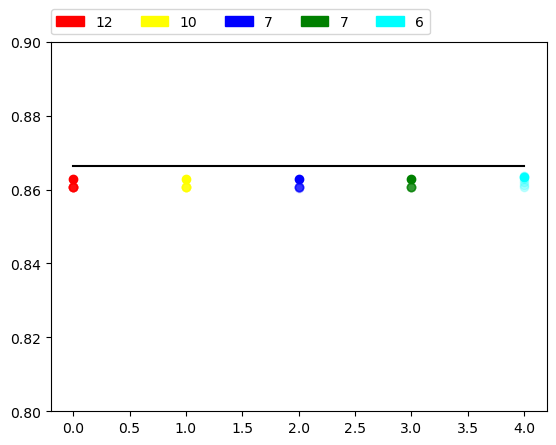

In [95]:
#for test accuracy plot
#plot test accuracy of smaller test set
benchmark_test_accs=[benchmark_test_accuracy]*n
ax = plt.gca()
ax.set_ylim([0.80, 0.90])
for i in range(n):
    plt.scatter([i]*len(test_acc[i]),test_acc[i], color=color[i], alpha=0.2)
    plt.scatter(i,high_test_accs[i][0], color=color[i])
plt.plot(benchmark_test_accs, color='black')
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Diabetes012_test_acc_20Epochs_1000.jpeg")
plt.show()

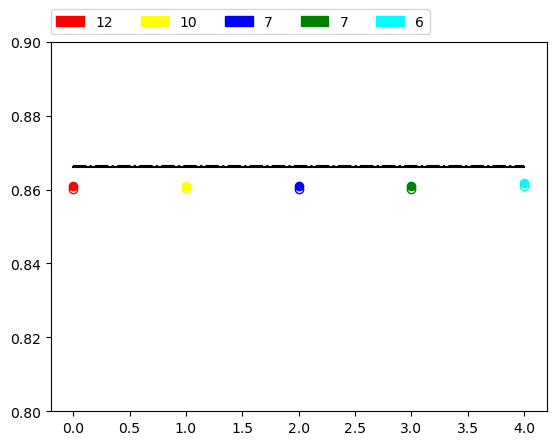

In [96]:
#plot for mean model accuracy and benchmark loss:
n=5
ax = plt.gca()
ax.set_ylim([0.80, 0.90])
for i in range(n):
    plt.plot(i, mean_model_acc[i],'o',color=color[i])
    plt.plot(i, mean_model_test_acc[i],'o', mfc='none',color=color[i])
plt.plot([benchmark_acc[-1]]*n,color='black')
plt.plot([benchmark_test_accuracy]*n,'-.',color='black')
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Diabetes_012_mean_model_results.jpeg")
plt.show()

In [21]:
#From here on the work is towards the interesting observations.
#for Diabetes 0-1-2 dataset
dataset = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv",sep=',')
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()

dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
target_variable="Diabetes_012"

labels=[0.0,0.5,1.0]
data=[]
len_clas=[]
N=5000
for i in range(len(labels)):
    data.append(dataset[dataset[target_variable]==labels[i]])
    print(len(data[i]))
    len_clas.append(int((data[i].shape[0]/dataset.shape[0])*N))
print(len_clas)

213703
4631
35346
[4212, 91, 696]


In [22]:
from sklearn.model_selection import train_test_split
y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
#defining test set
N=1000
initial_model=get_initial_model(dataset.shape[1]-1, 3)
train_acc=[]
test_acc=[]
while(N<=len(dataset)):
    for i in range(len(labels)):
        data.append(dataset[dataset[target_variable]==labels[i]])
        print(len(data[i]))
        len_clas.append(int((data[i].shape[0]/dataset.shape[0])*N))
    print(len_clas)
    for i in range(len(data)):
        if i==0:
            df=data[i].sample(min(len(data[i]), len_clas[i]))
        else:
            df1=data[i].sample(min(len(data[i]), len_clas[i]))
            df=df.append(df1, ignore_index = True)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    X=df.drop(columns=[target_variable])
    #print(X.shape)
    y=df[target_variable]
    y_data=to_categorical(y, num_classes=3)
    y=y_data
    int_model=get_initial_model(dataset.shape[1]-1, 3)
    int_model.set_weights(initial_model.get_weights())
    int_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])
    history = int_model.fit(X, y, epochs=20, validation_split=0.2, verbose=1)
    pred_train=int_model.evaluate(X_train, y_train)
    train_acc.append(pred_train[1])
    pred_test=int_model.evaluate(X_test, y_test)
    test_acc.append(pred_test[1])
    N=N*2
print(train_acc)
print(test_acc)

213703
4631
35346
[4212, 91, 696, 842, 18, 139]
Train on 4798 samples, validate on 1200 samples
Epoch 1/20
4798/4798 [==============================] - 1s 143us/sample - loss: 0.6735 - f1_m: 0.6226 - val_loss: 0.4807 - val_f1_m: 0.8577
Epoch 2/20
4798/4798 [==============================] - 0s 53us/sample - loss: 0.4319 - f1_m: 0.8612 - val_loss: 0.4020 - val_f1_m: 0.8594
Epoch 3/20
4798/4798 [==============================] - 0s 52us/sample - loss: 0.3709 - f1_m: 0.8609 - val_loss: 0.3709 - val_f1_m: 0.8512
Epoch 4/20
4798/4798 [==============================] - 0s 52us/sample - loss: 0.3490 - f1_m: 0.8639 - val_loss: 0.3625 - val_f1_m: 0.8567
Epoch 5/20
4798/4798 [==============================] - 0s 52us/sample - loss: 0.3411 - f1_m: 0.8644 - val_loss: 0.3556 - val_f1_m: 0.8555
Epoch 6/20
4798/4798 [==============================] - 0s 52us/sample - loss: 0.3351 - f1_m: 0.8653 - val_loss: 0.3564 - val_f1_m: 0.8573
Epoch 7/20
4798/4798 [==============================] - 0s 52us/sampl

9596/9596 [==============================] - 1s 89us/sample - loss: 0.3237 - f1_m: 0.8670 - val_loss: 0.3460 - val_f1_m: 0.8505
Epoch 7/20
9596/9596 [==============================] - 1s 94us/sample - loss: 0.3228 - f1_m: 0.8673 - val_loss: 0.3488 - val_f1_m: 0.8520
Epoch 8/20
9596/9596 [==============================] - 1s 129us/sample - loss: 0.3209 - f1_m: 0.8674 - val_loss: 0.3430 - val_f1_m: 0.8513
Epoch 9/20
9596/9596 [==============================] - 1s 125us/sample - loss: 0.3215 - f1_m: 0.8663 - val_loss: 0.3409 - val_f1_m: 0.8537
Epoch 10/20
9596/9596 [==============================] - 1s 124us/sample - loss: 0.3190 - f1_m: 0.8663 - val_loss: 0.3443 - val_f1_m: 0.8528
Epoch 11/20
9596/9596 [==============================] - 1s 124us/sample - loss: 0.3176 - f1_m: 0.8675 - val_loss: 0.3454 - val_f1_m: 0.8533
Epoch 12/20
9596/9596 [==============================] - 1s 119us/sample - loss: 0.3158 - f1_m: 0.8681 - val_loss: 0.3407 - val_f1_m: 0.8555
Epoch 13/20
9596/9596 [=======

Epoch 12/20
28794/28794 [==============================] - 1s 49us/sample - loss: 0.3185 - f1_m: 0.8632 - val_loss: 0.3220 - val_f1_m: 0.8600
Epoch 13/20
28794/28794 [==============================] - 1s 49us/sample - loss: 0.3187 - f1_m: 0.8642 - val_loss: 0.3212 - val_f1_m: 0.8600
Epoch 14/20
28794/28794 [==============================] - 1s 49us/sample - loss: 0.3186 - f1_m: 0.8641 - val_loss: 0.3220 - val_f1_m: 0.8583
Epoch 15/20
28794/28794 [==============================] - 1s 50us/sample - loss: 0.3182 - f1_m: 0.8647 - val_loss: 0.3201 - val_f1_m: 0.8600
Epoch 16/20
28794/28794 [==============================] - 1s 49us/sample - loss: 0.3179 - f1_m: 0.8644 - val_loss: 0.3244 - val_f1_m: 0.8608
Epoch 17/20
28794/28794 [==============================] - 1s 49us/sample - loss: 0.3180 - f1_m: 0.8644 - val_loss: 0.3206 - val_f1_m: 0.8603
Epoch 18/20
28794/28794 [==============================] - 1s 49us/sample - loss: 0.3175 - f1_m: 0.8647 - val_loss: 0.3235 - val_f1_m: 0.8608
Epoch 

Epoch 17/20
105592/105592 [==============================] - 7s 67us/sample - loss: 0.3139 - f1_m: 0.8656 - val_loss: 0.3145 - val_f1_m: 0.8661
Epoch 18/20
105592/105592 [==============================] - 8s 71us/sample - loss: 0.3139 - f1_m: 0.8660 - val_loss: 0.3135 - val_f1_m: 0.8667
Epoch 19/20
105592/105592 [==============================] - 7s 70us/sample - loss: 0.3139 - f1_m: 0.8660 - val_loss: 0.3131 - val_f1_m: 0.8668
Epoch 20/20
76104/76104 [==============================] - 2s 24us/sample - loss: 0.3126 - f1_m: 0.8670
213703
4631
35346
[4212, 91, 696, 842, 18, 139, 1684, 36, 278, 3369, 73, 557, 6739, 146, 1114, 13478, 292, 2229, 26957, 584, 4458, 53914, 1168, 8917, 107828, 2336, 17834]
Train on 207991 samples, validate on 51998 samples
Epoch 1/20
207991/207991 [==============================] - 23s 110us/sample - loss: 0.3382 - f1_m: 0.8567 - val_loss: 0.3159 - val_f1_m: 0.8660
Epoch 2/20
207991/207991 [==============================] - 11s 53us/sample - loss: 0.3195 - f1_m

[0.8615203, 0.863526, 0.8639789, 0.8631047, 0.86469585, 0.8648085, 0.8661542, 0.8661767]
[0.86110973, 0.8635975, 0.8642572, 0.8628679, 0.865805, 0.8658574, 0.8670396, 0.8670922]


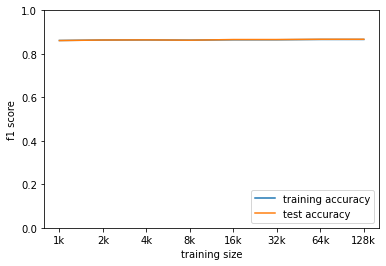

In [25]:
print(train_acc)
print(test_acc)
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel("training size")
plt.ylabel("f1 score")
plt.legend(["training accuracy", "test accuracy"], loc ="lower right")
plt.xticks([0,1,2,3,4,5,6,7],["1k","2k","4k","8k","16k","32k", "64k","128k"])
plt.savefig("fig/diabetes_interesting_results.jpeg")
plt.show()

In [ ]:
#no need for further it works for multi-class

In [ ]:
#here trying for diabeter binary:
dataset = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv",sep=',')
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
target_variable="Diabetes_binary"
#print(dataset.head)
Positive=pd.DataFrame(dataset[dataset[target_variable]==0.0], columns=dataset.columns)
Negative=pd.DataFrame(dataset[dataset[target_variable]==1.0], columns=dataset.columns)
print(len(Positive))
print(len(Negative))

In [ ]:
#the below code is for binary classification since MNSIT is a multi-class low-resolution image dataset. I am updating the code in the next cell.
N=2000
#Positive=Pos
#Negative=Neg
positiveN=int((Positive.shape[0]/dataset.shape[0])*N)
negativeN=int(N-positiveN)
print(positiveN, negativeN)
#target variable
#target_variable="default.payment.next.month"
df1=Positive.sample(positiveN)
Positive.drop(df1.index, inplace=True)
df2=Negative.sample(negativeN)
Negative.drop(df2.index, inplace=True)
test_data=df1.append(df2, ignore_index=True)
test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
test_data=test_data.sample(frac = 1)
test_data=test_data.sample(frac = 1)
X_test=test_data.drop(columns=[target_variable])
y_test=to_categorical(test_data[target_variable])

# adding dense layer
initial_model= get_initial_model(X_test.shape[1], 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
while Positive.empty==False and Negative.empty==False:
  print(positiveN, negativeN)
  df1=Positive.sample(min(positiveN, len(Positive)))
  Positive.drop(df1.index, inplace=True)
  df2=Negative.sample(min(negativeN, len(Negative)))
  Negative.drop(df2.index, inplace=True)
  train_data=df1.append(df2, ignore_index=True)
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
    
  #all models have different initialization
  # define the sequential model
  """initial_model = keras.Sequential()

    # adding dense layer
  initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  initial_model.add(Dense(10, activation='relu'))
  initial_model.add(Dense(5, activation='relu'))

    # adding dense layer with softmax activation/output layer
  initial_model.add(Dense(2, activation='softmax'))
  #initial_model.summary()"""
  ann_model=get_initial_model(X_test.shape[1], 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
  y_train=to_categorical(train_data[target_variable])
  #print(y_train)
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
  print(history.history['f1_m'][-1])
  ann_model.set_weights(update_weights(ann_model.get_weights()))
  pred_test=ann_model.predict(X_test)
  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      val_acc[i].append(history.history['val_f1_m'])
      train_acc[i].append(history.history['f1_m'])
      test_acc.append(f1_m(y_test, pred_test))
      val_loss[i].append(history.history['val_loss'])
      train_loss[i].append(history.history['loss'])
      present=True
  if present==False:
    Models.append([ann_model.get_weights(), 1])
    val_acc.append([history.history['val_f1_m']])
    train_acc.append([history.history['f1_m']])
    test_acc.append([f1_m(y_test, pred_test)])
    val_loss.append([history.history['val_loss']])
    train_loss.append([history.history['loss']])
for i in range(len(Models)):
  print(Models[i][1])
print("All Done")

In [ ]:
for i in range(len(Models)):
  print(Models[i][1])
print(len(Models))

In [ ]:
#for 5050 split diabetes dataset
dataset = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv",sep=',')
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
target_variable="Diabetes_binary"
#print(dataset.head)
Positive=pd.DataFrame(dataset[dataset[target_variable]==0.0], columns=dataset.columns)
Negative=pd.DataFrame(dataset[dataset[target_variable]==1.0], columns=dataset.columns)
print(len(Positive))
print(len(Negative))

In [ ]:
#the below code is for binary classification since MNSIT is a multi-class low-resolution image dataset. I am updating the code in the next cell.
N=3000
#Positive=Pos
#Negative=Neg
positiveN=int((Positive.shape[0]/dataset.shape[0])*N)
negativeN=int(N-positiveN)
print(positiveN, negativeN)
#target variable
#target_variable="default.payment.next.month"
df1=Positive.sample(positiveN)
Positive.drop(df1.index, inplace=True)
df2=Negative.sample(negativeN)
Negative.drop(df2.index, inplace=True)
test_data=df1.append(df2, ignore_index=True)
test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
test_data=test_data.sample(frac = 1)
test_data=test_data.sample(frac = 1)
X_test=test_data.drop(columns=[target_variable])
y_test=to_categorical(test_data[target_variable])

# adding dense layer
initial_model= get_initial_model(X_test.shape[1], 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
while Positive.empty==False and Negative.empty==False:
  print(positiveN, negativeN)
  df1=Positive.sample(min(positiveN, len(Positive)))
  Positive.drop(df1.index, inplace=True)
  df2=Negative.sample(min(negativeN, len(Negative)))
  Negative.drop(df2.index, inplace=True)
  train_data=df1.append(df2, ignore_index=True)
  train_data=train_data.sample(frac = 1) #shuffel train data 3 times
  train_data=train_data.sample(frac = 1) #shuffel train data 3 times
  train_data=train_data.sample(frac = 1) #shuffel train data 3 times
    
  #all models have different initialization
  # define the sequential model
  """initial_model = keras.Sequential()

    # adding dense layer
  initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  initial_model.add(Dense(10, activation='relu'))
  initial_model.add(Dense(5, activation='relu'))

    # adding dense layer with softmax activation/output layer
  initial_model.add(Dense(2, activation='softmax'))
  #initial_model.summary()"""
  ann_model=get_initial_model(X_test.shape[1], 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
  y_train=to_categorical(train_data[target_variable])
  #print(y_train)
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
  print(history.history['f1_m'][-1])
  ann_model.set_weights(update_weights(ann_model.get_weights()))
  pred_test=ann_model.predict(X_test)
  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      val_acc[i].append(history.history['val_f1_m'])
      train_acc[i].append(history.history['f1_m'])
      test_acc.append(f1_m(y_test, pred_test))
      val_loss[i].append(history.history['val_loss'])
      train_loss[i].append(history.history['loss'])
      present=True
  if present==False:
    Models.append([ann_model.get_weights(), 1])
    val_acc.append([history.history['val_f1_m']])
    train_acc.append([history.history['f1_m']])
    test_acc.append([f1_m(y_test, pred_test)])
    val_loss.append([history.history['val_loss']])
    train_loss.append([history.history['loss']])
for i in range(len(Models)):
  print(Models[i][1])
print("All Done")

In [ ]:
for i in range(len(Models)):
  print(Models[i][1])
print(len(Models))

In [19]:
#for here onwards ANN-2
labels=[0.0,0.5,1.0]
data=[]
len_clas=[]
N=5000
for i in range(len(labels)):
    data.append(dataset[dataset[target_variable]==labels[i]])
    print(len(data[i]))
    len_clas.append(int((data[i].shape[0]/dataset.shape[0])*N))
print(len_clas)

213703
4631
35346
[4212, 91, 696]


In [20]:
#defining test set
for i in range(len(data)):
    if i==0:
        df=data[i].sample(min(len(data[i]), len_clas[i]))
        data[i].drop(df.index, inplace=True)
    else:
        df1=data[i].sample(min(len(data[i]), len_clas[i]))
        df=df.append(df1, ignore_index = True)
        data[i].drop(df1.index, inplace=True)
df=df.sample(frac=1)
df=df.sample(frac=1)
df=df.sample(frac=1)
X_test=df.drop(columns=[target_variable])
y_test=to_categorical(df[target_variable], num_classes=3)

Models=[]
initial_model=get_initial_model_2(dataset.shape[1]-1, 3)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
add_weights=[]
while data[0].empty==False:
    for i in range(len(data)):
        if i==0:
            df=data[i].sample(min(len(data[i]), len_clas[i]))
            data[i].drop(df.index, inplace=True)
        else:
            df1=data[i].sample(min(len(data[i]), len_clas[i]))
            df=df.append(df1, ignore_index = True)
            data[i].drop(df1.index, inplace=True)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    #print(df.columns)
    """X_data=(df.iloc[:,1:].values).astype('float32')
    X_data=scaler.fit_transform(X_data)
    X_data=X_data.reshape(X_data.shape[0], 28, 28, 1)
    X=X_data"""
    X=df.drop(columns=[target_variable])
    #print(X.shape)
    y=df[target_variable]
    y_data=to_categorical(y, num_classes=3)
    y=y_data
    #y.columns=y_data.columns
    #print(y.shape[0])
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    #batches = gen.flow(X_train, y_train, batch_size=32)
    #print(batches.n)
    #val_batches=gen.flow(X_val, y_val, batch_size=32)
    #print(val_batches.n)
    ann_model=get_initial_model_2(dataset.shape[1]-1, 3)
    ann_model.set_weights(initial_model.get_weights())
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])
    history = ann_model.fit(X, y, epochs=10, validation_split=0.2, verbose=1)
    #print(ann_model.get_weights())
    ann_model.set_weights(update_weights(ann_model.get_weights()))
    pred_test=ann_model.predict(X_test)
    present=False
    for i in range(len(Models)):
        if (check_models(Models[i][0], ann_model.get_weights())):
            print("if any")
            Models[i][1]=Models[i][1]+1
            add_weights[i].append(ann_model.get_weights())
            val_acc[i].append(history.history['val_f1_m'])
            train_acc[i].append(history.history['f1_m'])
            test_acc[i].append(f1_m(y_test, pred_test).numpy())
            val_loss[i].append(history.history['val_loss'])
            train_loss[i].append(history.history['loss'])
            present=True
    if present==False:
        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])
        val_acc.append([history.history['val_f1_m']])
        train_acc.append([history.history['f1_m']])
        test_acc.append([f1_m(y_test, pred_test).numpy()])
        val_loss.append([history.history['val_loss']])
        train_loss.append([history.history['loss']])
for i in range(len(Models)):
    print(Models[i][1])
print("All Done")


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
2022-11-28 13:34:19.221143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
125/125 [==============================] - 1s 2ms/step - loss: 0.3912 - f1_m: 0.8374 - val_loss: 0.3643 - val_f1_m: 0.8604
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3373 - f1_m: 0.8568 - val_loss: 0.3464 - val_f1_m: 0.8672
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3305 - f1_m: 0.8627 - val_loss: 0.3582 - val_f1_m: 0.8555
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3251 - f1_m: 0.8609 - val_loss: 0.3398 - val_f1_m: 0.8623
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3193 - f1_m: 0.8677 - val_loss: 0.3514 - val_f1_m: 0.8525
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3155 - f1_m: 0.8657 - val_loss: 0.3417 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3123 - f1_m: 0.8709 - val_loss: 0.3618 - val_f1_m: 0.8477
Epoch 8/10
125/125 [==============================] - 0s 1ms/s

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3825 - f1_m: 0.8393 - val_loss: 0.3523 - val_f1_m: 0.8486
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8603 - val_loss: 0.3446 - val_f1_m: 0.8490
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3272 - f1_m: 0.8636 - val_loss: 0.3428 - val_f1_m: 0.8516
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3260 - f1_m: 0.8639 - val_loss: 0.3379 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3206 - f1_m: 0.8606 - val_loss: 0.3446 - val_f1_m: 0.8432
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3185 - f1_m: 0.8640 - val_loss: 0.3362 - val_f1_m: 0.8584
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3171 - f1_m: 0.8633 - val_loss: 0.3642 - val_f1_m: 0.8203
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.3853 - f1_m: 0.8427 - val_loss: 0.3075 - val_f1_m: 0.8867
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3388 - f1_m: 0.8560 - val_loss: 0.3073 - val_f1_m: 0.8857
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3299 - f1_m: 0.8607 - val_loss: 0.3219 - val_f1_m: 0.8740
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3261 - f1_m: 0.8608 - val_loss: 0.2992 - val_f1_m: 0.8906
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3223 - f1_m: 0.8627 - val_loss: 0.2971 - val_f1_m: 0.8857
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3193 - f1_m: 0.8620 - val_loss: 0.3072 - val_f1_m: 0.8770
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3195 - f1_m: 0.8660 - val_loss: 0.2950 - val_f1_m: 0.8906
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.3807 - f1_m: 0.8408 - val_loss: 0.3383 - val_f1_m: 0.8643
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3339 - f1_m: 0.8681 - val_loss: 0.3346 - val_f1_m: 0.8594
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3313 - f1_m: 0.8622 - val_loss: 0.3349 - val_f1_m: 0.8594
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3258 - f1_m: 0.8627 - val_loss: 0.3495 - val_f1_m: 0.8613
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3244 - f1_m: 0.8639 - val_loss: 0.3314 - val_f1_m: 0.8633
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3175 - f1_m: 0.8682 - val_loss: 0.3532 - val_f1_m: 0.8594
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3142 - f1_m: 0.8690 - val_loss: 0.3300 - val_f1_m: 0.8652
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.3846 - f1_m: 0.8479 - val_loss: 0.3574 - val_f1_m: 0.8418
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3367 - f1_m: 0.8627 - val_loss: 0.3532 - val_f1_m: 0.8379
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3319 - f1_m: 0.8703 - val_loss: 0.3462 - val_f1_m: 0.8437
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3237 - f1_m: 0.8655 - val_loss: 0.3445 - val_f1_m: 0.8418
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3181 - f1_m: 0.8697 - val_loss: 0.3407 - val_f1_m: 0.8447
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3151 - f1_m: 0.8709 - val_loss: 0.3551 - val_f1_m: 0.8437
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3121 - f1_m: 0.8707 - val_loss: 0.3362 - val_f1_m: 0.8379
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3803 - f1_m: 0.8451 - val_loss: 0.3363 - val_f1_m: 0.8525
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3313 - f1_m: 0.8637 - val_loss: 0.3317 - val_f1_m: 0.8535
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3233 - f1_m: 0.8620 - val_loss: 0.3301 - val_f1_m: 0.8545
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3134 - f1_m: 0.8722 - val_loss: 0.3312 - val_f1_m: 0.8486
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3132 - f1_m: 0.8672 - val_loss: 0.3326 - val_f1_m: 0.8564
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3110 - f1_m: 0.8720 - val_loss: 0.3429 - val_f1_m: 0.8594
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3055 - f1_m: 0.8772 - val_loss: 0.3423 - val_f1_m: 0.8545
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3919 - f1_m: 0.8416 - val_loss: 0.3424 - val_f1_m: 0.8594
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3387 - f1_m: 0.8612 - val_loss: 0.3401 - val_f1_m: 0.8597
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3330 - f1_m: 0.8576 - val_loss: 0.3376 - val_f1_m: 0.8613
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3246 - f1_m: 0.8626 - val_loss: 0.3284 - val_f1_m: 0.8652
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3188 - f1_m: 0.8632 - val_loss: 0.3270 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3181 - f1_m: 0.8655 - val_loss: 0.3262 - val_f1_m: 0.8652
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3118 - f1_m: 0.8682 - val_loss: 0.3255 - val_f1_m: 0.8682
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3789 - f1_m: 0.8420 - val_loss: 0.3524 - val_f1_m: 0.8613
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3330 - f1_m: 0.8570 - val_loss: 0.3583 - val_f1_m: 0.8496
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3263 - f1_m: 0.8652 - val_loss: 0.3422 - val_f1_m: 0.8604
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3237 - f1_m: 0.8642 - val_loss: 0.3323 - val_f1_m: 0.8672
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3143 - f1_m: 0.8687 - val_loss: 0.3386 - val_f1_m: 0.8486
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3096 - f1_m: 0.8682 - val_loss: 0.3324 - val_f1_m: 0.8750
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3074 - f1_m: 0.8687 - val_loss: 0.3326 - val_f1_m: 0.8721
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.3884 - f1_m: 0.8443 - val_loss: 0.3386 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3313 - f1_m: 0.8578 - val_loss: 0.3467 - val_f1_m: 0.8431
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3248 - f1_m: 0.8580 - val_loss: 0.3291 - val_f1_m: 0.8535
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3183 - f1_m: 0.8652 - val_loss: 0.3517 - val_f1_m: 0.8330
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3171 - f1_m: 0.8642 - val_loss: 0.3234 - val_f1_m: 0.8516
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3063 - f1_m: 0.8656 - val_loss: 0.3285 - val_f1_m: 0.8574
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3027 - f1_m: 0.8720 - val_loss: 0.3318 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.3911 - f1_m: 0.8432 - val_loss: 0.3566 - val_f1_m: 0.8477
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3351 - f1_m: 0.8635 - val_loss: 0.3411 - val_f1_m: 0.8510
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3306 - f1_m: 0.8622 - val_loss: 0.3500 - val_f1_m: 0.8422
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3280 - f1_m: 0.8623 - val_loss: 0.3658 - val_f1_m: 0.8477
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3177 - f1_m: 0.8669 - val_loss: 0.3421 - val_f1_m: 0.8516
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3132 - f1_m: 0.8641 - val_loss: 0.3415 - val_f1_m: 0.8535
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3104 - f1_m: 0.8720 - val_loss: 0.3470 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3892 - f1_m: 0.8455 - val_loss: 0.3458 - val_f1_m: 0.8594
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3407 - f1_m: 0.8610 - val_loss: 0.3380 - val_f1_m: 0.8525
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3353 - f1_m: 0.8642 - val_loss: 0.3354 - val_f1_m: 0.8535
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3305 - f1_m: 0.8677 - val_loss: 0.3476 - val_f1_m: 0.8477
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3250 - f1_m: 0.8668 - val_loss: 0.3359 - val_f1_m: 0.8510
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3269 - f1_m: 0.8650 - val_loss: 0.3263 - val_f1_m: 0.8564
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3198 - f1_m: 0.8672 - val_loss: 0.3326 - val_f1_m: 0.8477
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3885 - f1_m: 0.8434 - val_loss: 0.3534 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3385 - f1_m: 0.8604 - val_loss: 0.3639 - val_f1_m: 0.8477
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3311 - f1_m: 0.8621 - val_loss: 0.3462 - val_f1_m: 0.8506
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3248 - f1_m: 0.8595 - val_loss: 0.3477 - val_f1_m: 0.8467
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3224 - f1_m: 0.8622 - val_loss: 0.3547 - val_f1_m: 0.8477
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3217 - f1_m: 0.8608 - val_loss: 0.3472 - val_f1_m: 0.8467
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3181 - f1_m: 0.8602 - val_loss: 0.3559 - val_f1_m: 0.8477
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.3866 - f1_m: 0.8402 - val_loss: 0.3161 - val_f1_m: 0.8701
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3434 - f1_m: 0.8577 - val_loss: 0.3135 - val_f1_m: 0.8643
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3402 - f1_m: 0.8595 - val_loss: 0.3094 - val_f1_m: 0.8682
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3289 - f1_m: 0.8619 - val_loss: 0.3107 - val_f1_m: 0.8652
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3286 - f1_m: 0.8572 - val_loss: 0.3113 - val_f1_m: 0.8662
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3222 - f1_m: 0.8582 - val_loss: 0.3141 - val_f1_m: 0.8691
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3175 - f1_m: 0.8633 - val_loss: 0.3106 - val_f1_m: 0.8647
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.3782 - f1_m: 0.8443 - val_loss: 0.3602 - val_f1_m: 0.8447
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3317 - f1_m: 0.8680 - val_loss: 0.3525 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3236 - f1_m: 0.8677 - val_loss: 0.3534 - val_f1_m: 0.8510
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3177 - f1_m: 0.8700 - val_loss: 0.3570 - val_f1_m: 0.8379
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3155 - f1_m: 0.8690 - val_loss: 0.3611 - val_f1_m: 0.8393
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3124 - f1_m: 0.8739 - val_loss: 0.3461 - val_f1_m: 0.8535
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3064 - f1_m: 0.8688 - val_loss: 0.3516 - val_f1_m: 0.8442
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3863 - f1_m: 0.8462 - val_loss: 0.3571 - val_f1_m: 0.8423
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3380 - f1_m: 0.8665 - val_loss: 0.3530 - val_f1_m: 0.8525
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3324 - f1_m: 0.8701 - val_loss: 0.3614 - val_f1_m: 0.8545
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3278 - f1_m: 0.8685 - val_loss: 0.3454 - val_f1_m: 0.8535
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3263 - f1_m: 0.8682 - val_loss: 0.3487 - val_f1_m: 0.8506
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3212 - f1_m: 0.8710 - val_loss: 0.3501 - val_f1_m: 0.8545
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3136 - f1_m: 0.8732 - val_loss: 0.3706 - val_f1_m: 0.8545
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3824 - f1_m: 0.8428 - val_loss: 0.3366 - val_f1_m: 0.8525
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3293 - f1_m: 0.8637 - val_loss: 0.3265 - val_f1_m: 0.8574
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3257 - f1_m: 0.8665 - val_loss: 0.3225 - val_f1_m: 0.8584
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3192 - f1_m: 0.8672 - val_loss: 0.3313 - val_f1_m: 0.8686
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3139 - f1_m: 0.8702 - val_loss: 0.3229 - val_f1_m: 0.8613
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3118 - f1_m: 0.8679 - val_loss: 0.3177 - val_f1_m: 0.8691
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3090 - f1_m: 0.8717 - val_loss: 0.3233 - val_f1_m: 0.8672
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3824 - f1_m: 0.8448 - val_loss: 0.3513 - val_f1_m: 0.8608
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3384 - f1_m: 0.8580 - val_loss: 0.3498 - val_f1_m: 0.8422
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3340 - f1_m: 0.8603 - val_loss: 0.3463 - val_f1_m: 0.8652
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3249 - f1_m: 0.8628 - val_loss: 0.3322 - val_f1_m: 0.8643
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3213 - f1_m: 0.8642 - val_loss: 0.3297 - val_f1_m: 0.8604
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3181 - f1_m: 0.8647 - val_loss: 0.3305 - val_f1_m: 0.8623
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3144 - f1_m: 0.8697 - val_loss: 0.3333 - val_f1_m: 0.8662
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3805 - f1_m: 0.8471 - val_loss: 0.3630 - val_f1_m: 0.8408
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3298 - f1_m: 0.8631 - val_loss: 0.3591 - val_f1_m: 0.8467
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3226 - f1_m: 0.8645 - val_loss: 0.3523 - val_f1_m: 0.8477
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3185 - f1_m: 0.8676 - val_loss: 0.3525 - val_f1_m: 0.8481
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3128 - f1_m: 0.8677 - val_loss: 0.3523 - val_f1_m: 0.8467
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3074 - f1_m: 0.8700 - val_loss: 0.3557 - val_f1_m: 0.8496
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3092 - f1_m: 0.8712 - val_loss: 0.3498 - val_f1_m: 0.8451
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3830 - f1_m: 0.8385 - val_loss: 0.3217 - val_f1_m: 0.8672
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3342 - f1_m: 0.8592 - val_loss: 0.3263 - val_f1_m: 0.8672
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3326 - f1_m: 0.8575 - val_loss: 0.3213 - val_f1_m: 0.8652
Epoch 4/10
125/125 [==============================] - 0s 972us/step - loss: 0.3225 - f1_m: 0.8645 - val_loss: 0.3185 - val_f1_m: 0.8633
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3207 - f1_m: 0.8635 - val_loss: 0.3220 - val_f1_m: 0.8643
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3172 - f1_m: 0.8645 - val_loss: 0.3284 - val_f1_m: 0.8555
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3126 - f1_m: 0.8687 - val_loss: 0.3212 - val_f1_m: 0.8633
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3954 - f1_m: 0.8402 - val_loss: 0.3564 - val_f1_m: 0.8475
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3440 - f1_m: 0.8542 - val_loss: 0.3299 - val_f1_m: 0.8643
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3354 - f1_m: 0.8642 - val_loss: 0.3374 - val_f1_m: 0.8564
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3334 - f1_m: 0.8610 - val_loss: 0.3248 - val_f1_m: 0.8740
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3276 - f1_m: 0.8643 - val_loss: 0.3250 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3207 - f1_m: 0.8672 - val_loss: 0.3242 - val_f1_m: 0.8623
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3177 - f1_m: 0.8703 - val_loss: 0.3244 - val_f1_m: 0.8545
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.3728 - f1_m: 0.8490 - val_loss: 0.3590 - val_f1_m: 0.8525
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3318 - f1_m: 0.8626 - val_loss: 0.3479 - val_f1_m: 0.8555
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3241 - f1_m: 0.8635 - val_loss: 0.3579 - val_f1_m: 0.8535
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3201 - f1_m: 0.8678 - val_loss: 0.3563 - val_f1_m: 0.8545
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3176 - f1_m: 0.8695 - val_loss: 0.3412 - val_f1_m: 0.8529
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3119 - f1_m: 0.8691 - val_loss: 0.3321 - val_f1_m: 0.8633
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3075 - f1_m: 0.8745 - val_loss: 0.3430 - val_f1_m: 0.8613
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3934 - f1_m: 0.8417 - val_loss: 0.3335 - val_f1_m: 0.8604
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3461 - f1_m: 0.8572 - val_loss: 0.3299 - val_f1_m: 0.8643
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3371 - f1_m: 0.8625 - val_loss: 0.3350 - val_f1_m: 0.8604
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3293 - f1_m: 0.8650 - val_loss: 0.3250 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3229 - f1_m: 0.8665 - val_loss: 0.3411 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3221 - f1_m: 0.8638 - val_loss: 0.3223 - val_f1_m: 0.8662
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3197 - f1_m: 0.8667 - val_loss: 0.3224 - val_f1_m: 0.8643
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3746 - f1_m: 0.8437 - val_loss: 0.3494 - val_f1_m: 0.8496
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3313 - f1_m: 0.8651 - val_loss: 0.3462 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3274 - f1_m: 0.8645 - val_loss: 0.3432 - val_f1_m: 0.8398
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3203 - f1_m: 0.8652 - val_loss: 0.3436 - val_f1_m: 0.8574
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3141 - f1_m: 0.8642 - val_loss: 0.3318 - val_f1_m: 0.8506
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3098 - f1_m: 0.8687 - val_loss: 0.3335 - val_f1_m: 0.8525
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3101 - f1_m: 0.8672 - val_loss: 0.3471 - val_f1_m: 0.8564
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3884 - f1_m: 0.8401 - val_loss: 0.3377 - val_f1_m: 0.8506
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3483 - f1_m: 0.8555 - val_loss: 0.3167 - val_f1_m: 0.8680
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3428 - f1_m: 0.8572 - val_loss: 0.3186 - val_f1_m: 0.8672
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3345 - f1_m: 0.8587 - val_loss: 0.3176 - val_f1_m: 0.8740
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3318 - f1_m: 0.8597 - val_loss: 0.3071 - val_f1_m: 0.8750
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3253 - f1_m: 0.8605 - val_loss: 0.3099 - val_f1_m: 0.8721
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3211 - f1_m: 0.8605 - val_loss: 0.3077 - val_f1_m: 0.8740
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3895 - f1_m: 0.8436 - val_loss: 0.3268 - val_f1_m: 0.8691
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3442 - f1_m: 0.8612 - val_loss: 0.3187 - val_f1_m: 0.8662
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8612 - val_loss: 0.3421 - val_f1_m: 0.8486
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3344 - f1_m: 0.8639 - val_loss: 0.3535 - val_f1_m: 0.8437
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3283 - f1_m: 0.8647 - val_loss: 0.3232 - val_f1_m: 0.8672
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3223 - f1_m: 0.8647 - val_loss: 0.3143 - val_f1_m: 0.8691
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3237 - f1_m: 0.8687 - val_loss: 0.3126 - val_f1_m: 0.8701
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3813 - f1_m: 0.8462 - val_loss: 0.3819 - val_f1_m: 0.8389
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3277 - f1_m: 0.8663 - val_loss: 0.3552 - val_f1_m: 0.8437
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3236 - f1_m: 0.8666 - val_loss: 0.3643 - val_f1_m: 0.8369
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3217 - f1_m: 0.8640 - val_loss: 0.3661 - val_f1_m: 0.8379
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3139 - f1_m: 0.8680 - val_loss: 0.3601 - val_f1_m: 0.8389
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3129 - f1_m: 0.8677 - val_loss: 0.3484 - val_f1_m: 0.8408
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3076 - f1_m: 0.8692 - val_loss: 0.3484 - val_f1_m: 0.8350
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3859 - f1_m: 0.8470 - val_loss: 0.3662 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3386 - f1_m: 0.8647 - val_loss: 0.3584 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3319 - f1_m: 0.8688 - val_loss: 0.3434 - val_f1_m: 0.8506
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3281 - f1_m: 0.8679 - val_loss: 0.3434 - val_f1_m: 0.8506
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3235 - f1_m: 0.8695 - val_loss: 0.3437 - val_f1_m: 0.8496
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3185 - f1_m: 0.8690 - val_loss: 0.3424 - val_f1_m: 0.8506
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3173 - f1_m: 0.8705 - val_loss: 0.3331 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3941 - f1_m: 0.8402 - val_loss: 0.3447 - val_f1_m: 0.8604
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3496 - f1_m: 0.8600 - val_loss: 0.3281 - val_f1_m: 0.8604
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3402 - f1_m: 0.8625 - val_loss: 0.3219 - val_f1_m: 0.8564
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3398 - f1_m: 0.8616 - val_loss: 0.3207 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3345 - f1_m: 0.8635 - val_loss: 0.3187 - val_f1_m: 0.8613
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3315 - f1_m: 0.8617 - val_loss: 0.3182 - val_f1_m: 0.8564
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3272 - f1_m: 0.8637 - val_loss: 0.3160 - val_f1_m: 0.8564
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3842 - f1_m: 0.8447 - val_loss: 0.3465 - val_f1_m: 0.8584
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3357 - f1_m: 0.8642 - val_loss: 0.3572 - val_f1_m: 0.8545
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3280 - f1_m: 0.8617 - val_loss: 0.3461 - val_f1_m: 0.8545
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3225 - f1_m: 0.8647 - val_loss: 0.3348 - val_f1_m: 0.8506
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3170 - f1_m: 0.8670 - val_loss: 0.3371 - val_f1_m: 0.8545
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3121 - f1_m: 0.8686 - val_loss: 0.3315 - val_f1_m: 0.8555
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3092 - f1_m: 0.8682 - val_loss: 0.3330 - val_f1_m: 0.8607
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3897 - f1_m: 0.8457 - val_loss: 0.3548 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3440 - f1_m: 0.8582 - val_loss: 0.3860 - val_f1_m: 0.8477
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3396 - f1_m: 0.8621 - val_loss: 0.3407 - val_f1_m: 0.8506
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3329 - f1_m: 0.8626 - val_loss: 0.3366 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3259 - f1_m: 0.8675 - val_loss: 0.3327 - val_f1_m: 0.8516
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3254 - f1_m: 0.8670 - val_loss: 0.3394 - val_f1_m: 0.8457
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3186 - f1_m: 0.8645 - val_loss: 0.3512 - val_f1_m: 0.8506
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.3916 - f1_m: 0.8434 - val_loss: 0.3399 - val_f1_m: 0.8496
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3436 - f1_m: 0.8613 - val_loss: 0.3295 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3394 - f1_m: 0.8620 - val_loss: 0.3318 - val_f1_m: 0.8545
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3361 - f1_m: 0.8651 - val_loss: 0.3293 - val_f1_m: 0.8574
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3291 - f1_m: 0.8668 - val_loss: 0.3236 - val_f1_m: 0.8545
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3239 - f1_m: 0.8662 - val_loss: 0.3297 - val_f1_m: 0.8545
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3223 - f1_m: 0.8657 - val_loss: 0.3327 - val_f1_m: 0.8535
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3841 - f1_m: 0.8450 - val_loss: 0.3733 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3404 - f1_m: 0.8590 - val_loss: 0.3530 - val_f1_m: 0.8418
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3340 - f1_m: 0.8625 - val_loss: 0.3578 - val_f1_m: 0.8491
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3301 - f1_m: 0.8657 - val_loss: 0.3472 - val_f1_m: 0.8467
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3232 - f1_m: 0.8603 - val_loss: 0.3639 - val_f1_m: 0.8477
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3178 - f1_m: 0.8642 - val_loss: 0.3444 - val_f1_m: 0.8428
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3142 - f1_m: 0.8684 - val_loss: 0.3457 - val_f1_m: 0.8437
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3840 - f1_m: 0.8361 - val_loss: 0.3102 - val_f1_m: 0.8760
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3349 - f1_m: 0.8592 - val_loss: 0.3051 - val_f1_m: 0.8809
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3320 - f1_m: 0.8578 - val_loss: 0.3035 - val_f1_m: 0.8848
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3300 - f1_m: 0.8590 - val_loss: 0.2991 - val_f1_m: 0.8799
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3207 - f1_m: 0.8622 - val_loss: 0.2994 - val_f1_m: 0.8818
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3167 - f1_m: 0.8646 - val_loss: 0.3236 - val_f1_m: 0.8604
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3149 - f1_m: 0.8642 - val_loss: 0.3048 - val_f1_m: 0.8721
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3906 - f1_m: 0.8366 - val_loss: 0.3277 - val_f1_m: 0.8682
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3456 - f1_m: 0.8572 - val_loss: 0.3157 - val_f1_m: 0.8783
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3384 - f1_m: 0.8580 - val_loss: 0.3156 - val_f1_m: 0.8779
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3294 - f1_m: 0.8607 - val_loss: 0.3281 - val_f1_m: 0.8838
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3286 - f1_m: 0.8646 - val_loss: 0.3116 - val_f1_m: 0.8799
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3215 - f1_m: 0.8647 - val_loss: 0.3145 - val_f1_m: 0.8823
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3163 - f1_m: 0.8630 - val_loss: 0.3158 - val_f1_m: 0.8789
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3916 - f1_m: 0.8417 - val_loss: 0.3574 - val_f1_m: 0.8437
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3440 - f1_m: 0.8600 - val_loss: 0.3535 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8589 - val_loss: 0.3382 - val_f1_m: 0.8496
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3324 - f1_m: 0.8608 - val_loss: 0.3433 - val_f1_m: 0.8574
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3236 - f1_m: 0.8642 - val_loss: 0.3434 - val_f1_m: 0.8516
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3255 - f1_m: 0.8647 - val_loss: 0.3374 - val_f1_m: 0.8486
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3224 - f1_m: 0.8643 - val_loss: 0.3351 - val_f1_m: 0.8491
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3922 - f1_m: 0.8387 - val_loss: 0.3254 - val_f1_m: 0.8774
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3473 - f1_m: 0.8552 - val_loss: 0.3221 - val_f1_m: 0.8789
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3407 - f1_m: 0.8555 - val_loss: 0.3138 - val_f1_m: 0.8799
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3380 - f1_m: 0.8587 - val_loss: 0.2914 - val_f1_m: 0.8828
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3300 - f1_m: 0.8610 - val_loss: 0.2908 - val_f1_m: 0.8789
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3264 - f1_m: 0.8605 - val_loss: 0.2906 - val_f1_m: 0.8848
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3213 - f1_m: 0.8626 - val_loss: 0.2981 - val_f1_m: 0.8799
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3923 - f1_m: 0.8412 - val_loss: 0.3294 - val_f1_m: 0.8672
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3484 - f1_m: 0.8585 - val_loss: 0.3543 - val_f1_m: 0.8529
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3400 - f1_m: 0.8587 - val_loss: 0.3254 - val_f1_m: 0.8662
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3355 - f1_m: 0.8605 - val_loss: 0.3331 - val_f1_m: 0.8613
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3315 - f1_m: 0.8629 - val_loss: 0.3249 - val_f1_m: 0.8711
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3296 - f1_m: 0.8617 - val_loss: 0.3224 - val_f1_m: 0.8672
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3238 - f1_m: 0.8657 - val_loss: 0.3321 - val_f1_m: 0.8676
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3817 - f1_m: 0.8476 - val_loss: 0.3643 - val_f1_m: 0.8701
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3379 - f1_m: 0.8662 - val_loss: 0.3459 - val_f1_m: 0.8604
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3299 - f1_m: 0.8660 - val_loss: 0.3576 - val_f1_m: 0.8490
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3225 - f1_m: 0.8703 - val_loss: 0.3410 - val_f1_m: 0.8643
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3192 - f1_m: 0.8695 - val_loss: 0.4063 - val_f1_m: 0.8701
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3175 - f1_m: 0.8692 - val_loss: 0.3499 - val_f1_m: 0.8623
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3128 - f1_m: 0.8732 - val_loss: 0.3443 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3845 - f1_m: 0.8394 - val_loss: 0.3549 - val_f1_m: 0.8467
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3418 - f1_m: 0.8617 - val_loss: 0.3339 - val_f1_m: 0.8617
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3337 - f1_m: 0.8622 - val_loss: 0.3314 - val_f1_m: 0.8672
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3301 - f1_m: 0.8625 - val_loss: 0.3316 - val_f1_m: 0.8613
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3258 - f1_m: 0.8607 - val_loss: 0.3308 - val_f1_m: 0.8643
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3230 - f1_m: 0.8632 - val_loss: 0.3227 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3196 - f1_m: 0.8667 - val_loss: 0.3259 - val_f1_m: 0.8604
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3932 - f1_m: 0.8416 - val_loss: 0.3459 - val_f1_m: 0.8670
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3397 - f1_m: 0.8597 - val_loss: 0.3447 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3337 - f1_m: 0.8547 - val_loss: 0.3328 - val_f1_m: 0.8691
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3291 - f1_m: 0.8589 - val_loss: 0.3358 - val_f1_m: 0.8643
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3280 - f1_m: 0.8627 - val_loss: 0.3344 - val_f1_m: 0.8711
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3210 - f1_m: 0.8615 - val_loss: 0.3295 - val_f1_m: 0.8730
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3179 - f1_m: 0.8663 - val_loss: 0.3419 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3886 - f1_m: 0.8425 - val_loss: 0.3664 - val_f1_m: 0.8574
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3402 - f1_m: 0.8621 - val_loss: 0.3771 - val_f1_m: 0.8535
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3370 - f1_m: 0.8654 - val_loss: 0.3630 - val_f1_m: 0.8594
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3265 - f1_m: 0.8641 - val_loss: 0.3591 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3214 - f1_m: 0.8672 - val_loss: 0.3578 - val_f1_m: 0.8564
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3180 - f1_m: 0.8687 - val_loss: 0.3757 - val_f1_m: 0.8584
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3161 - f1_m: 0.8703 - val_loss: 0.3600 - val_f1_m: 0.8555
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3852 - f1_m: 0.8400 - val_loss: 0.3283 - val_f1_m: 0.8770
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3484 - f1_m: 0.8517 - val_loss: 0.3205 - val_f1_m: 0.8760
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3410 - f1_m: 0.8581 - val_loss: 0.3185 - val_f1_m: 0.8789
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3325 - f1_m: 0.8607 - val_loss: 0.3168 - val_f1_m: 0.8779
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3300 - f1_m: 0.8607 - val_loss: 0.3167 - val_f1_m: 0.8754
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3262 - f1_m: 0.8624 - val_loss: 0.3404 - val_f1_m: 0.8467
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3272 - f1_m: 0.8624 - val_loss: 0.3208 - val_f1_m: 0.8721
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3877 - f1_m: 0.8391 - val_loss: 0.3191 - val_f1_m: 0.8676
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3368 - f1_m: 0.8577 - val_loss: 0.3227 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3319 - f1_m: 0.8598 - val_loss: 0.3096 - val_f1_m: 0.8711
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3285 - f1_m: 0.8592 - val_loss: 0.3215 - val_f1_m: 0.8682
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3205 - f1_m: 0.8642 - val_loss: 0.3097 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3190 - f1_m: 0.8647 - val_loss: 0.3132 - val_f1_m: 0.8584
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3143 - f1_m: 0.8660 - val_loss: 0.3071 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3913 - f1_m: 0.8390 - val_loss: 0.3298 - val_f1_m: 0.8721
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3400 - f1_m: 0.8565 - val_loss: 0.3216 - val_f1_m: 0.8750
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3316 - f1_m: 0.8590 - val_loss: 0.3030 - val_f1_m: 0.8750
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3254 - f1_m: 0.8603 - val_loss: 0.3032 - val_f1_m: 0.8701
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3175 - f1_m: 0.8635 - val_loss: 0.2971 - val_f1_m: 0.8730
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3183 - f1_m: 0.8645 - val_loss: 0.3271 - val_f1_m: 0.8721
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3123 - f1_m: 0.8660 - val_loss: 0.2951 - val_f1_m: 0.8740
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3828 - f1_m: 0.8436 - val_loss: 0.3360 - val_f1_m: 0.8584
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3437 - f1_m: 0.8608 - val_loss: 0.3195 - val_f1_m: 0.8652
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3336 - f1_m: 0.8623 - val_loss: 0.3211 - val_f1_m: 0.8750
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3335 - f1_m: 0.8632 - val_loss: 0.3155 - val_f1_m: 0.8740
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3304 - f1_m: 0.8630 - val_loss: 0.3207 - val_f1_m: 0.8691
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3217 - f1_m: 0.8668 - val_loss: 0.3111 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3180 - f1_m: 0.8642 - val_loss: 0.3209 - val_f1_m: 0.8740
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3917 - f1_m: 0.8448 - val_loss: 0.3609 - val_f1_m: 0.8535
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3443 - f1_m: 0.8596 - val_loss: 0.3548 - val_f1_m: 0.8457
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3335 - f1_m: 0.8638 - val_loss: 0.3518 - val_f1_m: 0.8535
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3314 - f1_m: 0.8637 - val_loss: 0.3517 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3284 - f1_m: 0.8636 - val_loss: 0.3550 - val_f1_m: 0.8428
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3221 - f1_m: 0.8703 - val_loss: 0.3474 - val_f1_m: 0.8457
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3187 - f1_m: 0.8670 - val_loss: 0.3560 - val_f1_m: 0.8555
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3842 - f1_m: 0.8463 - val_loss: 0.3450 - val_f1_m: 0.8574
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3352 - f1_m: 0.8617 - val_loss: 0.3427 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3280 - f1_m: 0.8650 - val_loss: 0.3454 - val_f1_m: 0.8457
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3196 - f1_m: 0.8660 - val_loss: 0.3353 - val_f1_m: 0.8672
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3157 - f1_m: 0.8668 - val_loss: 0.3660 - val_f1_m: 0.8271
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3120 - f1_m: 0.8670 - val_loss: 0.3367 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3069 - f1_m: 0.8680 - val_loss: 0.3405 - val_f1_m: 0.8604
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3895 - f1_m: 0.8388 - val_loss: 0.3588 - val_f1_m: 0.8604
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3393 - f1_m: 0.8600 - val_loss: 0.3544 - val_f1_m: 0.8525
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3355 - f1_m: 0.8602 - val_loss: 0.3583 - val_f1_m: 0.8564
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3242 - f1_m: 0.8621 - val_loss: 0.3515 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3254 - f1_m: 0.8625 - val_loss: 0.3462 - val_f1_m: 0.8584
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3203 - f1_m: 0.8590 - val_loss: 0.3432 - val_f1_m: 0.8574
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3167 - f1_m: 0.8642 - val_loss: 0.3474 - val_f1_m: 0.8574
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.3820 - f1_m: 0.8432 - val_loss: 0.3241 - val_f1_m: 0.8711
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3403 - f1_m: 0.8570 - val_loss: 0.3180 - val_f1_m: 0.8789
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3320 - f1_m: 0.8630 - val_loss: 0.3165 - val_f1_m: 0.8779
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3238 - f1_m: 0.8640 - val_loss: 0.3064 - val_f1_m: 0.8828
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3247 - f1_m: 0.8667 - val_loss: 0.3231 - val_f1_m: 0.8725
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3160 - f1_m: 0.8702 - val_loss: 0.3077 - val_f1_m: 0.8828
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3144 - f1_m: 0.8705 - val_loss: 0.3087 - val_f1_m: 0.8828
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


94/94 [==============================] - 0s 2ms/step - loss: 0.3916 - f1_m: 0.8375 - val_loss: 0.3813 - val_f1_m: 0.8484
Epoch 2/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3470 - f1_m: 0.8537 - val_loss: 0.3744 - val_f1_m: 0.8474
Epoch 3/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8594 - val_loss: 0.3758 - val_f1_m: 0.8458
Epoch 4/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3323 - f1_m: 0.8674 - val_loss: 0.3682 - val_f1_m: 0.8435
Epoch 5/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3287 - f1_m: 0.8624 - val_loss: 0.3822 - val_f1_m: 0.8406
Epoch 6/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3264 - f1_m: 0.8610 - val_loss: 0.3599 - val_f1_m: 0.8500
Epoch 7/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3252 - f1_m: 0.8622 - val_loss: 0.3572 - val_f1_m: 0.8461
Epoch 8/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3194 - f1_m: 

In [22]:
len(add_weights[2])

21

In [24]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    #print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            if (j+2<=len(avg_sum)):
                for k in range(len(avg_sum[j])):
                    for l in range(len(avg_sum[j][k])):
                        #print(models_weights[i][j][k][l])
                        avg_sum[j][k][l]=avg_sum[j][k][l]+models_weights[i][j][k][l]
                #print(isinstance(avg_sum[j], np.ndarray))
                #else: gayab kr diya
                print('andr aara h')
                for k in range(len(avg_sum[j+1])):
                    avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [27]:
mean_model_weights=get_avg_weights_2(add_weights[2],X_test.shape[1], 3)

andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
yhn tk
21
Done


In [28]:
#mean models
from sklearn.model_selection import train_test_split

y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
init_model=get_initial_model_2(X_test.shape[1], 3)
init_model.set_weights(mean_model_weights)
init_model.evaluate(X_test, y_test)
print("Done for model selection")

2379/2379 [==============================] - 2s 591us/step - loss: 0.3273 - accuracy: 0.8596
Done for model selection


In [40]:
init_model.summary()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_218 (Dense)           (None, 1024)              22528     
                                                                 
 dense_219 (Dense)           (None, 3)                 3075      
                                                                 
Total params: 25,603
Trainable params: 25,603
Non-trainable params: 0
_________________________________________________________________


In [29]:
#for ANN-3
#for here onwards ANN-2
labels=[0.0,0.5,1.0]
data=[]
len_clas=[]
N=5000
for i in range(len(labels)):
    data.append(dataset[dataset[target_variable]==labels[i]])
    print(len(data[i]))
    len_clas.append(int((data[i].shape[0]/dataset.shape[0])*N))
print(len_clas)

213703
4631
35346
[4212, 91, 696]


In [31]:
#defining test set
for i in range(len(data)):
    if i==0:
        df=data[i].sample(min(len(data[i]), len_clas[i]))
        data[i].drop(df.index, inplace=True)
    else:
        df1=data[i].sample(min(len(data[i]), len_clas[i]))
        df=df.append(df1, ignore_index = True)
        data[i].drop(df1.index, inplace=True)
df=df.sample(frac=1)
df=df.sample(frac=1)
df=df.sample(frac=1)
X_test=df.drop(columns=[target_variable])
y_test=to_categorical(df[target_variable], num_classes=3)

Models=[]
initial_model=get_initial_model_3(dataset.shape[1]-1, 3)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
add_weights=[]
while data[0].empty==False:
    for i in range(len(data)):
        if i==0:
            df=data[i].sample(min(len(data[i]), len_clas[i]))
            data[i].drop(df.index, inplace=True)
        else:
            df1=data[i].sample(min(len(data[i]), len_clas[i]))
            df=df.append(df1, ignore_index = True)
            data[i].drop(df1.index, inplace=True)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    #print(df.columns)
    """X_data=(df.iloc[:,1:].values).astype('float32')
    X_data=scaler.fit_transform(X_data)
    X_data=X_data.reshape(X_data.shape[0], 28, 28, 1)
    X=X_data"""
    X=df.drop(columns=[target_variable])
    #print(X.shape)
    y=df[target_variable]
    y_data=to_categorical(y, num_classes=3)
    y=y_data
    #y.columns=y_data.columns
    #print(y.shape[0])
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    #batches = gen.flow(X_train, y_train, batch_size=32)
    #print(batches.n)
    #val_batches=gen.flow(X_val, y_val, batch_size=32)
    #print(val_batches.n)
    ann_model=get_initial_model_3(dataset.shape[1]-1, 3)
    ann_model.set_weights(initial_model.get_weights())
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])
    history = ann_model.fit(X, y, epochs=10, validation_split=0.2, verbose=1)
    #print(ann_model.get_weights())
    ann_model.set_weights(update_weights(ann_model.get_weights()))
    pred_test=ann_model.predict(X_test)
    present=False
    for i in range(len(Models)):
        if (check_models(Models[i][0], ann_model.get_weights())):
            print("if any")
            Models[i][1]=Models[i][1]+1
            add_weights[i].append(ann_model.get_weights())
            val_acc[i].append(history.history['val_f1_m'])
            train_acc[i].append(history.history['f1_m'])
            test_acc[i].append(f1_m(y_test, pred_test).numpy())
            val_loss[i].append(history.history['val_loss'])
            train_loss[i].append(history.history['loss'])
            present=True
    if present==False:
        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])
        val_acc.append([history.history['val_f1_m']])
        train_acc.append([history.history['f1_m']])
        test_acc.append([f1_m(y_test, pred_test).numpy()])
        val_loss.append([history.history['val_loss']])
        train_loss.append([history.history['loss']])
for i in range(len(Models)):
    print(Models[i][1])
print("All Done")



Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6775 - f1_m: 0.5462 - val_loss: 0.3917 - val_f1_m: 0.8740
Epoch 2/10
125/125 [==============================] - 0s 978us/step - loss: 0.3773 - f1_m: 0.8584 - val_loss: 0.3388 - val_f1_m: 0.8701
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3468 - f1_m: 0.8578 - val_loss: 0.3265 - val_f1_m: 0.8651
Epoch 4/10
125/125 [==============================] - 0s 998us/step - loss: 0.3386 - f1_m: 0.8571 - val_loss: 0.3238 - val_f1_m: 0.8661
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3376 - f1_m: 0.8596 - val_loss: 0.3199 - val_f1_m: 0.8705
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3336 - f1_m: 0.8601 - val_loss: 0.3257 - val_f1_m: 0.8588
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3344 - f1_m: 0.8595 - val_loss: 0.3144 - val_f1_m: 0.8721
Epoch 8/10
125/125 [==============================] - 0s 1

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6764 - f1_m: 0.5489 - val_loss: 0.4128 - val_f1_m: 0.8613
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3902 - f1_m: 0.8607 - val_loss: 0.3618 - val_f1_m: 0.8613
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3531 - f1_m: 0.8605 - val_loss: 0.3425 - val_f1_m: 0.8602
Epoch 4/10
125/125 [==============================] - 0s 993us/step - loss: 0.3422 - f1_m: 0.8559 - val_loss: 0.3380 - val_f1_m: 0.8594
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3388 - f1_m: 0.8594 - val_loss: 0.3409 - val_f1_m: 0.8651
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3372 - f1_m: 0.8612 - val_loss: 0.3353 - val_f1_m: 0.8604
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3342 - f1_m: 0.8623 - val_loss: 0.3345 - val_f1_m: 0.8598
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6856 - f1_m: 0.5258 - val_loss: 0.4017 - val_f1_m: 0.8623
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3773 - f1_m: 0.8597 - val_loss: 0.3313 - val_f1_m: 0.8608
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3446 - f1_m: 0.8583 - val_loss: 0.3196 - val_f1_m: 0.8628
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8557 - val_loss: 0.3195 - val_f1_m: 0.8643
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3354 - f1_m: 0.8591 - val_loss: 0.3139 - val_f1_m: 0.8613
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3327 - f1_m: 0.8597 - val_loss: 0.3146 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3297 - f1_m: 0.8590 - val_loss: 0.3196 - val_f1_m: 0.8613
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6795 - f1_m: 0.5359 - val_loss: 0.4243 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 997us/step - loss: 0.3812 - f1_m: 0.8627 - val_loss: 0.3728 - val_f1_m: 0.8559
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3527 - f1_m: 0.8614 - val_loss: 0.3563 - val_f1_m: 0.8555
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3478 - f1_m: 0.8627 - val_loss: 0.3593 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3417 - f1_m: 0.8620 - val_loss: 0.3563 - val_f1_m: 0.8555
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8617 - val_loss: 0.3466 - val_f1_m: 0.8555
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3379 - f1_m: 0.8632 - val_loss: 0.3476 - val_f1_m: 0.8559
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6759 - f1_m: 0.5487 - val_loss: 0.4073 - val_f1_m: 0.8643
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3828 - f1_m: 0.8600 - val_loss: 0.3578 - val_f1_m: 0.8647
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3515 - f1_m: 0.8615 - val_loss: 0.3420 - val_f1_m: 0.8637
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3467 - f1_m: 0.8612 - val_loss: 0.3385 - val_f1_m: 0.8633
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3424 - f1_m: 0.8600 - val_loss: 0.3354 - val_f1_m: 0.8633
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3372 - f1_m: 0.8617 - val_loss: 0.3347 - val_f1_m: 0.8623
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3391 - f1_m: 0.8623 - val_loss: 0.3325 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6846 - f1_m: 0.5355 - val_loss: 0.4562 - val_f1_m: 0.8428
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3713 - f1_m: 0.8662 - val_loss: 0.3909 - val_f1_m: 0.8422
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3428 - f1_m: 0.8664 - val_loss: 0.3842 - val_f1_m: 0.8461
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3359 - f1_m: 0.8672 - val_loss: 0.3790 - val_f1_m: 0.8471
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3328 - f1_m: 0.8668 - val_loss: 0.3923 - val_f1_m: 0.8418
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3317 - f1_m: 0.8663 - val_loss: 0.3900 - val_f1_m: 0.8428
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3295 - f1_m: 0.8647 - val_loss: 0.3721 - val_f1_m: 0.8477
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6690 - f1_m: 0.5473 - val_loss: 0.4120 - val_f1_m: 0.8594
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3783 - f1_m: 0.8612 - val_loss: 0.3599 - val_f1_m: 0.8604
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3473 - f1_m: 0.8624 - val_loss: 0.3472 - val_f1_m: 0.8559
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3392 - f1_m: 0.8622 - val_loss: 0.3434 - val_f1_m: 0.8574
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3383 - f1_m: 0.8610 - val_loss: 0.3458 - val_f1_m: 0.8604
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3372 - f1_m: 0.8601 - val_loss: 0.3452 - val_f1_m: 0.8588
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3315 - f1_m: 0.8620 - val_loss: 0.3372 - val_f1_m: 0.8559
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6694 - f1_m: 0.5543 - val_loss: 0.4317 - val_f1_m: 0.8496
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3888 - f1_m: 0.8630 - val_loss: 0.3844 - val_f1_m: 0.8496
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3522 - f1_m: 0.8623 - val_loss: 0.3683 - val_f1_m: 0.8553
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3401 - f1_m: 0.8611 - val_loss: 0.3678 - val_f1_m: 0.8534
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3373 - f1_m: 0.8612 - val_loss: 0.3621 - val_f1_m: 0.8555
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3333 - f1_m: 0.8621 - val_loss: 0.3560 - val_f1_m: 0.8516
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3316 - f1_m: 0.8635 - val_loss: 0.3549 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6807 - f1_m: 0.5338 - val_loss: 0.4087 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3680 - f1_m: 0.8626 - val_loss: 0.3486 - val_f1_m: 0.8501
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3421 - f1_m: 0.8596 - val_loss: 0.3367 - val_f1_m: 0.8500
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3352 - f1_m: 0.8625 - val_loss: 0.3332 - val_f1_m: 0.8506
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3319 - f1_m: 0.8649 - val_loss: 0.3300 - val_f1_m: 0.8491
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3295 - f1_m: 0.8627 - val_loss: 0.3297 - val_f1_m: 0.8544
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3271 - f1_m: 0.8631 - val_loss: 0.3260 - val_f1_m: 0.8506
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6750 - f1_m: 0.5504 - val_loss: 0.3948 - val_f1_m: 0.8672
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3933 - f1_m: 0.8584 - val_loss: 0.3422 - val_f1_m: 0.8672
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3565 - f1_m: 0.8570 - val_loss: 0.3123 - val_f1_m: 0.8711
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3436 - f1_m: 0.8607 - val_loss: 0.3057 - val_f1_m: 0.8754
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3379 - f1_m: 0.8582 - val_loss: 0.3030 - val_f1_m: 0.8809
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3346 - f1_m: 0.8619 - val_loss: 0.3035 - val_f1_m: 0.8721
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3317 - f1_m: 0.8607 - val_loss: 0.2984 - val_f1_m: 0.8828
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6891 - f1_m: 0.5246 - val_loss: 0.4332 - val_f1_m: 0.8535
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3733 - f1_m: 0.8633 - val_loss: 0.3705 - val_f1_m: 0.8539
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3425 - f1_m: 0.8633 - val_loss: 0.3677 - val_f1_m: 0.8535
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3357 - f1_m: 0.8617 - val_loss: 0.3672 - val_f1_m: 0.8525
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3323 - f1_m: 0.8641 - val_loss: 0.3570 - val_f1_m: 0.8506
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3289 - f1_m: 0.8657 - val_loss: 0.3610 - val_f1_m: 0.8525
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3262 - f1_m: 0.8625 - val_loss: 0.3534 - val_f1_m: 0.8574
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.6796 - f1_m: 0.5362 - val_loss: 0.4005 - val_f1_m: 0.8691
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3920 - f1_m: 0.8587 - val_loss: 0.3720 - val_f1_m: 0.8691
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3617 - f1_m: 0.8584 - val_loss: 0.3440 - val_f1_m: 0.8730
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3528 - f1_m: 0.8599 - val_loss: 0.3409 - val_f1_m: 0.8721
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3486 - f1_m: 0.8592 - val_loss: 0.3392 - val_f1_m: 0.8691
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3461 - f1_m: 0.8599 - val_loss: 0.3426 - val_f1_m: 0.8652
Epoch 7/10
125/125 [==============================] - 0s 995us/step - loss: 0.3446 - f1_m: 0.8615 - val_loss: 0.3372 - val_f1_m: 0.8672
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6660 - f1_m: 0.5514 - val_loss: 0.4169 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3872 - f1_m: 0.8612 - val_loss: 0.3654 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3517 - f1_m: 0.8608 - val_loss: 0.3474 - val_f1_m: 0.8559
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3428 - f1_m: 0.8644 - val_loss: 0.3404 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3392 - f1_m: 0.8618 - val_loss: 0.3387 - val_f1_m: 0.8627
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3364 - f1_m: 0.8618 - val_loss: 0.3366 - val_f1_m: 0.8579
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3349 - f1_m: 0.8643 - val_loss: 0.3332 - val_f1_m: 0.8613
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6802 - f1_m: 0.5393 - val_loss: 0.3684 - val_f1_m: 0.8838
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3872 - f1_m: 0.8560 - val_loss: 0.3193 - val_f1_m: 0.8832
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3546 - f1_m: 0.8562 - val_loss: 0.3037 - val_f1_m: 0.8760
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3506 - f1_m: 0.8565 - val_loss: 0.3010 - val_f1_m: 0.8799
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3450 - f1_m: 0.8555 - val_loss: 0.3030 - val_f1_m: 0.8779
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3426 - f1_m: 0.8564 - val_loss: 0.2984 - val_f1_m: 0.8774
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3411 - f1_m: 0.8553 - val_loss: 0.3055 - val_f1_m: 0.8789
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6769 - f1_m: 0.5470 - val_loss: 0.4078 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3834 - f1_m: 0.8605 - val_loss: 0.3453 - val_f1_m: 0.8569
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3555 - f1_m: 0.8589 - val_loss: 0.3262 - val_f1_m: 0.8564
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3497 - f1_m: 0.8618 - val_loss: 0.3236 - val_f1_m: 0.8574
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3460 - f1_m: 0.8587 - val_loss: 0.3282 - val_f1_m: 0.8564
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3419 - f1_m: 0.8587 - val_loss: 0.3251 - val_f1_m: 0.8555
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3392 - f1_m: 0.8618 - val_loss: 0.3198 - val_f1_m: 0.8564
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6653 - f1_m: 0.5584 - val_loss: 0.4385 - val_f1_m: 0.8359
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3717 - f1_m: 0.8650 - val_loss: 0.3818 - val_f1_m: 0.8334
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3394 - f1_m: 0.8660 - val_loss: 0.3713 - val_f1_m: 0.8295
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3337 - f1_m: 0.8635 - val_loss: 0.3628 - val_f1_m: 0.8304
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3281 - f1_m: 0.8643 - val_loss: 0.3610 - val_f1_m: 0.8269
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3276 - f1_m: 0.8654 - val_loss: 0.3567 - val_f1_m: 0.8330
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3242 - f1_m: 0.8664 - val_loss: 0.3549 - val_f1_m: 0.8311
Epoch 8/10
125/125 [==============================] - 0s 991us/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6726 - f1_m: 0.5524 - val_loss: 0.4124 - val_f1_m: 0.8594
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3864 - f1_m: 0.8607 - val_loss: 0.3613 - val_f1_m: 0.8594
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3543 - f1_m: 0.8613 - val_loss: 0.3577 - val_f1_m: 0.8604
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3502 - f1_m: 0.8619 - val_loss: 0.3439 - val_f1_m: 0.8568
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3435 - f1_m: 0.8614 - val_loss: 0.3418 - val_f1_m: 0.8559
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3415 - f1_m: 0.8606 - val_loss: 0.3408 - val_f1_m: 0.8604
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8597 - val_loss: 0.3394 - val_f1_m: 0.8539
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6811 - f1_m: 0.5529 - val_loss: 0.4037 - val_f1_m: 0.8682
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3924 - f1_m: 0.8590 - val_loss: 0.3421 - val_f1_m: 0.8682
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3529 - f1_m: 0.8588 - val_loss: 0.3302 - val_f1_m: 0.8666
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3432 - f1_m: 0.8604 - val_loss: 0.3204 - val_f1_m: 0.8701
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3425 - f1_m: 0.8594 - val_loss: 0.3198 - val_f1_m: 0.8686
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3393 - f1_m: 0.8609 - val_loss: 0.3171 - val_f1_m: 0.8721
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3357 - f1_m: 0.8606 - val_loss: 0.3181 - val_f1_m: 0.8721
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6787 - f1_m: 0.5393 - val_loss: 0.4077 - val_f1_m: 0.8604
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3828 - f1_m: 0.8603 - val_loss: 0.3619 - val_f1_m: 0.8584
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3484 - f1_m: 0.8591 - val_loss: 0.3449 - val_f1_m: 0.8602
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3403 - f1_m: 0.8577 - val_loss: 0.3409 - val_f1_m: 0.8651
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3360 - f1_m: 0.8608 - val_loss: 0.3405 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3335 - f1_m: 0.8590 - val_loss: 0.3376 - val_f1_m: 0.8672
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3294 - f1_m: 0.8592 - val_loss: 0.3372 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6613 - f1_m: 0.5557 - val_loss: 0.4051 - val_f1_m: 0.8633
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3813 - f1_m: 0.8602 - val_loss: 0.3422 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3473 - f1_m: 0.8607 - val_loss: 0.3317 - val_f1_m: 0.8662
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3405 - f1_m: 0.8602 - val_loss: 0.3264 - val_f1_m: 0.8657
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3374 - f1_m: 0.8610 - val_loss: 0.3174 - val_f1_m: 0.8711
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3347 - f1_m: 0.8627 - val_loss: 0.3164 - val_f1_m: 0.8691
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3337 - f1_m: 0.8612 - val_loss: 0.3220 - val_f1_m: 0.8672
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6693 - f1_m: 0.5588 - val_loss: 0.4428 - val_f1_m: 0.8467
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3781 - f1_m: 0.8652 - val_loss: 0.3861 - val_f1_m: 0.8471
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3439 - f1_m: 0.8635 - val_loss: 0.3715 - val_f1_m: 0.8544
Epoch 4/10
125/125 [==============================] - 0s 991us/step - loss: 0.3353 - f1_m: 0.8645 - val_loss: 0.3790 - val_f1_m: 0.8516
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3329 - f1_m: 0.8642 - val_loss: 0.3663 - val_f1_m: 0.8564
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3287 - f1_m: 0.8650 - val_loss: 0.3737 - val_f1_m: 0.8535
Epoch 7/10
125/125 [==============================] - 0s 996us/step - loss: 0.3261 - f1_m: 0.8656 - val_loss: 0.3749 - val_f1_m: 0.8490
Epoch 8/10
125/125 [==============================] - 0s 974us/step -

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6655 - f1_m: 0.5592 - val_loss: 0.4472 - val_f1_m: 0.8428
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3901 - f1_m: 0.8647 - val_loss: 0.4013 - val_f1_m: 0.8428
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3582 - f1_m: 0.8655 - val_loss: 0.3706 - val_f1_m: 0.8412
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3467 - f1_m: 0.8645 - val_loss: 0.3589 - val_f1_m: 0.8407
Epoch 5/10
125/125 [==============================] - 0s 976us/step - loss: 0.3410 - f1_m: 0.8634 - val_loss: 0.3548 - val_f1_m: 0.8408
Epoch 6/10
125/125 [==============================] - 0s 954us/step - loss: 0.3389 - f1_m: 0.8622 - val_loss: 0.3564 - val_f1_m: 0.8418
Epoch 7/10
125/125 [==============================] - 0s 941us/step - loss: 0.3366 - f1_m: 0.8650 - val_loss: 0.3525 - val_f1_m: 0.8418
Epoch 8/10
125/125 [==============================] - 0s

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6746 - f1_m: 0.5486 - val_loss: 0.4288 - val_f1_m: 0.8555
Epoch 2/10
125/125 [==============================] - 0s 958us/step - loss: 0.3890 - f1_m: 0.8622 - val_loss: 0.3699 - val_f1_m: 0.8555
Epoch 3/10
125/125 [==============================] - 0s 975us/step - loss: 0.3566 - f1_m: 0.8632 - val_loss: 0.3451 - val_f1_m: 0.8643
Epoch 4/10
125/125 [==============================] - 0s 952us/step - loss: 0.3463 - f1_m: 0.8626 - val_loss: 0.3402 - val_f1_m: 0.8623
Epoch 5/10
125/125 [==============================] - 0s 964us/step - loss: 0.3414 - f1_m: 0.8613 - val_loss: 0.3387 - val_f1_m: 0.8613
Epoch 6/10
125/125 [==============================] - 0s 978us/step - loss: 0.3414 - f1_m: 0.8631 - val_loss: 0.3347 - val_f1_m: 0.8633
Epoch 7/10
125/125 [==============================] - 0s 994us/step - loss: 0.3382 - f1_m: 0.8640 - val_loss: 0.3339 - val_f1_m: 0.8604
Epoch 8/10
125/125 [==============================] - 0s 1ms/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6861 - f1_m: 0.5258 - val_loss: 0.3927 - val_f1_m: 0.8643
Epoch 2/10
125/125 [==============================] - 0s 992us/step - loss: 0.3758 - f1_m: 0.8602 - val_loss: 0.3436 - val_f1_m: 0.8652
Epoch 3/10
125/125 [==============================] - 0s 981us/step - loss: 0.3489 - f1_m: 0.8601 - val_loss: 0.3283 - val_f1_m: 0.8608
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3410 - f1_m: 0.8602 - val_loss: 0.3271 - val_f1_m: 0.8525
Epoch 5/10
125/125 [==============================] - 0s 995us/step - loss: 0.3401 - f1_m: 0.8611 - val_loss: 0.3287 - val_f1_m: 0.8506
Epoch 6/10
125/125 [==============================] - 0s 970us/step - loss: 0.3381 - f1_m: 0.8602 - val_loss: 0.3202 - val_f1_m: 0.8633
Epoch 7/10
125/125 [==============================] - 0s 980us/step - loss: 0.3372 - f1_m: 0.8613 - val_loss: 0.3198 - val_f1_m: 0.8535
Epoch 8/10
125/125 [==============================] - 0s 974us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6731 - f1_m: 0.5418 - val_loss: 0.4153 - val_f1_m: 0.8613
Epoch 2/10
125/125 [==============================] - 0s 996us/step - loss: 0.3753 - f1_m: 0.8612 - val_loss: 0.3651 - val_f1_m: 0.8651
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3456 - f1_m: 0.8615 - val_loss: 0.3579 - val_f1_m: 0.8652
Epoch 4/10
125/125 [==============================] - 0s 962us/step - loss: 0.3379 - f1_m: 0.8632 - val_loss: 0.3554 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 959us/step - loss: 0.3346 - f1_m: 0.8628 - val_loss: 0.3568 - val_f1_m: 0.8652
Epoch 6/10
125/125 [==============================] - 0s 962us/step - loss: 0.3321 - f1_m: 0.8632 - val_loss: 0.3530 - val_f1_m: 0.8607
Epoch 7/10
125/125 [==============================] - 0s 968us/step - loss: 0.3300 - f1_m: 0.8660 - val_loss: 0.3517 - val_f1_m: 0.8594
Epoch 8/10
125/125 [==============================] - 0s 965us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6683 - f1_m: 0.5580 - val_loss: 0.4085 - val_f1_m: 0.8750
Epoch 2/10
125/125 [==============================] - 0s 985us/step - loss: 0.3998 - f1_m: 0.8580 - val_loss: 0.3524 - val_f1_m: 0.8750
Epoch 3/10
125/125 [==============================] - 0s 970us/step - loss: 0.3629 - f1_m: 0.8582 - val_loss: 0.3205 - val_f1_m: 0.8718
Epoch 4/10
125/125 [==============================] - 0s 965us/step - loss: 0.3492 - f1_m: 0.8576 - val_loss: 0.3180 - val_f1_m: 0.8681
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3451 - f1_m: 0.8568 - val_loss: 0.3108 - val_f1_m: 0.8735
Epoch 6/10
125/125 [==============================] - 0s 976us/step - loss: 0.3409 - f1_m: 0.8597 - val_loss: 0.3094 - val_f1_m: 0.8711
Epoch 7/10
125/125 [==============================] - 0s 965us/step - loss: 0.3394 - f1_m: 0.8630 - val_loss: 0.3089 - val_f1_m: 0.8735
Epoch 8/10
125/125 [==============================] - 0s 960us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6750 - f1_m: 0.5494 - val_loss: 0.4040 - val_f1_m: 0.8633
Epoch 2/10
125/125 [==============================] - 0s 952us/step - loss: 0.3809 - f1_m: 0.8600 - val_loss: 0.3471 - val_f1_m: 0.8627
Epoch 3/10
125/125 [==============================] - 0s 979us/step - loss: 0.3537 - f1_m: 0.8576 - val_loss: 0.3350 - val_f1_m: 0.8637
Epoch 4/10
125/125 [==============================] - 0s 977us/step - loss: 0.3446 - f1_m: 0.8586 - val_loss: 0.3345 - val_f1_m: 0.8662
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3421 - f1_m: 0.8564 - val_loss: 0.3285 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8586 - val_loss: 0.3278 - val_f1_m: 0.8633
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3391 - f1_m: 0.8577 - val_loss: 0.3280 - val_f1_m: 0.8604
Epoch 8/10
125/125 [==============================] - 0s 1ms/step -

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6657 - f1_m: 0.5542 - val_loss: 0.4556 - val_f1_m: 0.8330
Epoch 2/10
125/125 [==============================] - 0s 989us/step - loss: 0.3671 - f1_m: 0.8672 - val_loss: 0.3905 - val_f1_m: 0.8319
Epoch 3/10
125/125 [==============================] - 0s 964us/step - loss: 0.3299 - f1_m: 0.8679 - val_loss: 0.3753 - val_f1_m: 0.8334
Epoch 4/10
125/125 [==============================] - 0s 962us/step - loss: 0.3187 - f1_m: 0.8633 - val_loss: 0.3732 - val_f1_m: 0.8369
Epoch 5/10
125/125 [==============================] - 0s 956us/step - loss: 0.3129 - f1_m: 0.8690 - val_loss: 0.3678 - val_f1_m: 0.8422
Epoch 6/10
125/125 [==============================] - 0s 989us/step - loss: 0.3128 - f1_m: 0.8682 - val_loss: 0.3714 - val_f1_m: 0.8363
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3088 - f1_m: 0.8704 - val_loss: 0.3884 - val_f1_m: 0.8340
Epoch 8/10
125/125 [==============================] - 0s 955us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6771 - f1_m: 0.5320 - val_loss: 0.4235 - val_f1_m: 0.8496
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3714 - f1_m: 0.8642 - val_loss: 0.3649 - val_f1_m: 0.8494
Epoch 3/10
125/125 [==============================] - 0s 975us/step - loss: 0.3390 - f1_m: 0.8651 - val_loss: 0.3521 - val_f1_m: 0.8519
Epoch 4/10
125/125 [==============================] - 0s 965us/step - loss: 0.3306 - f1_m: 0.8619 - val_loss: 0.3503 - val_f1_m: 0.8519
Epoch 5/10
125/125 [==============================] - 0s 965us/step - loss: 0.3268 - f1_m: 0.8639 - val_loss: 0.3458 - val_f1_m: 0.8569
Epoch 6/10
125/125 [==============================] - 0s 972us/step - loss: 0.3250 - f1_m: 0.8647 - val_loss: 0.3534 - val_f1_m: 0.8506
Epoch 7/10
125/125 [==============================] - 0s 969us/step - loss: 0.3213 - f1_m: 0.8644 - val_loss: 0.3451 - val_f1_m: 0.8486
Epoch 8/10
125/125 [==============================] - 0s 948us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6636 - f1_m: 0.5580 - val_loss: 0.4081 - val_f1_m: 0.8672
Epoch 2/10
125/125 [==============================] - 0s 973us/step - loss: 0.3807 - f1_m: 0.8596 - val_loss: 0.3584 - val_f1_m: 0.8643
Epoch 3/10
125/125 [==============================] - 0s 993us/step - loss: 0.3508 - f1_m: 0.8592 - val_loss: 0.3458 - val_f1_m: 0.8574
Epoch 4/10
125/125 [==============================] - 0s 954us/step - loss: 0.3447 - f1_m: 0.8581 - val_loss: 0.3433 - val_f1_m: 0.8652
Epoch 5/10
125/125 [==============================] - 0s 966us/step - loss: 0.3412 - f1_m: 0.8619 - val_loss: 0.3348 - val_f1_m: 0.8613
Epoch 6/10
125/125 [==============================] - 0s 963us/step - loss: 0.3401 - f1_m: 0.8636 - val_loss: 0.3325 - val_f1_m: 0.8672
Epoch 7/10
125/125 [==============================] - 0s 963us/step - loss: 0.3368 - f1_m: 0.8605 - val_loss: 0.3331 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 974u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6729 - f1_m: 0.5480 - val_loss: 0.4122 - val_f1_m: 0.8574
Epoch 2/10
125/125 [==============================] - 0s 972us/step - loss: 0.3872 - f1_m: 0.8610 - val_loss: 0.3529 - val_f1_m: 0.8574
Epoch 3/10
125/125 [==============================] - 0s 972us/step - loss: 0.3547 - f1_m: 0.8589 - val_loss: 0.3304 - val_f1_m: 0.8574
Epoch 4/10
125/125 [==============================] - 0s 974us/step - loss: 0.3445 - f1_m: 0.8595 - val_loss: 0.3265 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 985us/step - loss: 0.3410 - f1_m: 0.8589 - val_loss: 0.3223 - val_f1_m: 0.8584
Epoch 6/10
125/125 [==============================] - 0s 972us/step - loss: 0.3377 - f1_m: 0.8597 - val_loss: 0.3220 - val_f1_m: 0.8607
Epoch 7/10
125/125 [==============================] - 0s 953us/step - loss: 0.3366 - f1_m: 0.8611 - val_loss: 0.3175 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 969u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6735 - f1_m: 0.5469 - val_loss: 0.4080 - val_f1_m: 0.8623
Epoch 2/10
125/125 [==============================] - 0s 982us/step - loss: 0.3835 - f1_m: 0.8605 - val_loss: 0.3637 - val_f1_m: 0.8623
Epoch 3/10
125/125 [==============================] - 0s 969us/step - loss: 0.3511 - f1_m: 0.8611 - val_loss: 0.3473 - val_f1_m: 0.8637
Epoch 4/10
125/125 [==============================] - 0s 951us/step - loss: 0.3410 - f1_m: 0.8590 - val_loss: 0.3387 - val_f1_m: 0.8612
Epoch 5/10
125/125 [==============================] - 0s 961us/step - loss: 0.3365 - f1_m: 0.8606 - val_loss: 0.3358 - val_f1_m: 0.8632
Epoch 6/10
125/125 [==============================] - 0s 961us/step - loss: 0.3325 - f1_m: 0.8608 - val_loss: 0.3344 - val_f1_m: 0.8647
Epoch 7/10
125/125 [==============================] - 0s 954us/step - loss: 0.3327 - f1_m: 0.8610 - val_loss: 0.3357 - val_f1_m: 0.8682
Epoch 8/10
125/125 [==============================] - 0s 942u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6712 - f1_m: 0.5497 - val_loss: 0.3964 - val_f1_m: 0.8643
Epoch 2/10
125/125 [==============================] - 0s 963us/step - loss: 0.3837 - f1_m: 0.8583 - val_loss: 0.3411 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 980us/step - loss: 0.3523 - f1_m: 0.8595 - val_loss: 0.3274 - val_f1_m: 0.8613
Epoch 4/10
125/125 [==============================] - 0s 967us/step - loss: 0.3471 - f1_m: 0.8591 - val_loss: 0.3238 - val_f1_m: 0.8602
Epoch 5/10
125/125 [==============================] - 0s 974us/step - loss: 0.3404 - f1_m: 0.8622 - val_loss: 0.3224 - val_f1_m: 0.8633
Epoch 6/10
125/125 [==============================] - 0s 955us/step - loss: 0.3388 - f1_m: 0.8607 - val_loss: 0.3189 - val_f1_m: 0.8604
Epoch 7/10
125/125 [==============================] - 0s 964us/step - loss: 0.3371 - f1_m: 0.8630 - val_loss: 0.3184 - val_f1_m: 0.8643
Epoch 8/10
125/125 [==============================] - 0s 959u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6901 - f1_m: 0.5252 - val_loss: 0.4074 - val_f1_m: 0.8613
Epoch 2/10
125/125 [==============================] - 0s 983us/step - loss: 0.3843 - f1_m: 0.8599 - val_loss: 0.3515 - val_f1_m: 0.8617
Epoch 3/10
125/125 [==============================] - 0s 974us/step - loss: 0.3511 - f1_m: 0.8613 - val_loss: 0.3348 - val_f1_m: 0.8574
Epoch 4/10
125/125 [==============================] - 0s 975us/step - loss: 0.3417 - f1_m: 0.8610 - val_loss: 0.3322 - val_f1_m: 0.8574
Epoch 5/10
125/125 [==============================] - 0s 979us/step - loss: 0.3364 - f1_m: 0.8631 - val_loss: 0.3343 - val_f1_m: 0.8574
Epoch 6/10
125/125 [==============================] - 0s 971us/step - loss: 0.3368 - f1_m: 0.8648 - val_loss: 0.3278 - val_f1_m: 0.8545
Epoch 7/10
125/125 [==============================] - 0s 978us/step - loss: 0.3331 - f1_m: 0.8630 - val_loss: 0.3266 - val_f1_m: 0.8535
Epoch 8/10
125/125 [==============================] - 0s 988u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6711 - f1_m: 0.5524 - val_loss: 0.4354 - val_f1_m: 0.8477
Epoch 2/10
125/125 [==============================] - 0s 984us/step - loss: 0.3772 - f1_m: 0.8650 - val_loss: 0.3834 - val_f1_m: 0.8477
Epoch 3/10
125/125 [==============================] - 0s 961us/step - loss: 0.3507 - f1_m: 0.8642 - val_loss: 0.3722 - val_f1_m: 0.8467
Epoch 4/10
125/125 [==============================] - 0s 966us/step - loss: 0.3451 - f1_m: 0.8647 - val_loss: 0.3658 - val_f1_m: 0.8467
Epoch 5/10
125/125 [==============================] - 0s 978us/step - loss: 0.3422 - f1_m: 0.8658 - val_loss: 0.3632 - val_f1_m: 0.8486
Epoch 6/10
125/125 [==============================] - 0s 976us/step - loss: 0.3403 - f1_m: 0.8636 - val_loss: 0.3616 - val_f1_m: 0.8467
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3377 - f1_m: 0.8637 - val_loss: 0.3610 - val_f1_m: 0.8437
Epoch 8/10
125/125 [==============================] - 0s 989us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6869 - f1_m: 0.5252 - val_loss: 0.4136 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 980us/step - loss: 0.3611 - f1_m: 0.8623 - val_loss: 0.3661 - val_f1_m: 0.8520
Epoch 3/10
125/125 [==============================] - 0s 984us/step - loss: 0.3356 - f1_m: 0.8621 - val_loss: 0.3608 - val_f1_m: 0.8357
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3319 - f1_m: 0.8645 - val_loss: 0.3745 - val_f1_m: 0.8525
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3311 - f1_m: 0.8643 - val_loss: 0.3576 - val_f1_m: 0.8481
Epoch 6/10
125/125 [==============================] - 0s 988us/step - loss: 0.3257 - f1_m: 0.8628 - val_loss: 0.3568 - val_f1_m: 0.8506
Epoch 7/10
125/125 [==============================] - 0s 958us/step - loss: 0.3258 - f1_m: 0.8635 - val_loss: 0.3535 - val_f1_m: 0.8486
Epoch 8/10
125/125 [==============================] - 0s 949us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6794 - f1_m: 0.5441 - val_loss: 0.4216 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 964us/step - loss: 0.3679 - f1_m: 0.8645 - val_loss: 0.3550 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 977us/step - loss: 0.3377 - f1_m: 0.8653 - val_loss: 0.3421 - val_f1_m: 0.8594
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3303 - f1_m: 0.8686 - val_loss: 0.3379 - val_f1_m: 0.8637
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3265 - f1_m: 0.8653 - val_loss: 0.3367 - val_f1_m: 0.8594
Epoch 6/10
125/125 [==============================] - 0s 956us/step - loss: 0.3235 - f1_m: 0.8656 - val_loss: 0.3389 - val_f1_m: 0.8574
Epoch 7/10
125/125 [==============================] - 0s 954us/step - loss: 0.3226 - f1_m: 0.8667 - val_loss: 0.3481 - val_f1_m: 0.8574
Epoch 8/10
125/125 [==============================] - 0s 951us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6759 - f1_m: 0.5536 - val_loss: 0.4012 - val_f1_m: 0.8711
Epoch 2/10
125/125 [==============================] - 0s 951us/step - loss: 0.3896 - f1_m: 0.8590 - val_loss: 0.3445 - val_f1_m: 0.8711
Epoch 3/10
125/125 [==============================] - 0s 964us/step - loss: 0.3564 - f1_m: 0.8588 - val_loss: 0.3252 - val_f1_m: 0.8657
Epoch 4/10
125/125 [==============================] - 0s 965us/step - loss: 0.3467 - f1_m: 0.8608 - val_loss: 0.3245 - val_f1_m: 0.8682
Epoch 5/10
125/125 [==============================] - 0s 962us/step - loss: 0.3435 - f1_m: 0.8575 - val_loss: 0.3233 - val_f1_m: 0.8643
Epoch 6/10
125/125 [==============================] - 0s 963us/step - loss: 0.3422 - f1_m: 0.8588 - val_loss: 0.3148 - val_f1_m: 0.8672
Epoch 7/10
125/125 [==============================] - 0s 960us/step - loss: 0.3364 - f1_m: 0.8591 - val_loss: 0.3233 - val_f1_m: 0.8685
Epoch 8/10
125/125 [==============================] - 0s 965u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6802 - f1_m: 0.5443 - val_loss: 0.3860 - val_f1_m: 0.8730
Epoch 2/10
125/125 [==============================] - 0s 987us/step - loss: 0.3827 - f1_m: 0.8582 - val_loss: 0.3409 - val_f1_m: 0.8740
Epoch 3/10
125/125 [==============================] - 0s 995us/step - loss: 0.3526 - f1_m: 0.8614 - val_loss: 0.3351 - val_f1_m: 0.8690
Epoch 4/10
125/125 [==============================] - 0s 964us/step - loss: 0.3469 - f1_m: 0.8592 - val_loss: 0.3349 - val_f1_m: 0.8706
Epoch 5/10
125/125 [==============================] - 0s 970us/step - loss: 0.3425 - f1_m: 0.8610 - val_loss: 0.3322 - val_f1_m: 0.8701
Epoch 6/10
125/125 [==============================] - 0s 995us/step - loss: 0.3388 - f1_m: 0.8607 - val_loss: 0.3276 - val_f1_m: 0.8730
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3368 - f1_m: 0.8619 - val_loss: 0.3268 - val_f1_m: 0.8730
Epoch 8/10
125/125 [==============================] - 0s 1ms/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 3ms/step - loss: 0.6846 - f1_m: 0.5309 - val_loss: 0.4414 - val_f1_m: 0.8389
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3768 - f1_m: 0.8657 - val_loss: 0.3831 - val_f1_m: 0.8389
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3524 - f1_m: 0.8648 - val_loss: 0.3683 - val_f1_m: 0.8389
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3458 - f1_m: 0.8645 - val_loss: 0.3653 - val_f1_m: 0.8408
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3426 - f1_m: 0.8665 - val_loss: 0.3676 - val_f1_m: 0.8398
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3421 - f1_m: 0.8662 - val_loss: 0.3601 - val_f1_m: 0.8408
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3389 - f1_m: 0.8657 - val_loss: 0.3632 - val_f1_m: 0.8398
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6783 - f1_m: 0.5447 - val_loss: 0.4113 - val_f1_m: 0.8633
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3798 - f1_m: 0.8611 - val_loss: 0.3525 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3483 - f1_m: 0.8612 - val_loss: 0.3364 - val_f1_m: 0.8588
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3416 - f1_m: 0.8605 - val_loss: 0.3314 - val_f1_m: 0.8652
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3412 - f1_m: 0.8617 - val_loss: 0.3279 - val_f1_m: 0.8627
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3363 - f1_m: 0.8627 - val_loss: 0.3280 - val_f1_m: 0.8662
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3370 - f1_m: 0.8601 - val_loss: 0.3252 - val_f1_m: 0.8633
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6754 - f1_m: 0.5531 - val_loss: 0.4027 - val_f1_m: 0.8643
Epoch 2/10
125/125 [==============================] - 0s 960us/step - loss: 0.3910 - f1_m: 0.8592 - val_loss: 0.3460 - val_f1_m: 0.8643
Epoch 3/10
125/125 [==============================] - 0s 977us/step - loss: 0.3592 - f1_m: 0.8576 - val_loss: 0.3275 - val_f1_m: 0.8685
Epoch 4/10
125/125 [==============================] - 0s 962us/step - loss: 0.3520 - f1_m: 0.8578 - val_loss: 0.3207 - val_f1_m: 0.8711
Epoch 5/10
125/125 [==============================] - 0s 950us/step - loss: 0.3461 - f1_m: 0.8566 - val_loss: 0.3186 - val_f1_m: 0.8730
Epoch 6/10
125/125 [==============================] - 0s 970us/step - loss: 0.3421 - f1_m: 0.8582 - val_loss: 0.3292 - val_f1_m: 0.8643
Epoch 7/10
125/125 [==============================] - 0s 960us/step - loss: 0.3403 - f1_m: 0.8582 - val_loss: 0.3122 - val_f1_m: 0.8682
Epoch 8/10
125/125 [==============================] - 0s 951u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6702 - f1_m: 0.5446 - val_loss: 0.3747 - val_f1_m: 0.8701
Epoch 2/10
125/125 [==============================] - 0s 958us/step - loss: 0.3719 - f1_m: 0.8581 - val_loss: 0.3238 - val_f1_m: 0.8701
Epoch 3/10
125/125 [==============================] - 0s 965us/step - loss: 0.3405 - f1_m: 0.8595 - val_loss: 0.3126 - val_f1_m: 0.8793
Epoch 4/10
125/125 [==============================] - 0s 981us/step - loss: 0.3322 - f1_m: 0.8582 - val_loss: 0.3246 - val_f1_m: 0.8750
Epoch 5/10
125/125 [==============================] - 0s 969us/step - loss: 0.3278 - f1_m: 0.8595 - val_loss: 0.3063 - val_f1_m: 0.8809
Epoch 6/10
125/125 [==============================] - 0s 963us/step - loss: 0.3229 - f1_m: 0.8610 - val_loss: 0.3129 - val_f1_m: 0.8691
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3228 - f1_m: 0.8617 - val_loss: 0.3058 - val_f1_m: 0.8799
Epoch 8/10
125/125 [==============================] - 0s 992us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6708 - f1_m: 0.5528 - val_loss: 0.4202 - val_f1_m: 0.8545
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3764 - f1_m: 0.8625 - val_loss: 0.3666 - val_f1_m: 0.8588
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3455 - f1_m: 0.8635 - val_loss: 0.3548 - val_f1_m: 0.8584
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3388 - f1_m: 0.8621 - val_loss: 0.3515 - val_f1_m: 0.8604
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3346 - f1_m: 0.8645 - val_loss: 0.3478 - val_f1_m: 0.8574
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3331 - f1_m: 0.8642 - val_loss: 0.3478 - val_f1_m: 0.8535
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3316 - f1_m: 0.8657 - val_loss: 0.3491 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 978us/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6803 - f1_m: 0.5397 - val_loss: 0.3895 - val_f1_m: 0.8760
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3821 - f1_m: 0.8577 - val_loss: 0.3380 - val_f1_m: 0.8745
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3511 - f1_m: 0.8583 - val_loss: 0.3245 - val_f1_m: 0.8686
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3450 - f1_m: 0.8567 - val_loss: 0.3194 - val_f1_m: 0.8721
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3426 - f1_m: 0.8575 - val_loss: 0.3152 - val_f1_m: 0.8730
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3390 - f1_m: 0.8562 - val_loss: 0.3136 - val_f1_m: 0.8750
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3378 - f1_m: 0.8585 - val_loss: 0.3108 - val_f1_m: 0.8750
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6902 - f1_m: 0.5308 - val_loss: 0.4265 - val_f1_m: 0.8477
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3733 - f1_m: 0.8632 - val_loss: 0.3681 - val_f1_m: 0.8496
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3466 - f1_m: 0.8637 - val_loss: 0.3546 - val_f1_m: 0.8516
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3384 - f1_m: 0.8646 - val_loss: 0.3497 - val_f1_m: 0.8535
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3350 - f1_m: 0.8646 - val_loss: 0.3491 - val_f1_m: 0.8520
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3335 - f1_m: 0.8645 - val_loss: 0.3458 - val_f1_m: 0.8506
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3317 - f1_m: 0.8652 - val_loss: 0.3691 - val_f1_m: 0.8477
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6658 - f1_m: 0.5537 - val_loss: 0.4197 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3792 - f1_m: 0.8620 - val_loss: 0.3641 - val_f1_m: 0.8555
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3497 - f1_m: 0.8603 - val_loss: 0.3388 - val_f1_m: 0.8695
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3409 - f1_m: 0.8589 - val_loss: 0.3357 - val_f1_m: 0.8598
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3371 - f1_m: 0.8619 - val_loss: 0.3335 - val_f1_m: 0.8594
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3331 - f1_m: 0.8625 - val_loss: 0.3290 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3313 - f1_m: 0.8626 - val_loss: 0.3303 - val_f1_m: 0.8613
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


94/94 [==============================] - 0s 2ms/step - loss: 0.7766 - f1_m: 0.4339 - val_loss: 0.4118 - val_f1_m: 0.8747
Epoch 2/10
94/94 [==============================] - 0s 1ms/step - loss: 0.4185 - f1_m: 0.8447 - val_loss: 0.3550 - val_f1_m: 0.8747
Epoch 3/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3786 - f1_m: 0.8481 - val_loss: 0.3420 - val_f1_m: 0.8593
Epoch 4/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3645 - f1_m: 0.8458 - val_loss: 0.3453 - val_f1_m: 0.8471
Epoch 5/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3622 - f1_m: 0.8483 - val_loss: 0.3312 - val_f1_m: 0.8602
Epoch 6/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3580 - f1_m: 0.8500 - val_loss: 0.3315 - val_f1_m: 0.8490
Epoch 7/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3564 - f1_m: 0.8514 - val_loss: 0.3226 - val_f1_m: 0.8747
Epoch 8/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3557 - f1_m: 

In [33]:
mean_model_weights=get_avg_weights_3(add_weights[0],X_test.shape[1], 3)

[array([[-1.0e-02, -1.1e-01, -1.8e-01, -4.0e-02,  2.3e-01, -2.2e-01,
        -2.0e-03, -6.0e-02, -1.3e-01, -1.1e-01],
       [-3.0e-02, -9.0e-02, -5.0e-02, -1.0e-03,  2.1e-01, -5.0e-02,
         7.0e-02, -6.0e-02, -3.0e-02, -8.0e-02],
       [ 5.0e-04,  1.7e-01,  1.0e-01, -2.0e-02,  1.1e-01,  8.0e-02,
         1.2e-01, -1.0e-05,  1.0e-01,  3.0e-02],
       [-4.0e-02, -2.3e-01, -1.8e-01, -3.0e-02,  5.1e-01, -1.8e-01,
         2.1e-01, -1.0e-01, -4.0e-02, -1.8e-01],
       [-3.0e-02,  8.0e-02, -7.0e-02, -1.0e-01,  1.2e-01,  1.0e-02,
         1.2e-01, -1.0e-02,  1.2e-01, -6.0e-02],
       [ 7.0e-02, -2.0e-02, -1.2e-01, -3.0e-02,  4.0e-02, -9.0e-02,
        -1.0e-02,  4.0e-03, -9.0e-02, -1.3e-01],
       [-6.0e-02, -3.0e-02, -1.1e-01,  5.0e-02,  1.2e-01, -8.0e-02,
        -3.0e-02, -1.0e-02,  1.0e-02, -6.0e-02],
       [-5.0e-02,  8.0e-02,  1.0e-02,  1.0e-02,  9.0e-02,  1.7e-01,
         1.7e-01, -3.0e-02,  1.4e-01,  1.0e-02],
       [ 4.0e-02,  7.0e-02,  5.0e-02, -2.0e-02,  1.0e-01,  4.0e

In [35]:
#mean models
from sklearn.model_selection import train_test_split

y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
init_model=get_initial_model_3(X_test.shape[1], 3)
init_model.set_weights(mean_model_weights)
init_model.evaluate(X_test, y_test)
print("Done for model selection")

2379/2379 [==============================] - 1s 567us/step - loss: 0.3280 - accuracy: 0.8634
Done for model selection


In [47]:
#For ANN-4
#for ANN-3
#for here onwards ANN-2
labels=[0.0,0.5,1.0]
data=[]
len_clas=[]
N=5000
for i in range(len(labels)):
    data.append(dataset[dataset[target_variable]==labels[i]])
    print(len(data[i]))
    len_clas.append(int((data[i].shape[0]/dataset.shape[0])*N))
print(len_clas)

213703
4631
35346
[4212, 91, 696]


In [48]:
#defining test set
for i in range(len(data)):
    if i==0:
        df=data[i].sample(min(len(data[i]), len_clas[i]))
        data[i].drop(df.index, inplace=True)
    else:
        df1=data[i].sample(min(len(data[i]), len_clas[i]))
        df=df.append(df1, ignore_index = True)
        data[i].drop(df1.index, inplace=True)
df=df.sample(frac=1)
df=df.sample(frac=1)
df=df.sample(frac=1)
X_test=df.drop(columns=[target_variable])
y_test=to_categorical(df[target_variable], num_classes=3)

Models=[]
initial_model=get_initial_model_4(dataset.shape[1]-1, 3)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
add_weights=[]
while data[0].empty==False:
    for i in range(len(data)):
        if i==0:
            df=data[i].sample(min(len(data[i]), len_clas[i]))
            data[i].drop(df.index, inplace=True)
        else:
            df1=data[i].sample(min(len(data[i]), len_clas[i]))
            df=df.append(df1, ignore_index = True)
            data[i].drop(df1.index, inplace=True)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    df=df.sample(frac=1)
    #print(df.columns)
    """X_data=(df.iloc[:,1:].values).astype('float32')
    X_data=scaler.fit_transform(X_data)
    X_data=X_data.reshape(X_data.shape[0], 28, 28, 1)
    X=X_data"""
    X=df.drop(columns=[target_variable])
    #print(X.shape)
    y=df[target_variable]
    y_data=to_categorical(y, num_classes=3)
    y=y_data
    #y.columns=y_data.columns
    #print(y.shape[0])
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    #batches = gen.flow(X_train, y_train, batch_size=32)
    #print(batches.n)
    #val_batches=gen.flow(X_val, y_val, batch_size=32)
    #print(val_batches.n)
    ann_model=get_initial_model_4(dataset.shape[1]-1, 3)
    ann_model.set_weights(initial_model.get_weights())
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])
    history = ann_model.fit(X, y, epochs=10, validation_split=0.2, verbose=1)
    #print(ann_model.get_weights())
    ann_model.set_weights(update_weights(ann_model.get_weights()))
    pred_test=ann_model.predict(X_test)
    present=False
    for i in range(len(Models)):
        if (check_models(Models[i][0], ann_model.get_weights())):
            print("if any")
            Models[i][1]=Models[i][1]+1
            add_weights[i].append(ann_model.get_weights())
            val_acc[i].append(history.history['val_f1_m'])
            train_acc[i].append(history.history['f1_m'])
            test_acc[i].append(f1_m(y_test, pred_test).numpy())
            val_loss[i].append(history.history['val_loss'])
            train_loss[i].append(history.history['loss'])
            present=True
    if present==False:
        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])
        val_acc.append([history.history['val_f1_m']])
        train_acc.append([history.history['f1_m']])
        test_acc.append([f1_m(y_test, pred_test).numpy()])
        val_loss.append([history.history['val_loss']])
        train_loss.append([history.history['loss']])
for i in range(len(Models)):
    print(Models[i][1])
print("All Done")

Epoch 1/10


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6828 - f1_m: 0.5720 - val_loss: 0.4561 - val_f1_m: 0.8584
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3899 - f1_m: 0.8622 - val_loss: 0.3880 - val_f1_m: 0.8584
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3570 - f1_m: 0.8622 - val_loss: 0.3700 - val_f1_m: 0.8584
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3436 - f1_m: 0.8622 - val_loss: 0.3666 - val_f1_m: 0.8584
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3368 - f1_m: 0.8622 - val_loss: 0.3592 - val_f1_m: 0.8584
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3352 - f1_m: 0.8622 - val_loss: 0.3554 - val_f1_m: 0.8584
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3336 - f1_m: 0.8622 - val_loss: 0.3549 - val_f1_m: 0.8584
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6933 - f1_m: 0.5691 - val_loss: 0.3980 - val_f1_m: 0.8770
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4120 - f1_m: 0.8560 - val_loss: 0.3449 - val_f1_m: 0.8770
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3831 - f1_m: 0.8560 - val_loss: 0.3191 - val_f1_m: 0.8770
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3648 - f1_m: 0.8560 - val_loss: 0.3062 - val_f1_m: 0.8770
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3562 - f1_m: 0.8560 - val_loss: 0.3008 - val_f1_m: 0.8770
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3520 - f1_m: 0.8559 - val_loss: 0.3110 - val_f1_m: 0.8770
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3522 - f1_m: 0.8560 - val_loss: 0.3017 - val_f1_m: 0.8770
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6808 - f1_m: 0.5735 - val_loss: 0.4497 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3817 - f1_m: 0.8632 - val_loss: 0.3759 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3450 - f1_m: 0.8634 - val_loss: 0.3672 - val_f1_m: 0.8517
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3356 - f1_m: 0.8638 - val_loss: 0.3600 - val_f1_m: 0.8518
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3301 - f1_m: 0.8643 - val_loss: 0.3591 - val_f1_m: 0.8509
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3268 - f1_m: 0.8633 - val_loss: 0.3569 - val_f1_m: 0.8535
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3250 - f1_m: 0.8659 - val_loss: 0.3549 - val_f1_m: 0.8549
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6780 - f1_m: 0.5729 - val_loss: 0.4732 - val_f1_m: 0.8408
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3912 - f1_m: 0.8660 - val_loss: 0.4122 - val_f1_m: 0.8408
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3627 - f1_m: 0.8660 - val_loss: 0.3842 - val_f1_m: 0.8408
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3523 - f1_m: 0.8660 - val_loss: 0.3717 - val_f1_m: 0.8408
Epoch 5/10
125/125 [==============================] - 0s 964us/step - loss: 0.3451 - f1_m: 0.8660 - val_loss: 0.3660 - val_f1_m: 0.8408
Epoch 6/10
125/125 [==============================] - 0s 986us/step - loss: 0.3394 - f1_m: 0.8660 - val_loss: 0.3615 - val_f1_m: 0.8408
Epoch 7/10
125/125 [==============================] - 0s 962us/step - loss: 0.3388 - f1_m: 0.8660 - val_loss: 0.3669 - val_f1_m: 0.8408
Epoch 8/10
125/125 [==============================] - 0s 984us/step

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6913 - f1_m: 0.5660 - val_loss: 0.4152 - val_f1_m: 0.8633
Epoch 2/10
125/125 [==============================] - 0s 978us/step - loss: 0.3960 - f1_m: 0.8595 - val_loss: 0.3744 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 980us/step - loss: 0.3672 - f1_m: 0.8594 - val_loss: 0.3495 - val_f1_m: 0.8633
Epoch 4/10
125/125 [==============================] - 0s 953us/step - loss: 0.3525 - f1_m: 0.8595 - val_loss: 0.3394 - val_f1_m: 0.8633
Epoch 5/10
125/125 [==============================] - 0s 978us/step - loss: 0.3459 - f1_m: 0.8595 - val_loss: 0.3408 - val_f1_m: 0.8633
Epoch 6/10
125/125 [==============================] - 0s 971us/step - loss: 0.3454 - f1_m: 0.8595 - val_loss: 0.3334 - val_f1_m: 0.8633
Epoch 7/10
125/125 [==============================] - 0s 988us/step - loss: 0.3416 - f1_m: 0.8595 - val_loss: 0.3328 - val_f1_m: 0.8633
Epoch 8/10
125/125 [==============================] - 0s 969u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6829 - f1_m: 0.5708 - val_loss: 0.4964 - val_f1_m: 0.8369
Epoch 2/10
125/125 [==============================] - 0s 992us/step - loss: 0.3671 - f1_m: 0.8677 - val_loss: 0.4043 - val_f1_m: 0.8369
Epoch 3/10
125/125 [==============================] - 0s 990us/step - loss: 0.3361 - f1_m: 0.8677 - val_loss: 0.3948 - val_f1_m: 0.8369
Epoch 4/10
125/125 [==============================] - 0s 974us/step - loss: 0.3279 - f1_m: 0.8677 - val_loss: 0.4382 - val_f1_m: 0.8369
Epoch 5/10
125/125 [==============================] - 0s 980us/step - loss: 0.3282 - f1_m: 0.8677 - val_loss: 0.3885 - val_f1_m: 0.8369
Epoch 6/10
125/125 [==============================] - 0s 969us/step - loss: 0.3233 - f1_m: 0.8677 - val_loss: 0.3948 - val_f1_m: 0.8369
Epoch 7/10
125/125 [==============================] - 0s 958us/step - loss: 0.3209 - f1_m: 0.8677 - val_loss: 0.3943 - val_f1_m: 0.8369
Epoch 8/10
125/125 [==============================] - 0s 968u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6772 - f1_m: 0.5743 - val_loss: 0.4538 - val_f1_m: 0.8389
Epoch 2/10
125/125 [==============================] - 0s 982us/step - loss: 0.3867 - f1_m: 0.8642 - val_loss: 0.3963 - val_f1_m: 0.8389
Epoch 3/10
125/125 [==============================] - 0s 980us/step - loss: 0.3594 - f1_m: 0.8642 - val_loss: 0.3828 - val_f1_m: 0.8389
Epoch 4/10
125/125 [==============================] - 0s 983us/step - loss: 0.3461 - f1_m: 0.8642 - val_loss: 0.3677 - val_f1_m: 0.8389
Epoch 5/10
125/125 [==============================] - 0s 980us/step - loss: 0.3389 - f1_m: 0.8642 - val_loss: 0.3634 - val_f1_m: 0.8389
Epoch 6/10
125/125 [==============================] - 0s 990us/step - loss: 0.3359 - f1_m: 0.8642 - val_loss: 0.3618 - val_f1_m: 0.8389
Epoch 7/10
125/125 [==============================] - 0s 969us/step - loss: 0.3340 - f1_m: 0.8642 - val_loss: 0.3608 - val_f1_m: 0.8389
Epoch 8/10
125/125 [==============================] - 0s 981u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6841 - f1_m: 0.5699 - val_loss: 0.4276 - val_f1_m: 0.8545
Epoch 2/10
125/125 [==============================] - 0s 995us/step - loss: 0.3976 - f1_m: 0.8602 - val_loss: 0.3762 - val_f1_m: 0.8545
Epoch 3/10
125/125 [==============================] - 0s 976us/step - loss: 0.3651 - f1_m: 0.8602 - val_loss: 0.3652 - val_f1_m: 0.8545
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3507 - f1_m: 0.8602 - val_loss: 0.3516 - val_f1_m: 0.8545
Epoch 5/10
125/125 [==============================] - 0s 959us/step - loss: 0.3441 - f1_m: 0.8602 - val_loss: 0.3485 - val_f1_m: 0.8545
Epoch 6/10
125/125 [==============================] - 0s 978us/step - loss: 0.3420 - f1_m: 0.8602 - val_loss: 0.3484 - val_f1_m: 0.8545
Epoch 7/10
125/125 [==============================] - 0s 986us/step - loss: 0.3389 - f1_m: 0.8602 - val_loss: 0.3450 - val_f1_m: 0.8545
Epoch 8/10
125/125 [==============================] - 0s 976us/

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6860 - f1_m: 0.5695 - val_loss: 0.4262 - val_f1_m: 0.8672
Epoch 2/10
125/125 [==============================] - 0s 975us/step - loss: 0.3942 - f1_m: 0.8592 - val_loss: 0.3490 - val_f1_m: 0.8672
Epoch 3/10
125/125 [==============================] - 0s 982us/step - loss: 0.3510 - f1_m: 0.8592 - val_loss: 0.3289 - val_f1_m: 0.8672
Epoch 4/10
125/125 [==============================] - 0s 972us/step - loss: 0.3428 - f1_m: 0.8592 - val_loss: 0.3259 - val_f1_m: 0.8672
Epoch 5/10
125/125 [==============================] - 0s 964us/step - loss: 0.3387 - f1_m: 0.8592 - val_loss: 0.3249 - val_f1_m: 0.8672
Epoch 6/10
125/125 [==============================] - 0s 978us/step - loss: 0.3355 - f1_m: 0.8592 - val_loss: 0.3226 - val_f1_m: 0.8672
Epoch 7/10
125/125 [==============================] - 0s 970us/step - loss: 0.3348 - f1_m: 0.8592 - val_loss: 0.3251 - val_f1_m: 0.8672
Epoch 8/10
125/125 [==============================] - 0s 956u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6782 - f1_m: 0.5733 - val_loss: 0.4550 - val_f1_m: 0.8525
Epoch 2/10
125/125 [==============================] - 0s 988us/step - loss: 0.3941 - f1_m: 0.8637 - val_loss: 0.3991 - val_f1_m: 0.8525
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3581 - f1_m: 0.8637 - val_loss: 0.3761 - val_f1_m: 0.8525
Epoch 4/10
125/125 [==============================] - 0s 981us/step - loss: 0.3419 - f1_m: 0.8637 - val_loss: 0.3711 - val_f1_m: 0.8525
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3375 - f1_m: 0.8637 - val_loss: 0.3754 - val_f1_m: 0.8525
Epoch 6/10
125/125 [==============================] - 0s 975us/step - loss: 0.3354 - f1_m: 0.8637 - val_loss: 0.3782 - val_f1_m: 0.8525
Epoch 7/10
125/125 [==============================] - 0s 986us/step - loss: 0.3353 - f1_m: 0.8638 - val_loss: 0.3664 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 966us/st

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6814 - f1_m: 0.5735 - val_loss: 0.4539 - val_f1_m: 0.8437
Epoch 2/10
125/125 [==============================] - 0s 982us/step - loss: 0.3899 - f1_m: 0.8645 - val_loss: 0.4006 - val_f1_m: 0.8437
Epoch 3/10
125/125 [==============================] - 0s 986us/step - loss: 0.3627 - f1_m: 0.8645 - val_loss: 0.3851 - val_f1_m: 0.8437
Epoch 4/10
125/125 [==============================] - 0s 994us/step - loss: 0.3501 - f1_m: 0.8645 - val_loss: 0.3685 - val_f1_m: 0.8437
Epoch 5/10
125/125 [==============================] - 0s 985us/step - loss: 0.3410 - f1_m: 0.8645 - val_loss: 0.3643 - val_f1_m: 0.8437
Epoch 6/10
125/125 [==============================] - 0s 986us/step - loss: 0.3386 - f1_m: 0.8645 - val_loss: 0.3585 - val_f1_m: 0.8437
Epoch 7/10
125/125 [==============================] - 0s 970us/step - loss: 0.3354 - f1_m: 0.8645 - val_loss: 0.3680 - val_f1_m: 0.8437
Epoch 8/10
125/125 [==============================] - 0s 970u

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 0s 2ms/step - loss: 0.6714 - f1_m: 0.5783 - val_loss: 0.4563 - val_f1_m: 0.8477
Epoch 2/10
125/125 [==============================] - 0s 985us/step - loss: 0.3861 - f1_m: 0.8635 - val_loss: 0.4001 - val_f1_m: 0.8477
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3533 - f1_m: 0.8635 - val_loss: 0.3699 - val_f1_m: 0.8477
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8635 - val_loss: 0.3659 - val_f1_m: 0.8477
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3300 - f1_m: 0.8634 - val_loss: 0.3636 - val_f1_m: 0.8477
Epoch 6/10
125/125 [==============================] - 0s 990us/step - loss: 0.3277 - f1_m: 0.8634 - val_loss: 0.3626 - val_f1_m: 0.8477
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3259 - f1_m: 0.8635 - val_loss: 0.3549 - val_f1_m: 0.8477
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - l

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6807 - f1_m: 0.5706 - val_loss: 0.4226 - val_f1_m: 0.8633
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3696 - f1_m: 0.8610 - val_loss: 0.3510 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3409 - f1_m: 0.8610 - val_loss: 0.3442 - val_f1_m: 0.8633
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3353 - f1_m: 0.8608 - val_loss: 0.3438 - val_f1_m: 0.8633
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3349 - f1_m: 0.8609 - val_loss: 0.3427 - val_f1_m: 0.8640
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3281 - f1_m: 0.8630 - val_loss: 0.3401 - val_f1_m: 0.8641
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3300 - f1_m: 0.8609 - val_loss: 0.3358 - val_f1_m: 0.8665
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6850 - f1_m: 0.5717 - val_loss: 0.3935 - val_f1_m: 0.8730
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3853 - f1_m: 0.8570 - val_loss: 0.3265 - val_f1_m: 0.8730
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3533 - f1_m: 0.8573 - val_loss: 0.3165 - val_f1_m: 0.8721
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3446 - f1_m: 0.8586 - val_loss: 0.3137 - val_f1_m: 0.8721
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3430 - f1_m: 0.8577 - val_loss: 0.3087 - val_f1_m: 0.8735
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3378 - f1_m: 0.8605 - val_loss: 0.3097 - val_f1_m: 0.8708
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3388 - f1_m: 0.8577 - val_loss: 0.3113 - val_f1_m: 0.8742
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6949 - f1_m: 0.5657 - val_loss: 0.4732 - val_f1_m: 0.8486
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3946 - f1_m: 0.8639 - val_loss: 0.3823 - val_f1_m: 0.8486
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3595 - f1_m: 0.8640 - val_loss: 0.3573 - val_f1_m: 0.8486
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3493 - f1_m: 0.8639 - val_loss: 0.3581 - val_f1_m: 0.8486
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3458 - f1_m: 0.8640 - val_loss: 0.3495 - val_f1_m: 0.8486
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3426 - f1_m: 0.8639 - val_loss: 0.3470 - val_f1_m: 0.8486
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3418 - f1_m: 0.8640 - val_loss: 0.3488 - val_f1_m: 0.8486
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6751 - f1_m: 0.5758 - val_loss: 0.4642 - val_f1_m: 0.8457
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3917 - f1_m: 0.8647 - val_loss: 0.4043 - val_f1_m: 0.8457
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3624 - f1_m: 0.8647 - val_loss: 0.3925 - val_f1_m: 0.8457
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3469 - f1_m: 0.8647 - val_loss: 0.3754 - val_f1_m: 0.8457
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3425 - f1_m: 0.8647 - val_loss: 0.3727 - val_f1_m: 0.8457
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3400 - f1_m: 0.8647 - val_loss: 0.3826 - val_f1_m: 0.8457
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8647 - val_loss: 0.3682 - val_f1_m: 0.8457
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6821 - f1_m: 0.5710 - val_loss: 0.4221 - val_f1_m: 0.8672
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3969 - f1_m: 0.8592 - val_loss: 0.3679 - val_f1_m: 0.8672
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3633 - f1_m: 0.8592 - val_loss: 0.3491 - val_f1_m: 0.8672
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3488 - f1_m: 0.8592 - val_loss: 0.3390 - val_f1_m: 0.8672
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3428 - f1_m: 0.8592 - val_loss: 0.3370 - val_f1_m: 0.8672
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3416 - f1_m: 0.8592 - val_loss: 0.3396 - val_f1_m: 0.8672
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8592 - val_loss: 0.3322 - val_f1_m: 0.8672
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6837 - f1_m: 0.5704 - val_loss: 0.4324 - val_f1_m: 0.8643
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3919 - f1_m: 0.8607 - val_loss: 0.3556 - val_f1_m: 0.8643
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3469 - f1_m: 0.8607 - val_loss: 0.3396 - val_f1_m: 0.8643
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8605 - val_loss: 0.3488 - val_f1_m: 0.8643
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3338 - f1_m: 0.8607 - val_loss: 0.3360 - val_f1_m: 0.8643
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3318 - f1_m: 0.8611 - val_loss: 0.3362 - val_f1_m: 0.8643
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3295 - f1_m: 0.8608 - val_loss: 0.3355 - val_f1_m: 0.8617
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6771 - f1_m: 0.5741 - val_loss: 0.4381 - val_f1_m: 0.8594
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3906 - f1_m: 0.8620 - val_loss: 0.3784 - val_f1_m: 0.8594
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3600 - f1_m: 0.8620 - val_loss: 0.3652 - val_f1_m: 0.8594
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3482 - f1_m: 0.8620 - val_loss: 0.3463 - val_f1_m: 0.8594
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3407 - f1_m: 0.8619 - val_loss: 0.3411 - val_f1_m: 0.8594
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3364 - f1_m: 0.8620 - val_loss: 0.3425 - val_f1_m: 0.8594
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3383 - f1_m: 0.8620 - val_loss: 0.3372 - val_f1_m: 0.8594
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6836 - f1_m: 0.5752 - val_loss: 0.4490 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3825 - f1_m: 0.8632 - val_loss: 0.3934 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3460 - f1_m: 0.8632 - val_loss: 0.3753 - val_f1_m: 0.8516
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3331 - f1_m: 0.8632 - val_loss: 0.3708 - val_f1_m: 0.8516
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3298 - f1_m: 0.8632 - val_loss: 0.3690 - val_f1_m: 0.8516
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3291 - f1_m: 0.8632 - val_loss: 0.3657 - val_f1_m: 0.8516
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3242 - f1_m: 0.8632 - val_loss: 0.3641 - val_f1_m: 0.8516
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6934 - f1_m: 0.5693 - val_loss: 0.3897 - val_f1_m: 0.8750
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3982 - f1_m: 0.8572 - val_loss: 0.3457 - val_f1_m: 0.8750
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3669 - f1_m: 0.8572 - val_loss: 0.3263 - val_f1_m: 0.8750
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3510 - f1_m: 0.8572 - val_loss: 0.3202 - val_f1_m: 0.8750
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3473 - f1_m: 0.8572 - val_loss: 0.3210 - val_f1_m: 0.8750
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3404 - f1_m: 0.8572 - val_loss: 0.3204 - val_f1_m: 0.8750
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3406 - f1_m: 0.8572 - val_loss: 0.3163 - val_f1_m: 0.8750
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6867 - f1_m: 0.5721 - val_loss: 0.4173 - val_f1_m: 0.8691
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3734 - f1_m: 0.8587 - val_loss: 0.3335 - val_f1_m: 0.8691
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3385 - f1_m: 0.8595 - val_loss: 0.3243 - val_f1_m: 0.8691
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3315 - f1_m: 0.8615 - val_loss: 0.3229 - val_f1_m: 0.8691
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3306 - f1_m: 0.8589 - val_loss: 0.3384 - val_f1_m: 0.8679
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3301 - f1_m: 0.8586 - val_loss: 0.3303 - val_f1_m: 0.8688
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3254 - f1_m: 0.8613 - val_loss: 0.3230 - val_f1_m: 0.8691
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6887 - f1_m: 0.5657 - val_loss: 0.4078 - val_f1_m: 0.8662
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3827 - f1_m: 0.8595 - val_loss: 0.3340 - val_f1_m: 0.8662
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3538 - f1_m: 0.8598 - val_loss: 0.3217 - val_f1_m: 0.8662
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3472 - f1_m: 0.8622 - val_loss: 0.3189 - val_f1_m: 0.8662
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3412 - f1_m: 0.8625 - val_loss: 0.3211 - val_f1_m: 0.8650
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3393 - f1_m: 0.8619 - val_loss: 0.3307 - val_f1_m: 0.8582
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3404 - f1_m: 0.8633 - val_loss: 0.3267 - val_f1_m: 0.8588
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6822 - f1_m: 0.5716 - val_loss: 0.4398 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4005 - f1_m: 0.8620 - val_loss: 0.3872 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3730 - f1_m: 0.8620 - val_loss: 0.3657 - val_f1_m: 0.8564
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3583 - f1_m: 0.8620 - val_loss: 0.3521 - val_f1_m: 0.8564
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3492 - f1_m: 0.8619 - val_loss: 0.3559 - val_f1_m: 0.8564
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3463 - f1_m: 0.8620 - val_loss: 0.3445 - val_f1_m: 0.8564
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3428 - f1_m: 0.8620 - val_loss: 0.3425 - val_f1_m: 0.8564
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6783 - f1_m: 0.5787 - val_loss: 0.4614 - val_f1_m: 0.8467
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3834 - f1_m: 0.8637 - val_loss: 0.3841 - val_f1_m: 0.8467
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3482 - f1_m: 0.8640 - val_loss: 0.3723 - val_f1_m: 0.8467
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3390 - f1_m: 0.8652 - val_loss: 0.3676 - val_f1_m: 0.8473
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3361 - f1_m: 0.8649 - val_loss: 0.3601 - val_f1_m: 0.8481
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3332 - f1_m: 0.8652 - val_loss: 0.3567 - val_f1_m: 0.8461
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3298 - f1_m: 0.8665 - val_loss: 0.3926 - val_f1_m: 0.8467
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6801 - f1_m: 0.5769 - val_loss: 0.4253 - val_f1_m: 0.8682
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4047 - f1_m: 0.8597 - val_loss: 0.3653 - val_f1_m: 0.8682
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3677 - f1_m: 0.8597 - val_loss: 0.3417 - val_f1_m: 0.8682
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3483 - f1_m: 0.8597 - val_loss: 0.3300 - val_f1_m: 0.8682
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3411 - f1_m: 0.8597 - val_loss: 0.3251 - val_f1_m: 0.8682
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3382 - f1_m: 0.8597 - val_loss: 0.3248 - val_f1_m: 0.8682
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3343 - f1_m: 0.8597 - val_loss: 0.3266 - val_f1_m: 0.8682
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6958 - f1_m: 0.5697 - val_loss: 0.4219 - val_f1_m: 0.8662
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4001 - f1_m: 0.8595 - val_loss: 0.3674 - val_f1_m: 0.8662
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3699 - f1_m: 0.8595 - val_loss: 0.3509 - val_f1_m: 0.8662
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3567 - f1_m: 0.8595 - val_loss: 0.3477 - val_f1_m: 0.8662
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3495 - f1_m: 0.8595 - val_loss: 0.3368 - val_f1_m: 0.8662
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3456 - f1_m: 0.8595 - val_loss: 0.3354 - val_f1_m: 0.8662
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3441 - f1_m: 0.8594 - val_loss: 0.3324 - val_f1_m: 0.8662
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6793 - f1_m: 0.5735 - val_loss: 0.4600 - val_f1_m: 0.8437
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3908 - f1_m: 0.8645 - val_loss: 0.3979 - val_f1_m: 0.8437
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3614 - f1_m: 0.8645 - val_loss: 0.3760 - val_f1_m: 0.8437
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3508 - f1_m: 0.8645 - val_loss: 0.3604 - val_f1_m: 0.8437
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3455 - f1_m: 0.8645 - val_loss: 0.3577 - val_f1_m: 0.8437
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3416 - f1_m: 0.8645 - val_loss: 0.3557 - val_f1_m: 0.8437
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3410 - f1_m: 0.8645 - val_loss: 0.3632 - val_f1_m: 0.8437
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6762 - f1_m: 0.5756 - val_loss: 0.4178 - val_f1_m: 0.8623
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3733 - f1_m: 0.8612 - val_loss: 0.3520 - val_f1_m: 0.8623
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3446 - f1_m: 0.8612 - val_loss: 0.3405 - val_f1_m: 0.8623
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3437 - f1_m: 0.8612 - val_loss: 0.3383 - val_f1_m: 0.8623
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3361 - f1_m: 0.8612 - val_loss: 0.3381 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3357 - f1_m: 0.8615 - val_loss: 0.3314 - val_f1_m: 0.8623
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3331 - f1_m: 0.8621 - val_loss: 0.3297 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6865 - f1_m: 0.5744 - val_loss: 0.4450 - val_f1_m: 0.8555
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3966 - f1_m: 0.8615 - val_loss: 0.3740 - val_f1_m: 0.8555
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3603 - f1_m: 0.8615 - val_loss: 0.3574 - val_f1_m: 0.8555
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3539 - f1_m: 0.8614 - val_loss: 0.3528 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3534 - f1_m: 0.8615 - val_loss: 0.3534 - val_f1_m: 0.8555
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3554 - f1_m: 0.8615 - val_loss: 0.3484 - val_f1_m: 0.8555
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3477 - f1_m: 0.8615 - val_loss: 0.3477 - val_f1_m: 0.8555
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6906 - f1_m: 0.5723 - val_loss: 0.4547 - val_f1_m: 0.8525
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3964 - f1_m: 0.8630 - val_loss: 0.4002 - val_f1_m: 0.8525
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3655 - f1_m: 0.8630 - val_loss: 0.3829 - val_f1_m: 0.8525
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3481 - f1_m: 0.8630 - val_loss: 0.3689 - val_f1_m: 0.8525
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3414 - f1_m: 0.8630 - val_loss: 0.3641 - val_f1_m: 0.8525
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3371 - f1_m: 0.8630 - val_loss: 0.3628 - val_f1_m: 0.8525
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3363 - f1_m: 0.8630 - val_loss: 0.3691 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6936 - f1_m: 0.5691 - val_loss: 0.4372 - val_f1_m: 0.8594
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3915 - f1_m: 0.8612 - val_loss: 0.3756 - val_f1_m: 0.8594
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3559 - f1_m: 0.8612 - val_loss: 0.3543 - val_f1_m: 0.8594
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3436 - f1_m: 0.8612 - val_loss: 0.3500 - val_f1_m: 0.8594
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3396 - f1_m: 0.8612 - val_loss: 0.3484 - val_f1_m: 0.8594
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3358 - f1_m: 0.8612 - val_loss: 0.3470 - val_f1_m: 0.8594
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3323 - f1_m: 0.8612 - val_loss: 0.3467 - val_f1_m: 0.8594
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6841 - f1_m: 0.5751 - val_loss: 0.4315 - val_f1_m: 0.8623
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4043 - f1_m: 0.8605 - val_loss: 0.3737 - val_f1_m: 0.8623
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3754 - f1_m: 0.8605 - val_loss: 0.3432 - val_f1_m: 0.8623
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3579 - f1_m: 0.8604 - val_loss: 0.3266 - val_f1_m: 0.8623
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3507 - f1_m: 0.8605 - val_loss: 0.3325 - val_f1_m: 0.8623
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3475 - f1_m: 0.8605 - val_loss: 0.3183 - val_f1_m: 0.8623
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3470 - f1_m: 0.8605 - val_loss: 0.3224 - val_f1_m: 0.8623
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6907 - f1_m: 0.5633 - val_loss: 0.4154 - val_f1_m: 0.8691
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3926 - f1_m: 0.8587 - val_loss: 0.3468 - val_f1_m: 0.8691
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3582 - f1_m: 0.8587 - val_loss: 0.3341 - val_f1_m: 0.8691
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3505 - f1_m: 0.8587 - val_loss: 0.3373 - val_f1_m: 0.8691
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3475 - f1_m: 0.8587 - val_loss: 0.3250 - val_f1_m: 0.8691
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3435 - f1_m: 0.8587 - val_loss: 0.3326 - val_f1_m: 0.8691
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3444 - f1_m: 0.8587 - val_loss: 0.3197 - val_f1_m: 0.8691
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6882 - f1_m: 0.5670 - val_loss: 0.4541 - val_f1_m: 0.8525
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3886 - f1_m: 0.8630 - val_loss: 0.3950 - val_f1_m: 0.8525
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3552 - f1_m: 0.8630 - val_loss: 0.3683 - val_f1_m: 0.8525
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3402 - f1_m: 0.8629 - val_loss: 0.3586 - val_f1_m: 0.8525
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3351 - f1_m: 0.8630 - val_loss: 0.3561 - val_f1_m: 0.8525
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3318 - f1_m: 0.8630 - val_loss: 0.3516 - val_f1_m: 0.8525
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3298 - f1_m: 0.8630 - val_loss: 0.3552 - val_f1_m: 0.8525
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6932 - f1_m: 0.5658 - val_loss: 0.4098 - val_f1_m: 0.8721
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3974 - f1_m: 0.8580 - val_loss: 0.3446 - val_f1_m: 0.8721
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3603 - f1_m: 0.8580 - val_loss: 0.3349 - val_f1_m: 0.8721
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3507 - f1_m: 0.8580 - val_loss: 0.3247 - val_f1_m: 0.8721
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3482 - f1_m: 0.8578 - val_loss: 0.3212 - val_f1_m: 0.8721
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3426 - f1_m: 0.8583 - val_loss: 0.3223 - val_f1_m: 0.8743
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3429 - f1_m: 0.8575 - val_loss: 0.3211 - val_f1_m: 0.8721
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6945 - f1_m: 0.5709 - val_loss: 0.4613 - val_f1_m: 0.8486
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3815 - f1_m: 0.8632 - val_loss: 0.3702 - val_f1_m: 0.8486
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3470 - f1_m: 0.8632 - val_loss: 0.3556 - val_f1_m: 0.8486
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3399 - f1_m: 0.8633 - val_loss: 0.3526 - val_f1_m: 0.8486
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3379 - f1_m: 0.8637 - val_loss: 0.3495 - val_f1_m: 0.8486
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3336 - f1_m: 0.8641 - val_loss: 0.3550 - val_f1_m: 0.8417
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3363 - f1_m: 0.8643 - val_loss: 0.3521 - val_f1_m: 0.8486
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6881 - f1_m: 0.5700 - val_loss: 0.4167 - val_f1_m: 0.8682
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3792 - f1_m: 0.8597 - val_loss: 0.3445 - val_f1_m: 0.8682
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3502 - f1_m: 0.8592 - val_loss: 0.3365 - val_f1_m: 0.8682
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3416 - f1_m: 0.8601 - val_loss: 0.3312 - val_f1_m: 0.8682
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3385 - f1_m: 0.8587 - val_loss: 0.3247 - val_f1_m: 0.8682
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3365 - f1_m: 0.8616 - val_loss: 0.3207 - val_f1_m: 0.8647
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3340 - f1_m: 0.8606 - val_loss: 0.3266 - val_f1_m: 0.8682
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6774 - f1_m: 0.5731 - val_loss: 0.4434 - val_f1_m: 0.8564
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3879 - f1_m: 0.8627 - val_loss: 0.3901 - val_f1_m: 0.8564
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3611 - f1_m: 0.8627 - val_loss: 0.3710 - val_f1_m: 0.8564
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3480 - f1_m: 0.8627 - val_loss: 0.3612 - val_f1_m: 0.8564
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3424 - f1_m: 0.8627 - val_loss: 0.3573 - val_f1_m: 0.8564
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3396 - f1_m: 0.8627 - val_loss: 0.3577 - val_f1_m: 0.8564
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3393 - f1_m: 0.8627 - val_loss: 0.3538 - val_f1_m: 0.8564
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6896 - f1_m: 0.5703 - val_loss: 0.4287 - val_f1_m: 0.8652
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3856 - f1_m: 0.8605 - val_loss: 0.3592 - val_f1_m: 0.8652
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3543 - f1_m: 0.8605 - val_loss: 0.3516 - val_f1_m: 0.8647
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3469 - f1_m: 0.8605 - val_loss: 0.3503 - val_f1_m: 0.8652
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3415 - f1_m: 0.8605 - val_loss: 0.3459 - val_f1_m: 0.8652
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3396 - f1_m: 0.8605 - val_loss: 0.3442 - val_f1_m: 0.8652
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3392 - f1_m: 0.8605 - val_loss: 0.3473 - val_f1_m: 0.8643
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6886 - f1_m: 0.5674 - val_loss: 0.4738 - val_f1_m: 0.8437
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3738 - f1_m: 0.8645 - val_loss: 0.3904 - val_f1_m: 0.8437
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3385 - f1_m: 0.8647 - val_loss: 0.3846 - val_f1_m: 0.8437
Epoch 4/10
125/125 [==============================] - 0s 996us/step - loss: 0.3307 - f1_m: 0.8656 - val_loss: 0.3837 - val_f1_m: 0.8437
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3291 - f1_m: 0.8648 - val_loss: 0.4008 - val_f1_m: 0.8437
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3277 - f1_m: 0.8659 - val_loss: 0.4031 - val_f1_m: 0.8437
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3264 - f1_m: 0.8662 - val_loss: 0.3718 - val_f1_m: 0.8423
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - los

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6831 - f1_m: 0.5737 - val_loss: 0.4343 - val_f1_m: 0.8545
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3876 - f1_m: 0.8617 - val_loss: 0.3690 - val_f1_m: 0.8545
Epoch 3/10
125/125 [==============================] - 0s 978us/step - loss: 0.3531 - f1_m: 0.8617 - val_loss: 0.3484 - val_f1_m: 0.8545
Epoch 4/10
125/125 [==============================] - 0s 984us/step - loss: 0.3398 - f1_m: 0.8617 - val_loss: 0.3454 - val_f1_m: 0.8545
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3345 - f1_m: 0.8617 - val_loss: 0.3429 - val_f1_m: 0.8545
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3318 - f1_m: 0.8617 - val_loss: 0.3404 - val_f1_m: 0.8545
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3297 - f1_m: 0.8617 - val_loss: 0.3431 - val_f1_m: 0.8545
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - l

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6809 - f1_m: 0.5726 - val_loss: 0.4584 - val_f1_m: 0.8408
Epoch 2/10
125/125 [==============================] - 0s 992us/step - loss: 0.3872 - f1_m: 0.8652 - val_loss: 0.3935 - val_f1_m: 0.8408
Epoch 3/10
125/125 [==============================] - 0s 979us/step - loss: 0.3498 - f1_m: 0.8652 - val_loss: 0.3760 - val_f1_m: 0.8408
Epoch 4/10
125/125 [==============================] - 0s 961us/step - loss: 0.3397 - f1_m: 0.8652 - val_loss: 0.3547 - val_f1_m: 0.8408
Epoch 5/10
125/125 [==============================] - 0s 976us/step - loss: 0.3325 - f1_m: 0.8652 - val_loss: 0.3522 - val_f1_m: 0.8408
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3304 - f1_m: 0.8652 - val_loss: 0.3525 - val_f1_m: 0.8408
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3284 - f1_m: 0.8652 - val_loss: 0.3561 - val_f1_m: 0.8408
Epoch 8/10
125/125 [==============================] - 0s 1ms/step

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6848 - f1_m: 0.5694 - val_loss: 0.4574 - val_f1_m: 0.8486
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4049 - f1_m: 0.8632 - val_loss: 0.4110 - val_f1_m: 0.8486
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3760 - f1_m: 0.8632 - val_loss: 0.3906 - val_f1_m: 0.8486
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3557 - f1_m: 0.8632 - val_loss: 0.3761 - val_f1_m: 0.8486
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3462 - f1_m: 0.8632 - val_loss: 0.3680 - val_f1_m: 0.8486
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3405 - f1_m: 0.8632 - val_loss: 0.3652 - val_f1_m: 0.8486
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3367 - f1_m: 0.8632 - val_loss: 0.3640 - val_f1_m: 0.8486
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6748 - f1_m: 0.5754 - val_loss: 0.4332 - val_f1_m: 0.8516
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3779 - f1_m: 0.8617 - val_loss: 0.3693 - val_f1_m: 0.8516
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3495 - f1_m: 0.8620 - val_loss: 0.3558 - val_f1_m: 0.8531
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3482 - f1_m: 0.8608 - val_loss: 0.3535 - val_f1_m: 0.8548
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3424 - f1_m: 0.8621 - val_loss: 0.3522 - val_f1_m: 0.8617
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3437 - f1_m: 0.8627 - val_loss: 0.3445 - val_f1_m: 0.8516
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3418 - f1_m: 0.8625 - val_loss: 0.3501 - val_f1_m: 0.8516
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6930 - f1_m: 0.5710 - val_loss: 0.4198 - val_f1_m: 0.8652
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3986 - f1_m: 0.8590 - val_loss: 0.3594 - val_f1_m: 0.8652
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3687 - f1_m: 0.8590 - val_loss: 0.3428 - val_f1_m: 0.8652
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3559 - f1_m: 0.8590 - val_loss: 0.3269 - val_f1_m: 0.8652
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3514 - f1_m: 0.8590 - val_loss: 0.3213 - val_f1_m: 0.8652
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3482 - f1_m: 0.8590 - val_loss: 0.3191 - val_f1_m: 0.8652
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3460 - f1_m: 0.8590 - val_loss: 0.3179 - val_f1_m: 0.8652
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6906 - f1_m: 0.5705 - val_loss: 0.4398 - val_f1_m: 0.8555
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4007 - f1_m: 0.8615 - val_loss: 0.3810 - val_f1_m: 0.8555
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3658 - f1_m: 0.8615 - val_loss: 0.3644 - val_f1_m: 0.8555
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3513 - f1_m: 0.8615 - val_loss: 0.3499 - val_f1_m: 0.8555
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3447 - f1_m: 0.8615 - val_loss: 0.3458 - val_f1_m: 0.8555
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3429 - f1_m: 0.8615 - val_loss: 0.3466 - val_f1_m: 0.8555
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3397 - f1_m: 0.8615 - val_loss: 0.3438 - val_f1_m: 0.8555
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6785 - f1_m: 0.5712 - val_loss: 0.4152 - val_f1_m: 0.8682
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3758 - f1_m: 0.8597 - val_loss: 0.3541 - val_f1_m: 0.8682
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3513 - f1_m: 0.8598 - val_loss: 0.3455 - val_f1_m: 0.8682
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3393 - f1_m: 0.8597 - val_loss: 0.3411 - val_f1_m: 0.8682
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3372 - f1_m: 0.8595 - val_loss: 0.3396 - val_f1_m: 0.8682
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3319 - f1_m: 0.8597 - val_loss: 0.3402 - val_f1_m: 0.8676
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3292 - f1_m: 0.8596 - val_loss: 0.3388 - val_f1_m: 0.8682
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


125/125 [==============================] - 1s 2ms/step - loss: 0.6771 - f1_m: 0.5727 - val_loss: 0.4173 - val_f1_m: 0.8633
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3740 - f1_m: 0.8602 - val_loss: 0.3495 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3469 - f1_m: 0.8602 - val_loss: 0.3421 - val_f1_m: 0.8633
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3376 - f1_m: 0.8602 - val_loss: 0.3499 - val_f1_m: 0.8633
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3351 - f1_m: 0.8602 - val_loss: 0.3438 - val_f1_m: 0.8633
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3315 - f1_m: 0.8602 - val_loss: 0.3378 - val_f1_m: 0.8633
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3287 - f1_m: 0.8602 - val_loss: 0.3341 - val_f1_m: 0.8633
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss:

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


94/94 [==============================] - 0s 2ms/step - loss: 0.7772 - f1_m: 0.4667 - val_loss: 0.4870 - val_f1_m: 0.8604
Epoch 2/10
94/94 [==============================] - 0s 1ms/step - loss: 0.4412 - f1_m: 0.8534 - val_loss: 0.3911 - val_f1_m: 0.8604
Epoch 3/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3925 - f1_m: 0.8514 - val_loss: 0.3731 - val_f1_m: 0.8604
Epoch 4/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3729 - f1_m: 0.8514 - val_loss: 0.3595 - val_f1_m: 0.8604
Epoch 5/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3603 - f1_m: 0.8534 - val_loss: 0.3503 - val_f1_m: 0.8604
Epoch 6/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3551 - f1_m: 0.8514 - val_loss: 0.3546 - val_f1_m: 0.8604
Epoch 7/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3529 - f1_m: 0.8514 - val_loss: 0.3498 - val_f1_m: 0.8604
Epoch 8/10
94/94 [==============================] - 0s 1ms/step - loss: 0.3524 - f1_m: 

In [50]:
len(add_weights[13])

5

In [51]:
mean_model_weights=get_avg_weights_4(add_weights[13],X_test.shape[1], 3)

[array([[-0.2  ,  0.21 , -0.02 ,  0.02 ,  0.01 ],
       [-0.04 ,  0.1  ,  0.02 , -0.05 , -0.07 ],
       [ 0.04 ,  0.06 ,  0.13 , -0.05 ,  0.09 ],
       [-0.12 ,  0.36 , -0.13 , -0.01 , -0.27 ],
       [ 0.07 ,  0.05 ,  0.11 , -0.08 ,  0.04 ],
       [-0.02 ,  0.04 ,  0.05 , -0.08 ,  0.07 ],
       [-0.15 ,  0.11 , -0.04 ,  0.01 , -0.004],
       [ 0.06 ,  0.05 ,  0.17 ,  0.04 , -0.06 ],
       [ 0.04 ,  0.05 ,  0.07 , -0.03 ,  0.003],
       [ 0.08 ,  0.05 ,  0.1  , -0.06 , -0.02 ],
       [ 0.05 , -0.16 ,  0.14 , -0.03 ,  0.11 ],
       [ 0.12 , -0.01 ,  0.19 ,  0.002,  0.02 ],
       [-0.06 , -0.05 ,  0.06 , -0.05 ,  0.01 ],
       [-0.11 ,  0.25 , -0.01 , -0.07 , -0.15 ],
       [ 0.11 , -0.001,  0.02 , -0.02 ,  0.1  ],
       [ 0.02 ,  0.19 ,  0.05 ,  0.03 , -0.07 ],
       [ 0.02 ,  0.11 , -0.01 ,  0.05 ,  0.11 ],
       [ 0.07 ,  0.07 , -0.01 , -0.02 , -0.06 ],
       [ 0.01 ,  0.08 ,  0.07 , -0.03 , -0.01 ],
       [ 0.14 , -0.03 ,  0.17 , -0.02 ,  0.1  ],
       [ 0.16 , -0.

In [52]:
#mean models
from sklearn.model_selection import train_test_split

y = to_categorical(dataset[target_variable], num_classes=3)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
init_model=get_initial_model_4(X_test.shape[1], 3)
init_model.set_weights(mean_model_weights)
init_model.evaluate(X_test, y_test)
print("Done for model selection")

2379/2379 [==============================] - 2s 585us/step - loss: 0.3323 - accuracy: 0.8595
Done for model selection
